### Find Spatial Basis & Joint Optimization

In [ ]:
import numpy as np
from scipy.linalg import logm
import os
import matplotlib.pyplot as plt
from scipy.linalg import eigh, subspace_angles
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import untangent_space, unupper
from pyriemann.estimation import Covariances
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from scipy.linalg import svd
import torch
import jax.numpy as jnp
from jaxopt import ScipyMinimize
from pymanopt.manifolds import Stiefel, Grassmann, Sphere
from pymanopt.optimizers import ConjugateGradient, TrustRegions
from pymanopt.optimizers.nelder_mead import compute_centroid
from pymanopt import Problem
import pymanopt
from jax import debug

import sys
sys.path.append('/utils')

from tangent import tangent_transform
from classification import linear_classifier, clf_dict
from haufe import haufe_transform
from regression import deconfound

def TSSF(covs, labels, clf_str="L2 SVM (C=1)", metric="riemann", deconf=True, con_confounder_train=None, cat_confounder_train=None, z_score=2, haufe=True, visualize=False,output_dir="plots"):
    clf = clf_dict[clf_str]
    # https://ieeexplore.ieee.org/abstract/document/9630144/references#references
    # https://arxiv.org/abs/1909.10567
    data, Frechet_Mean = tangent_transform(covs,metric=metric)

    if deconf:
        data = deconfound(data, con_confounder_train, cat_confounder_train, X_test=None, con_confounder_test=None, cat_confounder_test=None)

    if z_score == 1:
        scaler = StandardScaler(with_mean=True, with_std=False)
        data = scaler.fit_transform(data)
    elif z_score == 2:
        scaler = StandardScaler(with_mean=True, with_std=True)
        data = scaler.fit_transform(data)

    clf.fit(data, labels)

    coef = np.atleast_2d(clf.coef_)
    if coef.shape[1] != data.shape[1]:
        coef = coef.T

    if haufe:
        coef = haufe_transform(data, clf.coef_.T,method="basic")
    
    # boundary_matrix = untangent_space(coef, Frechet_Mean, metric=metric)[0,:,:]
    # eigs, filters  = eigh(boundary_matrix, Frechet_Mean)
    # riem_eig = (np.log(eigs))**2
    # TODO Dffferent transformation functions from each paper
    # fkt_riem_eigs = np.maximum(eigs,1/eigs)
    # TODO Specific for Log Euclidean case
    # Equivalent to the 2 norm of the distance to reference eigenvalue on the tangent space
    # sqrt((log(lamda) - log(1))^2) == abs(log(lamda) - log(1)) == abs(log(lambda))
    # riem_eig = np.abs(np.log(eigs))
        
    boundary_matrix = unupper(coef)[0,:,:]
    eigs, filters  = eigh(boundary_matrix)
    riem_eig = ((eigs))**2

    if visualize:
        plt.scatter(range(0,riem_eig.shape[0]),riem_eig)
        plt.title("Riemannian Distance Supported by Spatial Filter")
        plt.xlabel("Max Eigenvector for Group B to Max Eigenvector for Group A")
        # plt.ylabel(r"$|log(\lambda)|$")
        plt.ylabel(r"$\log(\lambda)^2$")
        plt.savefig(os.path.join(output_dir, "fkt_scree.svg"))

    return riem_eig, filters, boundary_matrix, Frechet_Mean


def dual_projection(X, F):
    """
    Perform dual regression (projection) using the matrix F.

    Parameters:
        X: Input data matrix (subjects x components x features).
        F: Projection matrix.

    Returns:
        Dual-projected data matrix.
    """
    proj = X @ jnp.linalg.pinv(F.T)
    proj_demeaned = proj - jnp.mean(proj,axis=1,keepdims=True)
    return jnp.linalg.pinv(proj_demeaned) @ X

def resid_calc(orig, filt):
    recon = jnp.linalg.pinv(filt.T)@filt.T@orig@filt@jnp.linalg.pinv(filt)
    residuals = (orig) - (recon)
    # Compute variances
    var_residuals = jnp.var(residuals, ddof=1)
    var_original = jnp.var(orig, ddof=1)
    # Calculate variance explained
    variance_explained = (1 - (var_residuals / var_original))
    return variance_explained

# def var_calc(orig, filt):
#     orig_stack = np.vstack(orig)
#     recon = orig_stack@filt@jnp.linalg.pinv(filt)
#     residuals = (orig_stack) - (recon)
#     # Compute variances
#     var_residuals = jnp.var(residuals, ddof=1)
#     var_original = jnp.var(orig_stack, ddof=1)
#     # Calculate variance explained
#     variance_explained = (1 - (var_residuals / var_original))
    # return variance_explained

def connectivity_cost(F, W, mode="trace_ratio"):
    """
    Compute the connectivity term of the cost function.

    Parameters:
        F: Projection matrix.
        C, W: Covariance matrices for connectivity differences.
        mode: 'trace_ratio' or 'log_trace_difference'.

    Returns:
        Connectivity cost value.
    """
    if mode == "trace_ratio":
        return jnp.trace(F.T @ W @ F)
    elif mode == "var_explained":
        total_cost = resid_calc(W, F)
        return total_cost
    else:
        raise ValueError("Invalid mode. Choose 'trace_ratio' or 'log_trace_difference'.")

def multitransp(A):
    """Vectorized matrix transpose for JAX."""
    if A.ndim == 2:
        return A.T
    return jnp.transpose(A, (0, 2, 1))

def grassmann_dist_jax(A, B):
    """Compute the Grassmann distance between two points using JAX."""
    A_q, _ = jnp.linalg.qr(A.T)
    B_q, _ = jnp.linalg.qr(B.T)
    # print(A_q.shape, B_q.shape)
    product = multitransp(A_q) @ B_q
    s = jnp.linalg.svd(product, compute_uv=False)
    angles = jnp.arccos(s)  # Convert to principal angles
    # print(angles)
    # print(s,angles)
    # scipy_angles = subspace_angles(A.T, B.T)
    # if not jnp.allclose(angles, scipy_angles):
    #     raise ValueError("Grassmann distance mismatch with scipy's subspace angles!")
    return jnp.linalg.norm(angles)**2
    return (jnp.linalg.norm(angles))
    # return jnp.mean(angles)
    # return jnp.linalg.norm(angles,ord=-jnp.inf)
    return (jnp.linalg.norm(angles,ord=2)**2)



# # Objective function for Nelder-Mead optimization
# def karcher_mean_objective(y, points):
#     """
#     Objective function to compute the Karcher mean.
#     y: Candidate centroid on the Grassmann manifold.
#     points: A list of points on the Grassmann manifold.
#     """
#     distances = jnp.array([grassmann_dist_jax(y.T, point.T) ** 2 for point in points])
#     return jnp.sum(distances) / 2


# # Function to compute the Karcher mean
# def compute_karcher_mean(points, init_guess):
#     """
#     Compute the Karcher mean of points on the Grassmann manifold.

#     Args:
#         points: List of points on the Grassmann manifold (list of matrices).
#         init_guess: Initial guess for the Karcher mean (matrix).
#         max_iterations: Maximum number of iterations for optimization.

#     Returns:
#         The Karcher mean (matrix).
#     """
#     def cost_function(y):
#         return karcher_mean_objective(y, points)

#     # Use ScipyMinimize with Nelder-Mead
#     optimizer = ScipyMinimize(
#         method="CG",
#         fun=cost_function
#     )

#     # Run optimization
#     result = optimizer.run(init_guess)

#     # Reshape the result back to the original matrix shape
#     karcher_mean = result.params.reshape(init_guess.shape)
#     return karcher_mean


# def within_class_similarity(subject_matrices, centroid):
#     """
#     Compute the average pairwise Grassmann distance for within-class similarity.

#     Parameters:
#         subject_matrices: 3D Array (subjectsx components x features) for each subject in a class.

#     Returns:
#         Average Grassmann distance (lower is better for similarity).
#     """
#     distances = []
#     n_subjects = len(subject_matrices)
#     manifold_with = Grassmann(n=379, p=2)

#     for i in range(n_subjects):
#         dist = grassmann_dist_jax(subject_matrices[i].T, centroid)
#         dist_2 = manifold_with.dist(subject_matrices[i], centroid.T)
#         print(dist,dist_2)
#         distances.append(dist)
#     avg_distance = jnp.mean(jnp.array(distances))
    return avg_distance


def spatial_cost(F, X, labels, mode="mean_difference"):
    """
    Compute the spatial term of the cost function.

    Parameters:
        F: Projection matrix (components x features).
        X: Input data matrix (subjects x components x features).
        labels: Group labels for classifier-based optimization.
        mode: 'mean_difference' or 'classifier'.

    Returns:
        Spatial cost value.
    """
    # Dual-projected data
    projected_data = dual_projection(X, F)
    if mode == "mean_difference":
        # Normalize each vector (row) within each subject
        vector_norms = jnp.linalg.norm(projected_data, axis=2, keepdims=True)  # Shape: (subjects x components x 1)
        normalized_data = projected_data / vector_norms  # Normalize each feature vector (subjects x components x features)
    

        # Compute mean vector for each group
        group1_mean = jnp.mean(normalized_data[labels == 1], axis=0)  # Shape: (components x features)
        group1_mean /= jnp.linalg.norm(group1_mean,axis=1,keepdims=True)
        # within_group_1 = jnp.mean(jnp.array([(jnp.mean(jnp.diag(1 - sub@group1_mean.T))) for sub in normalized_data[labels==1]]))

        group2_mean = jnp.mean(normalized_data[labels == 0], axis=0)  # Shape: (x components x features)
        group2_mean /= jnp.linalg.norm(group2_mean,axis=1,keepdims=True)
        # within_group_2 = jnp.mean(jnp.array([(jnp.mean(jnp.diag(1 - sub@group2_mean.T))) for sub in normalized_data[labels==0]]))

        # within = (within_group_1 + within_group_2)/2
        # distance = jnp.linalg.norm(group1_mean - group2_mean,axis=1)**2
        between = (jnp.mean(jnp.diag(1 - group1_mean@group2_mean.T)))
        # debug.print("Within {within}", within=within)
        # debug.print("Between {between}", between=between)

        return (between)/2
    elif mode == "subspace":
        # Define the Grassmann manifold based on the projected data
        # n_features = F.shape[0]
        # n_components = F.shape[1]
        # manifold_mean = Grassmann(n=n_features, p=n_components)

       # Compute Grassmann centroids for each class
        # points_1 = [projected_data[i, :, :].T for i in range(len(labels)) if labels[i] == 1]
        # mean_class_1 = jnp.array(compute_centroid(manifold_mean, points_1))
        # karcher_mean = compute_karcher_mean(points_1, mean_class_1)
        # print(karcher_mean.shape)
        # points_0 = [projected_data[i, :, :].T for i in range(len(labels)) if labels[i] == 0]
        # mean_class_0 = compute_centroid(manifold_mean, points_0)
        # mean_class_1 = jnp.mean(projected_data[labels == 1], axis=0).T
        # mean_class_0 = jnp.mean(projected_data[labels == 0], axis=0).T
        # Normalize each vector (row) within each subject
        vector_norms = jnp.linalg.norm(projected_data, axis=2, keepdims=True)  # Shape: (subjects x components x 1)
        normalized_data = projected_data / vector_norms  # Normalize each feature vector (subjects x components x features)
    
        group1_mean = jnp.mean(normalized_data[labels == 1], axis=0)  # Shape: (components x features)
        group1_mean /= jnp.linalg.norm(group1_mean,axis=1,keepdims=True)

        group0_mean = jnp.mean(normalized_data[labels == 0], axis=0)  # Shape: (x components x features)
        group0_mean /= jnp.linalg.norm(group0_mean,axis=1,keepdims=True)
        return grassmann_dist_jax(group1_mean, group0_mean)
        print("between mine", grassmann_dist_jax(group1_mean.T, group0_mean.T))
        # dist  = []
        # for point in points_0:
        #     dist.append(manifold_mean.dist(point, mean_class_1))
        # plt.hist(dist,color="red",alpha=0.6)
        # dist2  = []
        # for point in points_0:
        #     dist2.append(manifold_mean.dist(point, mean_class_0))
        # plt.hist(dist2,color="blue",alpha=0.6)
        # plt.show()
        # Compute within-class similarity
        # within_class = (
        #     within_class_similarity(points_1, mean_class_1.T) +
        #     within_class_similarity(points_0, mean_class_0.T)
        # ) / 2
        # print("within", within_class)

        # Compute between-class difference
        # between_class = grassmann_dist_jax(mean_class_1, mean_class_0)
        # between_class = manifold_mean.dist(mean_class_1,mean_class_0)
        # print("between", between_class)
        # print("between mine", grassmann_dist_jax(mean_class_1.T, mean_class_0.T))

        # return between_class - within_class
    else:
        raise ValueError("Invalid mode. Choose 'mean_difference' or 'classifier'.")


def optimize_combined(W, X, labels, alpha=1.0, beta=1.0, c=1.0, conn_mode="var_explained", spatial_mode="mean_difference", optimizer="ConjugateGradient", n_components=5,initial_point=None,variance_target=None):
    """
    Optimize the combined cost function on the Stiefel manifold.

    Parameters:
        C, W: Covariance matrices for connectivity differences.
        X: Input data matrix (subjects x features).
        labels: Group labels for classifier-based optimization.
        alpha, beta: Weights for connectivity and spatial terms.
        conn_mode: 'trace_ratio' or 'log_trace_difference'.
        spatial_mode: 'mean_difference' or 'classifier'.
        n_components: Number of components to optimize.

    Returns:
        Optimized projection matrix F.
    """
    n_features = W.shape[0]
    manifold = Grassmann(n_features, n_components)
    # manifold = Stiefel(n_features, n_components)
    # manifold = Sphere(n_features, n_components)

    @pymanopt.function.jax(manifold)
    def combined_cost(F):
        """
        Combined cost function for optimizing connectivity, spatial differences, and variance control.

        Parameters:
            F: Projection matrix.
            W: Covariance matrices for connectivity differences.
            X: Input data matrix (subjects x components x features).
            labels: Group labels for classifier-based optimization.
            variance_target: Desired variance reconstruction target.
            alpha, beta, gamma: Weights for connectivity, spatial, and variance terms.

        Returns:
            Total cost value.
        """
        # Compute connectivity cost
        conn_term = connectivity_cost(F, W, conn_mode)
        debug.print("Connectivity cost: {conn_term}", conn_term=conn_term)
        delta = 0.01
        # conn_term_adj = -jnp.log(-(variance_target - delta - conn_term)/variance_target + 1)
        conn_term_adj = 20*(.3-conn_term)
        debug.print("Connectivity cost diff: {conn_term_diff}", conn_term_diff=variance_target - conn_term)
        debug.print("Connectivity cost (log): {conn_term_adj}", conn_term_adj=conn_term_adj)

        spatial_term = spatial_cost(F, X, labels, spatial_mode)
        # spatial_term_adj = jnp.log(1 - spatial_term)
        spatial_term_adj = -(spatial_term)
        debug.print("Spatial cost: {spatial_term}", spatial_term=spatial_term)
        debug.print("Spatial cost (log): {spatial_term_adj}", spatial_term_adj=spatial_term_adj)
        
        debug.print("Connecivity Adj: {conadj}", conadj=alpha * conn_term_adj)
        debug.print("Spatial Adj: {spadj}", spadj=beta * spatial_term_adj)

        total_cost = alpha * conn_term_adj + beta * spatial_term_adj
        debug.print("Total: {total}", total=total_cost)

        return total_cost

    # Set up the problem with the decorated cost function
    problem = Problem(manifold=manifold, cost=combined_cost)

    # Select optimizer
    if optimizer == "ConjugateGradient":
        opt = ConjugateGradient(max_iterations=300, min_gradient_norm=1e-05,  min_step_size=1e-10, max_time=3600)
    elif optimizer == "TrustRegions":
        opt = TrustRegions()
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Run optimization
    if initial_point is not None:
        print("Has starting point")
        result = opt.run(problem,initial_point=initial_point)
    else:
        result = opt.run(problem)
    return result.point

In [ ]:
fold = 0
# Load variables
labels = np.load(os.path.join(outputfolder,"labels.npy"))
data = np.load(os.path.join(outputfolder,"data.npy"))
covs = np.load(os.path.join(outputfolder,"covs.npy"))
with open(os.path.join(outputfolder, "paths.pkl"), "rb") as f:
    paths = pickle.load(f)    
con_confounders = np.load(os.path.join(outputfolder,"con_confounders.npy"))
with open(os.path.join(outputfolder, "cat_confounders.pkl"), "rb") as f:
    cat_confounders = pickle.load(f)    
with open(os.path.join(outputfolder, "family_ID.pkl"), "rb") as f: #TODO uncomment
    family_ID = pickle.load(f)
    
# Load settings
# settings_filepath = os.path.join(outputfolder, "settings.json") #TODO uncomment
settings_filepath = os.path.join(outputfolder, f"settings_{nPCA}.json") #TODO Delete
# Load the settings from the JSON file
with open(settings_filepath, "r") as f:
    settings = json.load(f)
# Access each setting from the dictionary
random_state = settings["random_state"]
n_filters_per_group = settings["n_filters_per_group"]
# nPCA = settings["nPCA"] #TODO uncomment
Tangent_Class = settings["Tangent_Class"]
Tan_Class_Str = settings["Tan_Class_Str"]
metric = settings["metric"]
a_label = int(settings["a_label"])
b_label = int(settings["b_label"])
self_whiten = settings["self_whiten"]
deconfound = settings["deconfound"]


# Load Fold Specific Vairables
fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
summary_file_path = os.path.join(fold_output_dir, "output_summary.txt")
indices_dir = os.path.join(fold_output_dir, "Indices")
train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))

# Prepare data for train and test sets
train_labels = labels[train_idx]
train_data = data[train_idx]
train_covs = covs[train_idx]
train_paths = paths[train_idx]
train_con_confounders = con_confounders[train_idx]
train_cat_confounders = cat_confounders[train_idx]

test_labels = labels[test_idx]
test_data = data[test_idx]
test_covs = covs[test_idx]
test_con_confounders = con_confounders[test_idx]
test_cat_confounders = cat_confounders[test_idx]

In [ ]:
riem_eig, initial_filters, boundary_matrix, Frechet_Mean = TSSF(covs[train_idx], labels[train_idx], clf_str="SVM (C=0.01)", metric=metric, deconf=False, con_confounder_train=None, cat_confounder_train=None, z_score=0, haufe=False, visualize=True,output_dir=outputfolder)

In [ ]:
((np.sum(riem_eig[[0,-1]])/np.sum(riem_eig)))
random_filters = np.random.randn(initial_filters.shape[0], 2)  # Generate two random filters
extended_filters = np.hstack([initial_filters[:, [0, -1]], random_filters])  # Combine with initial basis
orthonormal_filters, _ = np.linalg.qr(extended_filters)  # Orthonormalize using QR decomposition


In [ ]:
filters = optimize_combined(boundary_matrix, train_data, train_labels, alpha=1.0, beta=1.0, c=1.0, conn_mode="var_explained", spatial_mode="subspace", optimizer="ConjugateGradient", n_components=2,initial_point=initial_filters[:, [0, -1]],variance_target=((np.sum(riem_eig[[0,-1]])/np.sum(riem_eig))))

In [ ]:
import numpy as np
from nilearn.plotting import view_surf

# Extract the surface map and threshold it
unparcellated_map = hcp.cortex_data(hcp.unparcellate(initial_filters[:, 1], hcp.mmp))

# Apply a threshold (e.g., retain only values greater than a specific threshold)
threshold = np.percentile(unparcellated_map, 90)  # Retain top 5% values
thresholded_map = np.where(unparcellated_map >= threshold, unparcellated_map, 0)

# Visualize the thresholded map
view_combined = view_surf(
    surf_mesh=hcp.mesh.inflated,
    surf_map=thresholded_map,
    black_bg=False,
    colorbar=True,
)

# Display the visualization
display(view_combined)


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from classification import linear_classifier

# Function to generate a random 2x2 rotation matrix
def generate_rotation_matrix():
    theta = np.random.uniform(0, 2 * np.pi)  # Random angle in radians
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    return R

# Function to generate random orthogonal filters using QR decomposition
def generate_random_orthogonal_filters():
    manifold = Grassmann(379, 2)
    return manifold.random_point()

# Function to verify orthogonality
def is_orthogonal(matrix, tolerance=1e-6):
    identity = np.eye(matrix.shape[1])
    orthogonal_check = np.allclose(matrix.T @ matrix, identity, atol=tolerance)
    return orthogonal_check

# List to store accuracies for rotated and random orthogonal filters
accuracies_rotated = []
accuracies_random = []

# Apply rotations and orthogonal filters multiple times
num_iterations = 20
filter_dim = filters.shape[1]  # Assuming filters are available
for _ in range(num_iterations):
    # Generate a random rotation matrix
    R = generate_rotation_matrix()
    
    # Verify orthogonality of random filters
    if not is_orthogonal(R):
        raise ValueError("Generated random filters are not orthogonal")

    # Generate random orthogonal filters
    random_filters = generate_random_orthogonal_filters()
    # Rotate filters using the rotation matrix
    rotated_filters = initial_filters[:, [0, -1]] @ R

    # Verify orthogonality of random filters
    if not is_orthogonal(rotated_filters):
        raise ValueError("Generated random filters are not orthogonal")

    # Perform dual projection for rotated filters
    proj_train_rotated = dual_projection(train_data, rotated_filters)
    proj_test_rotated = dual_projection(test_data, rotated_filters)

    # Flatten the projections for classification
    proj_train_rotated_flat = proj_train_rotated.reshape(proj_train_rotated.shape[0], -1)
    proj_test_rotated_flat = proj_test_rotated.reshape(proj_test_rotated.shape[0], -1)

    # Train and test the classifier on rotated filters
    results_rotated = linear_classifier(proj_train_rotated_flat, labels[train_idx],
                                        proj_test_rotated_flat, labels[test_idx], 
                                        clf_str='SVM (C=0.01)', z_score=2)
    accuracies_rotated.append(results_rotated['SVM (C=0.01)']['accuracy'])

    # Perform dual projection for random orthogonal filters
    proj_train_random = dual_projection(train_data, random_filters)
    proj_test_random = dual_projection(test_data, random_filters)

    # Flatten the projections for classification
    proj_train_random_flat = proj_train_random.reshape(proj_train_random.shape[0], -1)
    proj_test_random_flat = proj_test_random.reshape(proj_test_random.shape[0], -1)

    # Train and test the classifier on random orthogonal filters
    results_random = linear_classifier(proj_train_random_flat, labels[train_idx],
                                       proj_test_random_flat, labels[test_idx],
                                       clf_str='SVM (C=0.01)', z_score=2)
    accuracies_random.append(results_random['SVM (C=0.01)']['accuracy'])

# Plot histograms of accuracies
plt.hist(accuracies_rotated, bins=20, alpha=0.75, label="Rotated Filters", color='blue', edgecolor='black')
plt.hist(accuracies_random, bins=20, alpha=0.75, label="Random Orthogonal Filters", color='orange', edgecolor='black')
plt.title("Histogram of Classification Accuracies: Rotated vs Random Orthogonal Filters")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print summary statistics
print(f"Mean Accuracy (Rotated): {np.mean(accuracies_rotated):.4f}")
print(f"Standard Deviation (Rotated): {np.std(accuracies_rotated):.4f}")
print(f"Mean Accuracy (Random Orthogonal): {np.mean(accuracies_random):.4f}")
print(f"Standard Deviation (Random Orthogonal): {np.std(accuracies_random):.4f}")


In [ ]:
proj_train = dual_projection(train_data,filters[:,[0,-1]])
proj_test = dual_projection(test_data, filters[:,[0,-1]])

from classification import linear_classifier
results_IFA = linear_classifier(proj_train.reshape(proj_train.shape[0],-1), labels[train_idx], proj_test.reshape(proj_test.shape[0],-1), labels[test_idx], clf_str='SVM (C=0.01)', z_score=2)
print(results_IFA)

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Perform t-tests on spatial maps
t_values, p_values = ttest_ind(proj_test[test_labels == 1],proj_test[test_labels==0],axis=0,permutations=False)

# Multiple comparison correction
reject, corrected_p_values, _, _ = multipletests(p_values.flatten(), alpha=0.05, method="fdr_bh")
reject = reject.reshape(p_values.shape)
corrected_p_values = corrected_p_values.reshape(p_values.shape)
t_values = t_values.reshape(p_values.shape)

In [ ]:
np.sum(np.any(reject))

In [ ]:
# Extract the surface map and threshold it
unparcellated_map = hcp.cortex_data(hcp.unparcellate(reject[1,:], hcp.mmp))

# Apply a threshold (e.g., retain only values greater than a specific threshold)
threshold = np.percentile(unparcellated_map, 0)  # Retain top 5% values
thresholded_map = np.where(unparcellated_map >= threshold, unparcellated_map, 0)

# Visualize the thresholded map
view_combined = view_surf(
    surf_mesh=hcp.mesh.inflated,
    surf_map=thresholded_map,
    black_bg=False,
    colorbar=True,
    symmetric_cmap=False,
)

# Display the visualization
display(view_combined)

In [ ]:
import sys

sys.path.append('/project/3022057.01/IFA/utils')

from filters import evaluate_filters
# Function to generate a random 2x2 rotation matrix
def generate_rotation_matrix():
    theta = np.random.uniform(0, 2 * np.pi)  # Random angle in radians
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    return R
metrics_dict_logvar, metrics_dict_logcov = evaluate_filters(train_data, train_labels, test_data, test_labels, filters[:, [0, -1]], metric=metric, deconf=False, con_confounder_train=None, cat_confounder_train=None, con_confounder_test=None, cat_confounder_test=None,output_dir=outputfolder)
print(metrics_dict_logvar)
print(metrics_dict_logcov)

In [ ]:
print(metrics_dict_logvar)
print(metrics_dict_logcov)

### Simulate Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from pymanopt.manifolds import Stiefel
from sklearn.decomposition import FastICA
import os
import hcp_utils as hcp
import json
import pickle
from nilearn.plotting import view_surf

def simulate_joint_group_data_ICA(n_time_points=200, n_shared=3, n_group=2, n_group_specific=1, parcellation=hcp.mmp, signal_eigval=1.1, noise_eigval=1.0, group_eig=0.5, sinusoid_freqs=None,n_noise=10):

    # Total number of components: shared + group-specific (for all groups)
    n_total_components = n_shared + n_group * n_group_specific + n_noise

    unique_parcels = np.unique(parcellation.map_all)
    unique_parcels = unique_parcels[unique_parcels != 0]
    n_parcels = len(unique_parcels)
    if n_total_components > n_parcels:
        raise ValueError("Total components cannot exceed number of available parcels.")

    basis_all = Stiefel(n_parcels, n_total_components).random_point()
    basis_all_unparc = hcp.unparcellate(basis_all.T, parcellation)
    thresholds = np.percentile(basis_all_unparc, 99.9, axis=1, keepdims=True)
    thresholded_data = np.where(basis_all_unparc >= thresholds, basis_all_unparc, 0.0)
    print(thresholded_data.shape)
    # Run ICA on the thresholded data to get independent spatial maps.
    ica_spatial = FastICA(n_components=n_total_components, random_state=0)
    maps_all = ica_spatial.fit_transform(thresholded_data.T)  # shape: (n_vertices, n_total_components)
    print(maps_all.shape)
    spatial_maps_all = maps_all / np.linalg.norm(maps_all,axis=0)
    print(spatial_maps_all.shape)

    time_signals_all = Stiefel(n_time_points, n_total_components).random_point()
    
    D_shared = np.diag([signal_eigval for _ in range(n_shared)])
    time_signals_shared = time_signals_all[:, :n_shared]
    shared = time_signals_shared @ D_shared @ spatial_maps_all[:, :n_shared].T
       
    D_noise = np.diag([noise_eigval for _ in range(n_noise)])
    time_signals_noise = time_signals_all[:, n_shared:(n_shared+n_noise)]
    space_noise = spatial_maps_all[:, n_shared:(n_shared+n_noise)]
    common_noise = time_signals_noise @ D_noise @ space_noise.T

    common = shared + common_noise

    groups_data = {}
    for g in range(n_group):
        # Slice out group-specific time signals.
        start = n_shared + n_noise + g * n_group_specific
        end = start + n_group_specific


        time_signals_grp_spc = time_signals_all[:, start:end]
        D_group = np.diag([group_eig for _ in range(n_group_specific)])
        
        group = time_signals_grp_spc @ D_group @ spatial_maps_all[:, start:end].T
        mixed_data = common + group 
        # Visualize the thresholded map
        view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(spatial_maps_all[:, start:end].T[0,:]),
            black_bg=False,
            colorbar=True,
            symmetric_cmap=False,
        )
        display(view_combined)

        print(np.trace((mixed_data@ spatial_maps_all[:, :n_shared]).T@(mixed_data@ spatial_maps_all[:, :n_shared])))
        print(np.trace((mixed_data@ spatial_maps_all[:, start:end]).T@(mixed_data@ spatial_maps_all[:, start:end])))
        print(np.trace((mixed_data@ space_noise).T@(mixed_data@ space_noise)))

        groups_data[f"group_{g+1}"] = {
            "mixed_data": mixed_data,                   # (n_time_points, n_vertices)
            "noise_data": common_noise,
            "noise_space": space_noise,
        }
    return groups_data


def generate_subject_data(group_signal, n_subjects=10, noise_scale=0.02):

    subjects_data = []
    n_time_points, n_features = group_signal.shape
    
    for i in range(n_subjects):
        # 1. Generate subject-specific noise and add to group signal.
        noise = noise_scale * np.random.randn(n_time_points, n_features)
        subject_data =  group_signal + noise
        
        subjects_data.append(subject_data)
    
    return subjects_data


In [ ]:
a_label = 1
b_label = 0
n_shared = 8
n_time_points=50
# Create an output folder for simulated pipeline metadata.
outputfolder = "simulated_test"
os.makedirs(outputfolder, exist_ok=True)

In [ ]:
groups_data = simulate_joint_group_data_ICA(
    n_time_points=n_time_points,
    n_shared=n_shared,
    n_group=2,
    n_group_specific=1,
    parcellation=hcp.mmp,
    signal_eigval = np.sqrt(15.0),
    noise_eigval = np.sqrt(2.0),
    group_eig = np.sqrt(1.0),
    n_noise = 2
)

# Create a directory for simulated subjects.
sim_data_dir = "simulated_subjects"
os.makedirs(sim_data_dir, exist_ok=True)

# Generate simulated subject data for each group.
allsubs_1 = generate_subject_data(groups_data["group_1"]["mixed_data"], n_subjects=100, noise_scale=0.001)
allsubs_2 = generate_subject_data(groups_data["group_2"]["mixed_data"], n_subjects=100, noise_scale=0.001)

# Save group-level true information.
for g in range(1, 3):
    group_key = f"group_{g}"
    group_info = groups_data[group_key]
    np.save(os.path.join(sim_data_dir, f"{group_key}_mixed_data.npy"), group_info["mixed_data"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_noise_data.npy"), group_info["noise_data"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_noise_space.npy"), group_info["noise_space"])


subject_paths = []
# Save group 1 subjects with label 0.
for i, sub in enumerate(allsubs_1):
    file_path = os.path.join(sim_data_dir, f"group1_sub_{i}.npy")
    np.save(file_path, sub)
    subject_paths.append(file_path)
# Save group 2 subjects with label 1.
for i, sub in enumerate(allsubs_2):
    file_path = os.path.join(sim_data_dir, f"group2_sub_{i}.npy")
    np.save(file_path, sub)
    subject_paths.append(file_path)
subject_paths = np.array(subject_paths)
# -----------------------------
# 3. Create Metadata Files for run_fold
# -----------------------------
n_total = len(subject_paths)
# Create binary labels: first half 0 (group1), second half 1 (group2).
simulated_labels = np.array([a_label] * len(allsubs_1) + [b_label] * len(allsubs_2))
# For Sub_ID, we simply use the file paths.
simulated_Sub_ID = np.array(subject_paths)
# For family_ID, assign a unique family ID (or use a dummy value if appropriate).
simulated_family_ID = np.arange(n_total)


np.save(os.path.join(outputfolder, "labels.npy"), simulated_labels)
np.save(os.path.join(outputfolder, "Sub_ID.npy"), simulated_Sub_ID)
with open(os.path.join(outputfolder, "paths.pkl"), "wb") as f:
    pickle.dump(subject_paths, f)
with open(os.path.join(outputfolder, "family_ID.pkl"), "wb") as f:
    pickle.dump(simulated_family_ID, f)

settings = {
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [n_shared], 
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",  # Replace with your actual model string.
    "metric": "logeuclid",
    "a_label": a_label,
    "b_label": b_label,
    "self_whiten": False,
    "deconfound": False,
    "paired": False,
    "outputfolder": outputfolder,
    "cov_log": False,         # Add a boolean flag for log-Euclidean metric
    "shrinkage": 0.05,         # Set shrinkage value
}
with open(os.path.join(outputfolder, "settings.json"), "w") as f:
    json.dump(settings, f, indent=4)

print(f"Simulated subjects and metadata saved in {outputfolder}.")

random_state = settings["random_state"]


from sklearn.model_selection import StratifiedKFold

# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
sgkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
splits = list(sgkf.split(subject_paths, simulated_labels))

# New job per fold
for fold, (train_idx, test_idx) in enumerate(splits):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    if not os.path.exists(fold_output_dir):
        os.makedirs(fold_output_dir)
    indices_dir = os.path.join(fold_output_dir, "Indices")
    if not os.path.exists(indices_dir):
        os.makedirs(indices_dir)
    np.save(os.path.join(indices_dir, "train_idx.npy"), train_idx)
    np.save(os.path.join(indices_dir, "test_idx.npy"), test_idx)

In [ ]:
import sys
sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
import numpy as np
import pickle
import pandas as pd
from preprocessing import prepare_data
# from regression import continuous_confounders, categorical_confounders, confounders
from pyriemann.estimation import Covariances
import hcp_utils as hcp
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from sklearn.model_selection import StratifiedGroupKFold


# check_conf(full_data,phenotype[0],phen_confounders)
# --- Load Settings & Run Preparation ---
settings = {
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [n_shared], 
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",  # Replace with your actual model string.
    "metric": "logeuclid",
    "a_label": a_label,
    "b_label": b_label,
    "self_whiten": False,
    "deconfound": False,
    "paired": False,
    "outputfolder": outputfolder,
    "data_path": "/project/3022057.01/HCP/WM/combined_data.pkl",
    "cov_log": False,         # Add a boolean flag for log-Euclidean metric
    "shrinkage": 0.15,         # Set shrinkage value
}


outputfolder = settings["outputfolder"]
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

run_fold_script = "/project/3022057.01/IFA/run_IFA/Partial/run_fold_partial.sh"

# New job per fold
for fold in range(5):
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")

    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold),         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)



In [ ]:
# # Run tangent classification for measuring separability in parcellated space
# tangent_class_metrics = tangent_classification(partial_train_covs, train_labels, partial_test_covs, test_labels, 
#                     clf_str='all', z_score=0, metric=metric, deconf=deconfound, 
#                     con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
#                     con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders)

# # Save those tangent classification results to overall fold results directory
# with open(os.path.join(filters_dir, "tangent_class_metrics.pkl"), "wb") as f:
#     pickle.dump(tangent_class_metrics, f)   
# save_text_results("Parcellated Tangent Classification " + str(tangent_class_metrics), summary_file_path)


# Directory for all things related to the parecllated filters
parcellated_filters_dir = os.path.join(filters_dir, "Parcellated")
if not os.path.exists(parcellated_filters_dir):
    os.makedirs(parcellated_filters_dir)

In [ ]:
u,e,v = np.linalg.svd(partial_train_covs.reshape(-1,partial_train_covs.shape[-1]),full_matrices=False)

In [ ]:
plt.scatter(np.arange(e.shape[0]),e)
plt.title("Scree plot of group after regressing out major eigenspace")
plt.ylabel("Singular Values")
plt.xlabel("First 20 Eigenvalues")
plt.show()

In [ ]:
# Can do haufe transform on the tangent space if permutation testing; set to true
if tangent_class:
    eigs, filters_all, W, C = TSSF(partial_train_covs, train_labels, 
                                clf_str=tan_class_model, metric=metric, deconf=deconfound, 
                                con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                z_score=0, haufe=False, visualize=True, output_dir=parcellated_filters_dir)
else:
    eigs, filters_all = FKT(partial_train_covs, train_labels, 
                            metric=metric, deconf=deconfound, 
                            con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                            visualize=True, output_dir=parcellated_filters_dir)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(eigs.shape[0]),eigs)
plt.show()

In [ ]:
from haufe import filter_dual_regression
print(a_label,b_label)
if a_label < b_label and Tangent_Class:
    filtersB = filters_all[:, -n_filters_per_group:]
    filtersA = filters_all[:, :n_filters_per_group]
else: 
    filtersA = filters_all[:, -n_filters_per_group:]
    filtersB = filters_all[:, :n_filters_per_group]
    
filters_parcellated = np.concatenate((filtersB, filtersA), axis=1)

np.save(os.path.join(parcellated_filters_dir, "filtersA.npy"), filtersA)
np.save(os.path.join(parcellated_filters_dir, "filtersB.npy"), filtersB)
np.save(os.path.join(parcellated_filters_dir, "filters_parcellated.npy"), filters_parcellated)
for i in range(filters_parcellated.shape[1]):
    save_brain(hcp.unparcellate(filters_parcellated[:,i],hcp.mmp), f"parcellated_filter_{i}", parcellated_filters_dir)

# Evaluate filters and save those results to overall fold results directory
logvar_stats, logcov_stats = evaluate_filters(partial_train_data, train_labels, partial_test_data, test_labels, 
                                                filters_parcellated, metric=metric, deconf=deconfound, 
                                                con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                                con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders,output_dir=parcellated_filters_dir)

with open(os.path.join(filters_dir, "logvar_stats.pkl"), "wb") as f:
        pickle.dump(logvar_stats, f)     
with open(os.path.join(filters_dir, "logcov_stats.pkl"), "wb") as f:
        pickle.dump(logcov_stats, f)      
save_text_results("Log Var Filter Feature Classification " + str(logvar_stats), summary_file_path)
save_text_results("Log Cov Filter Feature Classification " + str(logcov_stats), summary_file_path)

# While PCA Job Runs, run dual regression on parcellated filters
filtersA_transform = partial_filter_dual_regression(filtersA, partial_train_data[train_labels == a_label], train_paths[train_labels == a_label], vt, workers=15)
filtersB_transform = partial_filter_dual_regression(filtersB, partial_train_data[train_labels == b_label], train_paths[train_labels == b_label], vt, workers=15)

np.save(os.path.join(parcellated_filters_dir, "A_filters_haufe.npy"), filtersA_transform)
np.save(os.path.join(parcellated_filters_dir, "B_filters_haufe.npy"), filtersB_transform)
parcelvoxel_filters = orthonormalize_filters(filtersA_transform, filtersB_transform)
np.save(os.path.join(parcellated_filters_dir, "filters.npy"), parcelvoxel_filters)
for i in range(parcelvoxel_filters.shape[1]):
    save_brain(parcelvoxel_filters[:,i], f"parcelvoxel_filters{i}", parcellated_filters_dir)

# # Wait for PCA job completion so can read in voxel level filters
# if not check_job_completion(job_id):
#     print(f"PCA job {job_id} did not complete successfully.")
# print(f"PCA job {job_id} completed successfully.")

    
# # after the job completes, load the relevant data
# voxel_filters = np.load(os.path.join(voxel_filters_dir, "filters.npy"))

In [ ]:
filters_parcellated = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/nPCA_8/Filters/Parcellated/filters_parcellated.npy")
train_idx = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/Indices/train_idx.npy")
partial_train_data = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/nPCA_8/Filters/partiallated_data.npy")[train_idx]
train_labels = np.load("/project/3022057.01/Relation_2Filt_Partial/labels.npy")[train_idx]
a_label = 1
b_label = 0

data_1_transform = (partial_train_data@filters_parcellated)[train_labels == a_label].reshape(-1,2)
data_2_transform = (partial_train_data@filters_parcellated)[train_labels == b_label].reshape(-1,2)
# .reshape(-1,2)

In [ ]:
print(a_label,b_label)
filters_parcellated = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/nPCA_8/Filters/Parcellated/filters_parcellated.npy")
train_idx = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/Indices/train_idx.npy")
partial_train_data = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/nPCA_8/Filters/partiallated_data.npy")[train_idx]
train_labels = np.load("/project/3022057.01/Relation_2Filt_Partial/labels.npy")[train_idx]
a_label = 1
b_label = 0
partial_train_covs = np.load("/project/3022057.01/Relation_2Filt_Partial/fold_0/nPCA_8/Filters/partiallated_covs.npy")[train_idx]

In [ ]:
# Can do haufe transform on the tangent space if permutation testing; set to true
def FKT(cov_matrices, labels, a_label, b_label, metric="riemann", deconf=True, con_confounder_train=None, cat_confounder_train=None, visualize=True,output_dir="plots"):
    # Eigenvalues in ascending order from scipy eigh https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html
    unique_labels = np.unique(labels)

    if deconf:
        data, Frechet_Mean = tangent_transform(cov_matrices,metric=metric)
        data = deconfound(data, con_confounder_train, cat_confounder_train, X_test=None, con_confounder_test=None, cat_confounder_test=None)
        groupA_cov_matrices_deconf = untangent_space(data[labels == a_label],Frechet_Mean,metric=metric)
        groupB_cov_matrices_deconf = untangent_space(data[labels == b_label],Frechet_Mean,metric=metric)
        groupA_mean_cov= mean_covariance(groupA_cov_matrices_deconf, metric=metric)
        groupB_mean_cov = mean_covariance(groupB_cov_matrices_deconf, metric=metric)
    else:
        groupA_mean_cov= mean_covariance(cov_matrices[labels == a_label], metric=metric)
        groupB_mean_cov = mean_covariance(cov_matrices[labels == b_label], metric=metric)

    eigsA, filtersA  = eigh(groupA_mean_cov - groupB_mean_cov, groupA_mean_cov + groupB_mean_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
    eigsB, filtersB = eigh(groupB_mean_cov - groupA_mean_cov, groupA_mean_cov + groupB_mean_cov,eigvals_only=False,subset_by_value=[0.5,np.inf])
       
    eigs = np.concatenate((eigsB[::-1], eigsA))
    filters = np.concatenate((filtersB[:, ::-1], filtersA), axis=1)

    # Transform Eigenvalues to Approximate Riemannian Distance https://ieeexplore.ieee.org/document/5662067
    # Specific for AIR and is support of distance not distance
    # As noted in the TSSF function and appendix of tssf paper, eigenvalues manifold representation can be calculated by 
    # doing the eigh in the tangent space. Classic FKT is linked to AIR so this transformation holds
    fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2
    
    if visualize:
        plt.figure(figsize=(10, 5))
        plt.scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        plt.title("Riemannian Distance Supported by Spatial Filter")
        plt.xlabel("Max Eigenvector for Group B to Max Eigenvector for Group A")
        plt.ylabel(r"$|\log\left(\frac{\lambda}{1 - \lambda}\right)|^2$")
        plt.savefig(os.path.join(output_dir, "fkt_scree.svg"))
        plt.close('all')


    return fkt_riem_eigs, filters

if False:
    eigs, filters_all, W, C = TSSF(partial_train_covs, train_labels, 
                                clf_str="Logistic Regression (elasticnet C=1)", metric=metric, deconf=deconfound, 
                                con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                z_score=0, haufe=False, visualize=True, output_dir=parcellated_filters_dir)
else:
    eigs, filters_all = FKT(partial_train_covs, train_labels, a_label, b_label,
                            metric=metric, deconf=deconfound, 
                            con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                            visualize=True, output_dir=parcellated_filters_dir)
    
if a_label < b_label and Tangent_Class:
    filtersB = filters_all[:, -n_filters_per_group:]
    filtersA = filters_all[:, :n_filters_per_group]
else: 
    filtersA = filters_all[:, -n_filters_per_group:]
    filtersB = filters_all[:, :n_filters_per_group]
    
filters_parcellated = np.concatenate((filtersB, filtersA), axis=1)

data_1_transform = (partial_train_data@filters_parcellated)[train_labels == a_label].reshape(-1,2)
data_2_transform = (partial_train_data@filters_parcellated)[train_labels == b_label].reshape(-1,2)

In [ ]:
import matplotlib.gridspec as gridspec

# Create figure and gridspec layout
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)

# Define axes explicitly
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1:4, 3])

# Scatter plot
ax_scatter.scatter(data_1_transform[:, 0], data_1_transform[:, 1], 
                   label=f'Group {a_label}', color='blue', alpha=0.5)
ax_scatter.scatter(data_2_transform[:, 0], data_2_transform[:, 1], 
                   label=f'Group {b_label}', color='red', alpha=0.5)
ax_scatter.legend()
ax_scatter.set_xlabel('Group 1 Filter')
ax_scatter.set_ylabel('Group 2 Filter')
ax_scatter.grid(True)

# Histograms
bins = 30

# X-axis histogram (top)
ax_hist_x.hist(data_1_transform[:, 0], bins=bins, color='blue', alpha=0.5, density=True)
ax_hist_x.hist(data_2_transform[:, 0], bins=bins, color='red', alpha=0.5, density=True)
ax_hist_x.grid(True)

# Y-axis histogram (right side)
ax_hist_y = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
ax_hist_y.hist(data_1_transform[:, 1], bins=bins, orientation='horizontal', 
               color='blue', alpha=0.5, density=True)
ax_hist_y.hist(data_2_transform[:, 1], bins=bins, orientation='horizontal', color='red', alpha=0.5, density=True)
ax_hist_y.grid(True)

# Hide tick labels on histogram axes to reduce clutter
ax_hist_x.tick_params(axis="x", labelbottom=False)
ax_hist_y.tick_params(axis="y", labelleft=False)

# Example of adding text annotations clearly and precisely:
var_x1 = np.var(data_1_transform[:, 0])
var_x2 = np.var(data_2_transform[:, 0])
var_y1 = np.var(data_1_transform[:, 1])
var_y2 = np.var(data_2_transform[:, 1])

# Annotate variance clearly in the histogram plots:
ax_hist_x.text(0.05, 0.9, f'Var X (Group {a_label}): {var_x1:.5f}\nVar X (Group {b_label}): {np.var(data_2_transform[:,0]):.5f}', 
               transform=ax_hist_x.transAxes, fontsize=9, verticalalignment='top')

ax_hist_y.text(0.9, 0.9, f'Var Y (Group {a_label}): {np.var(data_1_transform[:,1]):.5f}\nVar Y (Group {b_label}): {np.var(data_2_transform[:,1]):.5f}',
               transform=ax_hist_y.transAxes, fontsize=9, verticalalignment='top', rotation=-90)

# Set legend
ax_scatter.legend(loc='best')

# Final layout adjustment
plt.tight_layout()
plt.show()

# Notes:
# - You can adjust positioning via transform=ax.transAxes for normalized coordinates.
# - Keep annotations concise to maintain readability.


In [ ]:
view_combined = view_surf(
    surf_mesh=hcp.mesh.inflated,
    surf_map=hcp.cortex_data(parcelvoxel_filters[:,1]),
    colorbar=True,
)
display(view_combined)

In [ ]:
# Calculate the overlap between retained major eigenspace and discriminant subspace
major_recon_discrim(parcelvoxel_filters, vt, parcellated_filters_dir)
# major_recon_discrim(voxel_filters, vt, voxel_filters_dir)

#Create Folders to store ICA outputs for this subspace dimension and run ICA for each basis
ICA_dir = os.path.join(nPCA_dir, "ICA")
if not os.path.exists(ICA_dir):
    os.makedirs(ICA_dir)

parcel_IFA_dir = os.path.join(ICA_dir, "parcel_IFA")
if not os.path.exists(parcel_IFA_dir):
    os.makedirs(parcel_IFA_dir)
parcelvoxel_IFA_zmaps = PPCA_ICA(reducedsubs,basis=np.vstack((vt, parcelvoxel_filters.T)), n_components=None, IFA=True, self_whiten=self_whiten,random_state=random_state,whiten_method="InvCov", output_folder=parcel_IFA_dir)

# voxel_IFA_dir = os.path.join(ICA_dir, "voxel_IFA")
# if not os.path.exists(voxel_IFA_dir):
#     os.makedirs(voxel_IFA_dir)
# voxel_IFA_zmaps = PPCA_ICA(reducedsubs,basis=np.vstack((vt, voxel_filters.T)), n_components=None, IFA=True, self_whiten=self_whiten,random_state=random_state,whiten_method="InvCov", output_folder=voxel_IFA_dir)

GICA_dir = os.path.join(ICA_dir, "GICA")
if not os.path.exists(GICA_dir):
    os.makedirs(GICA_dir)
ICA_zmaps = PPCA_ICA(reducedsubs,basis=None, n_components=int(nPCA+2*n_filters_per_group), IFA=False, self_whiten=self_whiten,random_state=random_state,whiten_method="InvCov", output_folder=GICA_dir)


# spatial_maps = [ICA_zmaps, parcelvoxel_IFA_zmaps, voxel_IFA_zmaps]
# outputfolders = [GICA_dir, parcel_IFA_dir, voxel_IFA_dir]
spatial_maps = [ICA_zmaps, parcelvoxel_IFA_zmaps]
outputfolders = [GICA_dir, parcel_IFA_dir]
sample = np.min((5,train_idx.shape[0]))
dual_regressor = DualRegress(
    subs=paths,
    spatial_maps=spatial_maps,
    train_index=train_idx,
    train_labels=train_labels,
    outputfolders=outputfolders,
    workers=15,
    sample=sample,
    method="bayesian",
    parallel_points=15,
    parallel_subs=15,
    n_calls=15,
    random_state=random_state
)

dual_regressor.dual_regress()

# # Analyze each set of spatial maps
# nPCA_results = os.path.join(nPCA_dir, "Results")
# if not os.path.exists(nPCA_results):
#     os.makedirs(nPCA_results)

# # map_names = ["GICA","parcel_IFA","voxel_IFA"]
# map_names = ["GICA","parcel_IFA"]

# normalized_result = []
# unnormalized_result = []

# for i, map_i in enumerate(map_names):
#     result = dual_regressor.dual_regression_results[i]

#     nPCA_results_maps = os.path.join(nPCA_results, map_i)
#     if not os.path.exists(nPCA_results_maps):
#         os.makedirs(nPCA_results_maps)
    
#     # For Normalized results
#     nPCA_results_maps_norm = os.path.join(nPCA_results_maps, "Normalized")
#     if not os.path.exists(nPCA_results_maps_norm):
#         os.makedirs(nPCA_results_maps_norm)
#     ##### BELOW HERE ############
#     normalized_result_i = evaluate((result['normalized']['An'], result['normalized']['spatial_map'], result['normalized']['reconstruction_error']), 
#                         labels, train_idx, test_idx, 
#                         metric=metric, alpha=0.05, paired=paired, 
#                         permutations=10000, deconf=deconfound, 
#                         con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
#                         con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders,
#                         output_dir=nPCA_results_maps_norm, random_seed=random_state, basis=f"{map_i}_Normalized")           
    
#     normalized_result.append(normalized_result_i)
    
#     # For Unnormalized (demeaned) results
#     nPCA_results_maps_unnorm = os.path.join(nPCA_results_maps, "Unnormalized")
#     if not os.path.exists(nPCA_results_maps_unnorm):
#         os.makedirs(nPCA_results_maps_unnorm)

#     unnormalized_result_i = evaluate((result['demean']['Adm'], result['demean']['spatial_mapdm'], result['demean']['reconstruction_error']), 
#             labels, train_idx, test_idx, 
#             metric=metric, alpha=0.05, paired=paired, 
#             permutations=10000, deconf=deconfound, 
#             con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
#             con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders,
#             output_dir=nPCA_results_maps_unnorm, random_seed=random_state, basis=f"{map_i}_Unnormalized")
    
#     unnormalized_result.append(unnormalized_result_i)

# # Define the pairwise comparisons (same for both normalized and unnormalized)
# pairs = [
#     (0, 1, "GICA", "parcel_IFA"),
#     (0, 2, "GICA", "voxel_IFA"),
#     (1, 2, "parcel_IFA", "voxel_IFA")
# ]

# # Run for normalized results
# compare_dir_norm = os.path.join(nPCA_results, "Compare", "Normalized")
# run_comparisons(normalized_result, compare_dir_norm, pairs, alpha=0.05)

# # Run for unnormalized results
# compare_dir_unnorm = os.path.join(nPCA_results, "Compare", "Unnormalized")
# run_comparisons(unnormalized_result, compare_dir_unnorm, pairs, alpha=0.05)

In [ ]:
import numpy as np
from nilearn.plotting import view_surf

train_idx = np.load("/project/3022057.01/simulated_test/fold_0/Indices/train_idx.npy")
test_idx = np.load("/project/3022057.01/simulated_test/fold_0/Indices/test_idx.npy")
labels = np.load("/project/3022057.01/simulated_test/labels.npy")
spatial_maps = np.load("/project/3022057.01/simulated_test/fold_0/nPCA_3/ICA/GICA/spatial_map.npy")
test_labels = labels[test_idx]
a_maps = spatial_maps[test_idx][test_labels == 1]
b_maps = spatial_maps[test_idx][test_labels == 0] 
a_maps_mean = a_maps.mean(axis=0)
b_maps_mean = b_maps.mean(axis=0)

In [ ]:
from pyriemann.estimation import Covariances

i = 1
result = dual_regressor.dual_regression_results[i]
spatial_maps = result['normalized']['spatial_map']
A = result['demean']['Adm']
A_train = A[train_idx]
A_test = A[test_idx]
cov_est = Covariances(estimator='oas')
Netmats_train = cov_est.transform(np.transpose(A_train, (0, 2, 1)))
Netmats_test = cov_est.transform(np.transpose(A_test, (0, 2, 1)))
A_maps = spatial_maps[train_idx][train_labels==a_label]
B_maps = spatial_maps[train_idx][train_labels==b_label]
a_maps_mean = A_maps.mean(axis=0)
b_maps_mean = B_maps.mean(axis=0)

In [ ]:
for i in range(5):    
    view_combined = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(a_maps_mean[i] - b_maps_mean[i]),
        colorbar=True,
    )
    display(view_combined)

In [ ]:
from analysis import tangent_classification, tangent_t_test
Class_Result = tangent_classification(Netmats_train, train_labels, Netmats_test, test_labels, 
                                        clf_str='all', z_score=0, metric=metric, deconf=False, 
                                        con_confounder_train=None, cat_confounder_train=None, 
                                        con_confounder_test=None, cat_confounder_test=None)
print(Class_Result)

t_test = tangent_t_test(Netmats_train, Netmats_test, test_labels, 
                            alpha=0.05, paired=paired, permutations=1000, metric=metric,deconf=False, 
                            con_confounder_train=None, cat_confounder_train=None, 
                            con_confounder_test=None, cat_confounder_test=None,
                            output_dir=fold_output_dir, basis=f"{i}",random_seed=42)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Extract classifier names and accuracy values
classifiers = list(Class_Result.keys())
accuracies = [Class_Result[clf]['accuracy'] for clf in classifiers]

# Plot the accuracies
plt.figure(figsize=(12, 6))
bars = plt.bar(classifiers, accuracies, color='skyblue', edgecolor='black')

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{acc:.2f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting the plot
plt.axhline(y=0.5, color='red', linestyle='--', label="Chance Level (50%)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Classification Accuracies for Different Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from pathlib import Path

folders = ["GICA"]
condition_labels = ["Relational05"]
condition_paths = ["/project/3022057.01/simulated_test/"]
nPCA = 8
folds = [2]
data_type = "Normalized"

for cond_label, cond_path in zip(condition_labels, condition_paths):
    print(f"\n==== {cond_label} ====")
    for folder in folders:
        for fold in folds:

            indices_dir = os.path.join(cond_path, f"fold_{fold}/Indices")
            train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
            test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
            labels = np.load(os.path.join(cond_path, "labels.npy"))

            train_labels = labels[train_idx]
            test_labels = labels[test_idx]

            spatial_maps = np.load(Path(cond_path) / f"fold_{fold}/nPCA_{nPCA}/ICA/{folder}/spatial_map.npy")
            n_maps = spatial_maps.shape[1]
            results = {}

            for map_idx in range(n_maps):
                X_train = spatial_maps[train_idx, map_idx, :]
                X_test = spatial_maps[test_idx, map_idx, :]

                pca = PCA(n_components=100)
                X_train_pca = pca.fit_transform(X_train)
                X_test_pca = pca.transform(X_test)

                clf = LogisticRegression(max_iter=100)
                clf.fit(X_train_pca, train_labels)

                y_pred = clf.predict(X_test_pca)
                acc = accuracy_score(test_labels, y_pred)
                results[map_idx] = acc
                print(f"Map {map_idx}: Accuracy = {acc:.2f}")


In [ ]:
# Save group-level true information.
for g in range(1, 3):
    group_key = f"group_{g}"
    group_info = groups_data[group_key]
    np.save(os.path.join(sim_data_dir, f"{group_key}_true_time_signals.npy"), group_info["time_signals"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_true_spatial_maps.npy"), group_info["spatial_maps"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_mixed_data.npy"), group_info["mixed_data"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_noise_data.npy"), group_info["noise_data"])
    np.save(os.path.join(sim_data_dir, f"{group_key}_noise_space.npy"), group_info["noise_space"])

    # Visualize the thresholded map
    for i in range(group_info["spatial_maps"].shape[-1]):
        view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(group_info["spatial_maps"][:,i]),
            colorbar=True,
        )
        display(view_combined)

In [ ]:
for i in range(5):
    view_combined = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(B_maps[i,:]),
        colorbar=True,
    )
    display(view_combined)

### Run Pipeline

In [ ]:
settings = {
    "phenotype": ["NEOFAC_O"],
    "percentile": 0.15,
    "outputfolder": "NEOFAC_O",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [8],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": True,
    "paired": False,
    "data_path": "/project/3022057.01/HCP/REST/combined_data.pkl",
}

settings = {
    "phenotype": ["tools","faces"],
    "percentile": 0.1,
    "outputfolder": "tools_v_faces_final",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [8],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": False,
    "paired": True,
    "data_path": "/project/3022057.01/HCP/WM/combined_data.pkl"
}

settings = {
    "phenotype": ["win","loss"],
    "percentile": 0.15,
    "outputfolder": "Gamble",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 2,
    "nPCA_levels": [6],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": False,
    "paired": True,
    "data_path": "/project/3022057.01/HCP/GAMBLING/combined_data.pkl",
}


settings = {
    "phenotype": ["relation","match"],
    "percentile": 0.15,
    "outputfolder": "Relation",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [8],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": False,
    "paired": True,
    "data_path": "/project/3022057.01/HCP/RELATIONAL/combined_data.pkl",
}

In [ ]:
import sys
sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
import numpy as np
import pickle
import pandas as pd
from preprocessing import prepare_data
# from regression import continuous_confounders, categorical_confounders, confounders
from pyriemann.estimation import Covariances
import hcp_utils as hcp
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from sklearn.model_selection import StratifiedGroupKFold


# check_conf(full_data,phenotype[0],phen_confounders)
# --- Load Settings & Run Preparation ---

settings = {
    "phenotype": ["win","loss"],
    "percentile": 0.15,
    "outputfolder": "Gamble_final",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [8],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": False,
    "paired": True,
    "data_path": "/project/3022057.01/HCP/GAMBLING/combined_data.pkl",
    "cov_log": False,         # Add a boolean flag for log-Euclidean metric
    "shrinkage": 0.05,         # Set shrinkage value
}


# prepare_data(settings,threshold_percentile=.001)

# Ensure the output folder exists
outputfolder = settings["outputfolder"]
# if not os.path.exists(outputfolder):
#     os.makedirs(outputfolder)

n_folds = settings["n_folds"]
with open(os.path.join(outputfolder, "family_ID.pkl"), "rb") as f:
    family_ID = pickle.load(f)
labels = np.load(os.path.join(outputfolder, "labels.npy"))
data = np.load(os.path.join(outputfolder, "data.npy"))
random_state = settings["random_state"]

In [ ]:
run_fold_script = "/project/3022057.01/IFA/run_IFA/Partial/run_fold_partial.sh"

# New job per fold
for fold in range(5):
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")

    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold),         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)

In [ ]:
# Stratified k-fold setup
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
splits = list(sgkf.split(data, labels, groups=family_ID))
# run_fold_script = "/project/3022057.01/IFA/run_IFA/run_fold.sh"
run_fold_script = "/project/3022057.01/IFA/run_IFA/Partial/run_fold_partial.sh"

# New job per fold
for fold, (train_idx, test_idx) in enumerate(splits):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    if not os.path.exists(fold_output_dir):
        os.makedirs(fold_output_dir)
    indices_dir = os.path.join(fold_output_dir, "Indices")
    if not os.path.exists(indices_dir):
        os.makedirs(indices_dir)
    np.save(os.path.join(indices_dir, "train_idx.npy"), train_idx)
    np.save(os.path.join(indices_dir, "test_idx.npy"), test_idx)

    # Prepare SLURM command to call `run_fold.sh` with arguments for outputfolder and fold
    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold),         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)

### Test Pipeline

In [ ]:
import sys
sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
import numpy as np
import pickle
import pandas as pd
from preprocessing import prepare_data
# from regression import continuous_confounders, categorical_confounders, confounders
from pyriemann.estimation import Covariances
import hcp_utils as hcp
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from sklearn.model_selection import StratifiedGroupKFold


# check_conf(full_data,phenotype[0],phen_confounders)
# --- Load Settings & Run Preparation ---
settings = {
    "phenotype": ["PicVocab_Unadj","PMAT24_A_CR"], #,"LifeSatisf_Unadj",SSAGA_Educ "DDisc_AUC_200","PMAT24_A_CR"],
    "percentile": 0.2,
    "outputfolder": "TEST",
    "n_folds": 5,
    "random_state": 42,
    "n_filters_per_group": 1,
    "nPCA_levels": [8],
    "tangent_class": True,
    "tan_class_model": "SVM (C=0.1)",
    "metric": "logeuclid",
    "a_label": 1,
    "b_label": 0,
    "self_whiten": False,
    "deconfound": True,
    "paired": False,
    "data_path": "/project/3022057.01/HCP/REST/combined_data.pkl",
}

prepare_data(settings,threshold_percentile=.001)

# Ensure the output folder exists
outputfolder = settings["outputfolder"]
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)

n_folds = settings["n_folds"]
with open(os.path.join(outputfolder, "family_ID.pkl"), "rb") as f:
    family_ID = pickle.load(f)
labels = np.load(os.path.join(outputfolder, "labels.npy"))
data = np.load(os.path.join(outputfolder, "data.npy"))
random_state = settings["random_state"]

In [ ]:
# Stratified k-fold setup
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
splits = list(sgkf.split(data, labels, groups=family_ID))
run_fold_script = "/project/3022057.01/IFA/run_IFA/run_fold.sh"

# New job per fold
for fold, (train_idx, test_idx) in enumerate(splits):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    if not os.path.exists(fold_output_dir):
        os.makedirs(fold_output_dir)
    indices_dir = os.path.join(fold_output_dir, "Indices")
    if not os.path.exists(indices_dir):
        os.makedirs(indices_dir)
    np.save(os.path.join(indices_dir, "train_idx.npy"), train_idx)
    np.save(os.path.join(indices_dir, "test_idx.npy"), test_idx)

    # # Prepare SLURM command to call `run_fold.sh` with arguments for outputfolder and fold
    # command = [
    #     "sbatch",
    #     "--job-name", f"fold_{fold}",
    #     "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
    #     "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
    #     run_fold_script,  # Path to `run_fold.sh`
    #     outputfolder,     # Pass outputfolder as first argument
    #     str(fold),         # Pass fold as second argument
    # ]
    
    # Submit the job
    # subprocess.run(command)

In [ ]:
import sys
import os
import json
import numpy as np
import argparse
import subprocess
import time
import pickle
import hcp_utils as hcp

# Add the path to custom modules
sys.path.append('/project/3022057.01/IFA/utils')

# Import necessary modules
from analysis import evaluate, compare
from PCA import PPCA, migp
from filters import whiten, orthonormalize_filters, save_brain
from ICA import ICA, threshold_and_visualize
from DualRegression import DualRegress
from filters import TSSF, FKT, evaluate_filters
from tangent import tangent_classification
from haufe import filter_dual_regression

def save_text_results(text, filepath):
    """Save text results to a file."""
    with open(filepath, "a") as f:  # Using 'a' to append results to the file
        f.write(text + "\n")

def check_job_completion(job_id):
    """Poll the status of a job and wait until it reaches a final state."""
    while True:
        job_status = subprocess.run(
            ["sacct", "-j", job_id, "--format=State", "--noheader"],
            capture_output=True, text=True
        )
        # Split lines and take the first non-empty line as the status
        state = job_status.stdout.splitlines()[0].strip()
        
        if "COMPLETED" in state:
            return True
        elif any(status in state for status in ["FAILED", "CANCELLED", "TIMEOUT"]):
            return False
        
        # Sleep for a bit before checking again
        time.sleep(120)  # Poll every 120 seconds

def major_recon_discrim(discrim_basis, major_space,output_folder):
    try:
        # Compute reconstruction
        reconstructed = discrim_basis.T @ np.linalg.pinv(major_space) @ major_space
        numerator = np.linalg.norm(discrim_basis.T - reconstructed, 'fro') ** 2
        denominator = np.linalg.norm(discrim_basis.T, 'fro') ** 2
        reconstruction_percentage = (1 - numerator / denominator)
        print("Reconstruction Percentage:", reconstruction_percentage)
        
        # Save the reconstruction percentage
        recon_file = os.path.join(output_folder, "discriminant_reconstruction_percentage_vt.txt")
        with open(recon_file, "w") as f:
            f.write(str(reconstruction_percentage) + "\n")
    except Exception as e:
        print("Failed to compute reconstruction percentage:", e)
        reconstruction_percentage = None

def PPCA_ICA(reducedsubs,basis=None, n_components=None, IFA=True, self_whiten=False,random_state=42,whiten_method="InvCov", output_folder=None):
    if IFA:
        if self_whiten:
            ## Whiten Basis, will need to whiten because this is a combined basis; method chosen wil rotate it to change ICA unmixing starting position (ICA unmixing is nondeterministic)
            basis, _ = whiten(basis, n_components=basis.shape[0], method=whiten_method)
        
        # Variance Normalize Data (PPCA is only being used for variance normalizing data since we already have the basis)
        data_vn, _ = PPCA(reducedsubs.copy(), filters=basis.T, threshold=0.0, niters=1)
    else:
        # For group ICA need to use PPCA to get the major space to match the dimensionality from IFA
        data_vn, basis = PPCA(reducedsubs.copy(), threshold=0.0, niters=1, n=n_components)

        if self_whiten:
            ## Although basis is orthogonal, this rewhitening accounts for number of samples for whitening
            basis, _ = whiten(basis, n_components=basis.shape[0], method=whiten_method)

    spatial_maps, A, W = ICA(data_vn, basis, whiten=(not self_whiten), output_dir=output_folder,random_state=random_state)
    zmaps, zmaps_thresh = threshold_and_visualize(data_vn, W, spatial_maps.T, visualize=True,output_dir=output_folder)

    for i in range(zmaps.shape[1]):
        save_brain(zmaps[:,i], f"z_map_{i}", output_folder)

    np.save(os.path.join(output_folder, "basis.npy"), basis)
    np.save(os.path.join(output_folder, "data_vn.npy"), data_vn)
    np.save(os.path.join(output_folder, "spatial_maps.npy"), spatial_maps)
    np.save(os.path.join(output_folder, "A.npy"), A)
    np.save(os.path.join(output_folder, "W.npy"), W)
    np.save(os.path.join(output_folder, "ICA_zmaps.npy"), zmaps)
    np.save(os.path.join(output_folder, "ICA_zmaps_thresh.npy"), zmaps_thresh)

    return zmaps

def run_comparisons(results_list, base_output_folder, pairs, alpha=0.05):
    """
    Run pairwise comparisons for a list of evaluation results.
    
    Parameters:
    - results_list: list of evaluation results (e.g., normalized or unnormalized).
    - base_output_folder: base directory where comparison subfolders will be created.
    - pairs: list of tuples (i, j, label_one, label_two) indicating the indices in results_list and their labels.
    """
    if not os.path.exists(base_output_folder):
        os.makedirs(base_output_folder)
        
    for i, j, label_one, label_two in pairs:
        pair_dir = os.path.join(base_output_folder, f"{label_one}_vs_{label_two}")
        if not os.path.exists(pair_dir):
            os.makedirs(pair_dir)
        compare(
            results_list[i], results_list[j],
            label_one=label_one, label_two=label_two,
             alpha=alpha, output_dir=pair_dir
        )

for fold in range(1):
    # Read the settings from the JSON file
    with open(os.path.join(outputfolder, "settings.json"), "r") as f:
        settings = json.load(f)
    random_state = settings["random_state"]
    n_filters_per_group = settings["n_filters_per_group"]
    nPCA_levels = settings["nPCA_levels"]
    tangent_class = settings["tangent_class"]
    tan_class_model = settings["tan_class_model"]
    metric = settings["metric"]
    a_label = settings["a_label"]
    b_label = settings["b_label"]
    self_whiten = settings["self_whiten"]
    deconfound = settings["deconfound"]
    paired = settings["paired"]

    # Load pickle files
    with open(os.path.join(outputfolder, "paths.pkl"), "rb") as f:
        paths = pickle.load(f)

    with open(os.path.join(outputfolder, "family_ID.pkl"), "rb") as f:
        family_ID = pickle.load(f)

    # Load numpy files
    sub_ID = np.load(os.path.join(outputfolder, "Sub_ID.npy"))
    labels = np.load(os.path.join(outputfolder, "labels.npy"))
    data = np.load(os.path.join(outputfolder, "data.npy"))
    covs = np.load(os.path.join(outputfolder, "covs.npy"))

    # Load Fold Specific Vairables
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    summary_file_path = os.path.join(fold_output_dir, "output_summary.txt")
    indices_dir = os.path.join(fold_output_dir, "Indices")
    train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
    test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
    fold_results = os.path.join(fold_output_dir, "Results")
    if not os.path.exists(fold_results):
        os.makedirs(fold_results)

    # Prepare data for train and test sets
    train_labels = labels[train_idx]
    train_data = data[train_idx]
    train_covs = covs[train_idx]
    train_paths = paths[train_idx]

    test_labels = labels[test_idx]
    test_data = data[test_idx]
    test_covs = covs[test_idx]
  
    if deconfound:
        with open(os.path.join(outputfolder, "cat_confounders.pkl"), "rb") as f:
            cat_confounders = pickle.load(f)
        con_confounders = np.load(os.path.join(outputfolder, "con_confounders.npy"))
        train_con_confounders = con_confounders[train_idx]
        train_cat_confounders = cat_confounders[train_idx]
        test_con_confounders = con_confounders[test_idx]
        test_cat_confounders = cat_confounders[test_idx]
    else:
        train_con_confounders = None
        train_cat_confounders = None
        test_con_confounders = None
        test_cat_confounders = None

    # Save summary of data split
    train_groups = set(np.unique(family_ID[train_idx]))
    test_groups = set(np.unique(family_ID[test_idx]))
    intersection = train_groups & test_groups
    save_text_results(f"Fold {fold + 1}:", summary_file_path)
    save_text_results(f"  Train size: {len(train_idx)}", summary_file_path)
    save_text_results(f"  Test size: {len(test_idx)}", summary_file_path)
    save_text_results(f"  Train labels distribution: {np.bincount(labels[train_idx].astype(int))}", summary_file_path)
    save_text_results(f"  Test labels distribution: {np.bincount(labels[test_idx].astype(int))}", summary_file_path)
    save_text_results(f"  Intersection of groups: {len(intersection)} (Groups: {intersection})", summary_file_path)
    if paired:
        paired_train = np.array_equal(
            sub_ID[train_idx][train_labels == a_label],
            sub_ID[train_idx][train_labels == b_label]
        )
        paired_test = np.array_equal(
            sub_ID[test_idx][test_labels == a_label],
            sub_ID[test_idx][test_labels == b_label]
        )
        save_text_results(f"  Paired Across Train: {paired_train}", summary_file_path)
        save_text_results(f"  Paired Across Test: {paired_test}", summary_file_path)
        
    # # Run MIGP
    # migp_dir = os.path.join(fold_output_dir, "MIGP")
    # if not os.path.exists(migp_dir):
    #     os.makedirs(migp_dir)

    # Get Parcellated Filters
    filters_dir = os.path.join(fold_output_dir, "Filters")
    if not os.path.exists(filters_dir):
        os.makedirs(filters_dir)
    
    # # last element in path list is number of timepoints, see load_subject in preprocessing
    # m = train_paths[0][-1]
    # print("Keep this many pseudotime points", m, flush=True)
    # reducedsubsA = migp(train_paths[train_labels == a_label], m=m, n_jobs=15,batch_size=3)
    # reducedsubsB = migp(train_paths[train_labels == b_label], m=m, n_jobs=15,batch_size=3)
    # np.save(os.path.join(migp_dir, "reducedsubsA.npy"), reducedsubsA)
    # np.save(os.path.join(migp_dir, "reducedsubsB.npy"), reducedsubsB)
    # reducedsubs = np.concatenate((reducedsubsA, reducedsubsB), axis=0)
    # np.save(os.path.join(migp_dir, "reducedsubs.npy"), reducedsubs)


    # # Run the PCA job, now just to get the voxel level filters using GPU
    # voxel_filters_dir = os.path.join(filters_dir, "Voxel")
    # if not os.path.exists(voxel_filters_dir):
    #     os.makedirs(voxel_filters_dir)

    # pca_script = "/project/3022057.01/IFA/run_IFA/run_pca.sh"
    # pca_command = [
    #     "sbatch",
    #     "--output", os.path.join(fold_output_dir, "pca-%j.out"),
    #     "--error", os.path.join(fold_output_dir, "pca-%j.err"),
    #     pca_script,
    #     outputfolder, fold_output_dir, voxel_filters_dir
    # ]

    # pca_process = subprocess.run(pca_command, capture_output=True, text=True)
    # if pca_process.returncode != 0:
    #     print(f"Error submitting PCA job: {pca_process.stderr}")
    #     return
    # job_id = pca_process.stdout.strip().split()[-1]
    # print(f"PCA job submitted successfully with job ID: {job_id}")


    # Run tangent classification for measuring separability in parcellated space
    tangent_class_metrics = tangent_classification(train_covs, train_labels, test_covs, test_labels, 
                           clf_str=tan_class_model, z_score=0, metric=metric, deconf=deconfound, 
                           con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                           con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders)
    
    # Save those tangent classification results to overall fold results directory
    with open(os.path.join(fold_results, "tangent_class_metrics.pkl"), "wb") as f:
        pickle.dump(tangent_class_metrics, f)   
    save_text_results("Parcellated Tangent Classification " + str(tangent_class_metrics), summary_file_path)

    
    # Directory for all things related to the parecllated filters
    parcellated_filters_dir = os.path.join(filters_dir, "Parcellated")
    if not os.path.exists(parcellated_filters_dir):
        os.makedirs(parcellated_filters_dir)
    
    tangent_class = True
    n_filters_per_group = 2
    if tangent_class:
        eigs, filters_all, W, C = TSSF(train_covs, train_labels, 
                                       clf_str=tan_class_model, metric=metric, deconf=deconfound, 
                                       con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                       z_score=0, haufe=False, visualize=True, output_dir=parcellated_filters_dir)
    else:
        eigs, filters_all = FKT(train_covs, train_labels, a_label, b_label,
                                metric=metric, deconf=deconfound, 
                                con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                visualize=True, output_dir=parcellated_filters_dir)

 # if TSSF was used then the lower label is the negative class and corresponds to eigenvalues < 1
    if a_label < b_label and tangent_class:
        filtersB = filters_all[:, -n_filters_per_group:]
        filtersA = filters_all[:, :n_filters_per_group]
    else: 
        filtersA = filters_all[:, -n_filters_per_group:]
        filtersB = filters_all[:, :n_filters_per_group]

    filters_parcellated = np.concatenate((filtersB, filtersA), axis=1)

    np.save(os.path.join(parcellated_filters_dir, "filtersA.npy"), filtersA)
    np.save(os.path.join(parcellated_filters_dir, "filtersB.npy"), filtersB)
    np.save(os.path.join(parcellated_filters_dir, "filters_parcellated.npy"), filters_parcellated)
    for i in range(filters_parcellated.shape[1]):
        save_brain(hcp.unparcellate(filters_parcellated[:,i],hcp.mmp), f"parcellated_filter_{i}", parcellated_filters_dir)

    # Evaluate filters and save those results to overall fold results directory
    logvar_stats, logcov_stats = evaluate_filters(train_data, train_labels, test_data, test_labels, 
                                                    filters_parcellated, metric=metric, deconf=deconfound, 
                                                    con_confounder_train=train_con_confounders, cat_confounder_train=train_cat_confounders, 
                                                    con_confounder_test=test_con_confounders, cat_confounder_test=test_cat_confounders,output_dir=parcellated_filters_dir)

    with open(os.path.join(fold_results, "logvar_stats.pkl"), "wb") as f:
            pickle.dump(logvar_stats, f)     
    with open(os.path.join(fold_results, "logcov_stats.pkl"), "wb") as f:
            pickle.dump(logcov_stats, f)      
    save_text_results("Log Var Filter Feature Classification " + str(logvar_stats), summary_file_path)
    save_text_results("Log Cov Filter Feature Classification " + str(logcov_stats), summary_file_path)
     

In [ ]:
run_fold_script = "/project/3022057.01/IFA/run_IFA/run_fold.sh"

for fold in range(0,5):
    # Create Fold Outputfolder
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")

    # Prepare SLURM command to call `run_fold.sh` with arguments for outputfolder and fold
    command = [
        "sbatch",
        "--job-name", f"fold_{fold}",
        "--output", os.path.join(fold_output_dir, "slurm-%j.out"),
        "--error", os.path.join(fold_output_dir, "slurm-%j.err"),
        run_fold_script,  # Path to `run_fold.sh`
        outputfolder,     # Pass outputfolder as first argument
        str(fold),         # Pass fold as second argument
    ]
    
    # Submit the job
    subprocess.run(command)

### Analyze Across Folds and Dimensions

In [1]:
import sys
sys.path.append('/project/3022057.01/IFA/utils')

import os
import json
import numpy as np
import pickle
import pandas as pd
from preprocessing import prepare_data
# from regression import continuous_confounders, categorical_confounders, confounders
from pyriemann.estimation import Covariances
import hcp_utils as hcp
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from sklearn.model_selection import StratifiedGroupKFold
from pathlib import Path

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
from pathlib import Path
import numpy as np
import pickle

folders = ["GICA", "parcel_IFA", "voxel_IFA"]

condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
"/project/3022057.01/simulated_test",
"/project/3022057.01/tools_v_faces_final",
"/project/3022057.01/relation_final_s05",
"/project/3022057.01/Gamble_final",
]
nPCA = 8
folds = [0,1,2,3,4]
data_type = "Normalized"

for cond_label, cond_path in zip(condition_labels, condition_paths):
    print(f"\n==== {cond_label} ====")
    for folder in folders:
        if cond_path == "/project/3022057.01/simulated_test" and folder == "voxel_IFA":
            folder = "parcel_IFA"
        sig, psum, d_sig, d_psum = [], [], [], []
        for fold in folds:
            file = Path(cond_path) / f"fold_{fold}/nPCA_{nPCA}/Results/{folder}/{data_type}/results.pkl"
            # if file doesn't exist, skip this fold
            if not file.exists():
                optional: print(f"  [!] missing {file}, skipping fold {fold}")
                continue
            with open(file, "rb") as f:
                data = pickle.load(f)
            sig.append(np.sum(data["Spatial_t_test"][1] < 0.05))
            psum.append(np.sum(data["Spatial_t_test"][2]))
            d_sig.append(np.sum(data["Spatial_t_test_discrim"][1] < 0.05))
            d_psum.append(np.sum(data["Spatial_t_test_discrim"][2]))
        print(f"\n--- {folder} ---")
        print(f"Standard:     #Sig = {np.mean(sig):.1f} ± {np.std(sig):.1f},  -log(p) = {np.mean(psum):.2f} ± {np.std(psum):.2f}")
        print(f"Discriminant: #Sig = {np.mean(d_sig):.1f} ± {np.std(d_sig):.1f},  -log(p) = {np.mean(d_psum):.2f} ± {np.std(d_psum):.2f}")


==== Simulated ====

--- GICA ---
Standard:     #Sig = 0.4 ± 0.8,  -log(p) = 3.60 ± 3.59
Discriminant: #Sig = 0.2 ± 0.4,  -log(p) = 9.01 ± 2.44

--- parcel_IFA ---
Standard:     #Sig = 1470.2 ± 0.4,  -log(p) = 10046.04 ± 213.40
Discriminant: #Sig = 11618.8 ± 93.0,  -log(p) = 79039.03 ± 2690.56

--- parcel_IFA ---
Standard:     #Sig = 1470.2 ± 0.4,  -log(p) = 10046.04 ± 213.40
Discriminant: #Sig = 11618.8 ± 93.0,  -log(p) = 79039.03 ± 2690.56

==== Face vs. Tools ====
  [!] missing /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/GICA/Normalized/results.pkl, skipping fold 1

--- GICA ---
Standard:     #Sig = 1401.5 ± 137.5,  -log(p) = 11520.65 ± 1155.88
Discriminant: #Sig = 2028.0 ± 140.1,  -log(p) = 16738.40 ± 1210.23
  [!] missing /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/parcel_IFA/Normalized/results.pkl, skipping fold 1

--- parcel_IFA ---
Standard:     #Sig = 1598.0 ± 242.1,  -log(p) = 13036.35 ± 1998.26
Discriminant: #Sig = 2003.8 ± 297.5,  -log(p

In [3]:
folders = ["parcel_IFA"]
condition_labels = ["Simulated"]
condition_paths = [
"/project/3022057.01/simulated_test",
]
nPCA = 8
folds = [0,1,2,3,4]
data_type = "Normalized"

for cond_label, cond_path in zip(condition_labels, condition_paths):
    print(f"\n==== {cond_label} ====")
    for folder in folders:
        sig, psum, d_sig, d_psum = [], [], [], []
        for fold in folds:
            file = Path(cond_path) / f"fold_{fold}/nPCA_{nPCA}/Results/{folder}/{data_type}/results.pkl"
            # if file doesn't exist, skip this fold
            if not file.exists():
                optional: print(f"  [!] missing {file}, skipping fold {fold}")
                continue
            with open(file, "rb") as f:
                data = pickle.load(f)
            sig.append(np.min(data["Spatial_t_test"][1], axis=0))
            d_sig.append(np.min(data["Spatial_t_test_discrim"][1],axis=0))


==== Simulated ====


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import hcp_utils as hcp
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# == Configuration ==
folders = ["GICA", "parcel_IFA", "voxel_IFA"]
# condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_labels = ["Face vs. Tools", "Relational", "Incentive"]

condition_paths = [
# "/project/3022057.01/simulated_test",
"/project/3022057.01/tools_v_faces_final",
"/project/3022057.01/relation_final_s05",
"/project/3022057.01/Gamble_final",
]
nPCA = 8
folds = [0,1,2,3,4]
data_type = "Normalized"

nPCA = 8
alpha = 0.05
n_folds = 4
views = ["lateral", 'ventral', "posterior",  "lateral"]

# Color mapping: [neither, A only, B only, shared]
cmap = ListedColormap([
    "#cccccc",  # 0: neither
    "#f4a582",  # 1: A only
    "#92c5de",  # 2: B only
    "#8073ac"   # 3: shared
])

comparisons = [
    ("GICA", "IFA (Parcel)", "regular"),
    ("GICA", "IFA (Voxel)", "regular"),
    ("GICA", "IFA (Parcel)", "discrim"),
    ("GICA", "IFA (Voxel)", "discrim")
]

label_to_index = {
    "GICA": 0,
    "IFA (Parcel)": 1,
    "IFA (Voxel)": 2
}


def overlay_map(base, compare, label_a, label_b, kind, condition_name):
    composite = np.zeros_like(base)
    a_only = (base < alpha) & ~(compare < alpha)
    b_only = ~(base < alpha) & (compare < alpha)
    shared = (base < alpha) & (compare < alpha)

    composite[a_only] = 1
    composite[b_only] = 2
    composite[shared] = 3

    count_a_only = np.sum(a_only)
    count_b_only = np.sum(b_only)
    count_shared = np.sum(shared)

    title = (
        f"{condition_name}\n"
        f"{label_a} vs {label_b} [{kind}]\n"
        f"{label_a} only: {count_a_only} | "
        f"{label_b} only: {count_b_only} | "
        f"Shared: {count_shared}"
    )
    return composite, title


def make_legend(label_a, label_b):
    legend_patches = [
        mpatches.Patch(color="#cccccc", label="Neither"),
        mpatches.Patch(color="#f4a582", label=f"{label_a} only"),
        mpatches.Patch(color="#92c5de", label=f"{label_b} only"),
        mpatches.Patch(color="#8073ac", label="Shared")
    ]
    return legend_patches


def custom_mode(vertices):
    values, counts = np.unique(vertices, return_counts=True)
    if len(values) == 3:
        if 3 in values and 1 in values and 0 in values:
            return 1  # A only
        elif 3 in values and 2 in values and 0 in values:
            return 2  # B only
        elif 3 in values and 1 in values and 2 in values:
            return 3  # Shared
        else:
            return 0  # Neither
    return values[np.argmax(counts)]


def run_all_conditions():
    for condition_idx, outputfolder in enumerate(condition_paths):
        condition_name = condition_labels[condition_idx]
        print(f"\n==== {condition_name} ====\n")
        pipe_out = {"regular": [], "discrim": []}

        for pipe in folders:
            reg_pvals = []
            discrim_pvals = []
            if outputfolder == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
                pipe = "parcel_IFA"
            for fold in folds:
                path = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results" / pipe / "Normalized" / "results.pkl"
                if not path.exists():
                    print(f"Missing: {path}")
                    continue
                with open(path, "rb") as f:
                    data = pickle.load(f)

                reg = np.min(data["Spatial_t_test"][1], axis=0)
                discrim = np.min(data["Spatial_t_test_discrim"][1], axis=0)
                reg_pvals.append(reg)
                discrim_pvals.append(discrim)
            

            reg_combined = np.min(np.array(reg_pvals), axis=0)
            discrim_combined = np.min(np.array(discrim_pvals), axis=0)

            pipe_out["regular"].append(reg_combined)
            pipe_out["discrim"].append(discrim_combined)

        # Run comparisons
        for label_a, label_b, kind in comparisons:
            data = pipe_out[kind]
            base = data[label_to_index[label_a]]
            compare = data[label_to_index[label_b]]

            composite, title = overlay_map(base, compare, label_a, label_b, kind, condition_name)


            fig = plt.figure(figsize=(4 * len(views), 6))  # Taller
            gs = gridspec.GridSpec(2, len(views), height_ratios=[6, 1])  # More space for top row

            # Top row: Brain views
            for i, view in enumerate(views):
                ax = fig.add_subplot(gs[0, i], projection='3d')
                if view == "lateral" and i == 0:
                    hemi = "left"
                elif view == "lateral" and i == len(views) - 1:
                    hemi = "right"
                else:
                    hemi = "left"

                plotting.plot_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data(composite),
                    bg_map=hcp.mesh.sulc,
                    hemi=hemi,
                    view=view,
                    cmap=cmap,
                    colorbar=False,
                    axes=ax,
                    threshold=0.01,
                    symmetric_cmap=False,
                    avg_method=custom_mode
                )

            # Bottom row: Legend
            legend_ax = fig.add_subplot(gs[1, :])
            legend_ax.axis('off')
            patches = make_legend(label_a, label_b)
            legend_ax.legend(handles=patches, loc='center', ncol=4, fontsize=10)

            fig.suptitle(title, fontsize=12)
            plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave room for title
            filename = f"{label_a.replace(' ', '_')}_vs_{label_b.replace(' ', '_')}_{kind}_cond{condition_idx}.png"
            # fig.savefig(filename, format='svg')
            # plt.close()
            # print(f"Saved: {filename}")
            plt.show()



run_all_conditions()


==== Face vs. Tools ====
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/GICA/Normalized/results.pkl
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/parcel_IFA/Normalized/results.pkl
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/voxel_IFA/Normalized/results.pkl


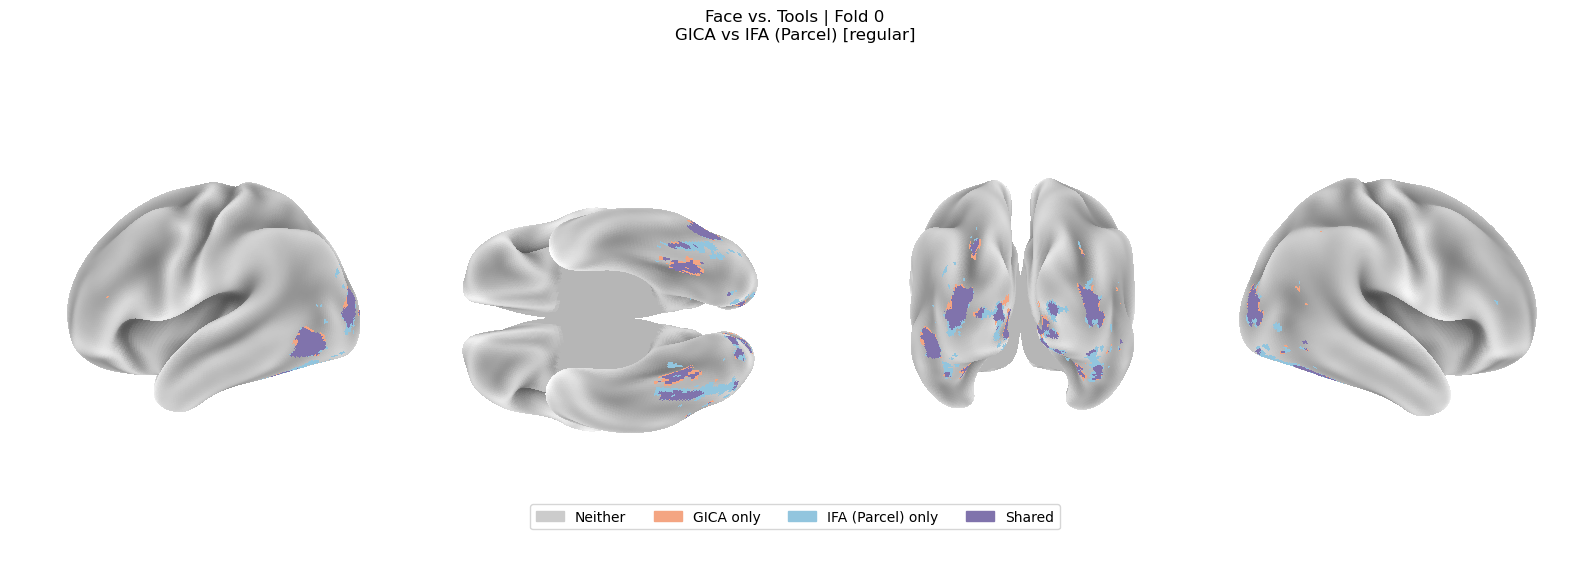

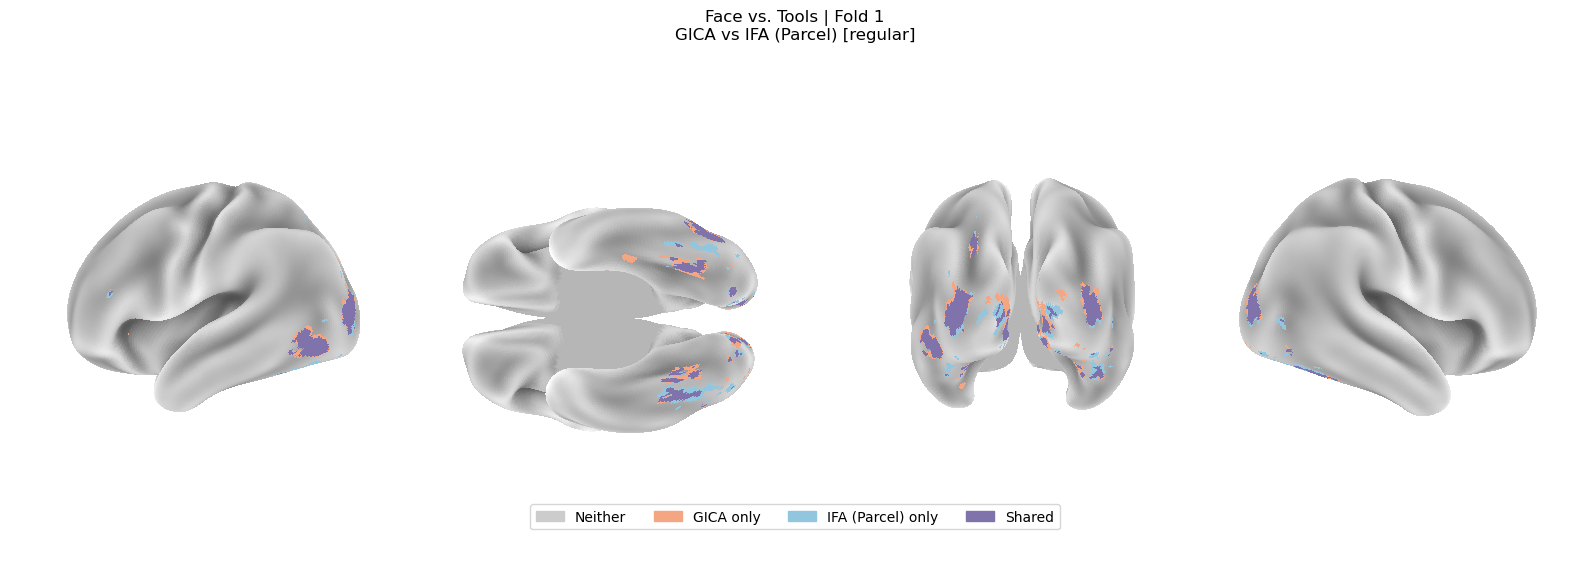

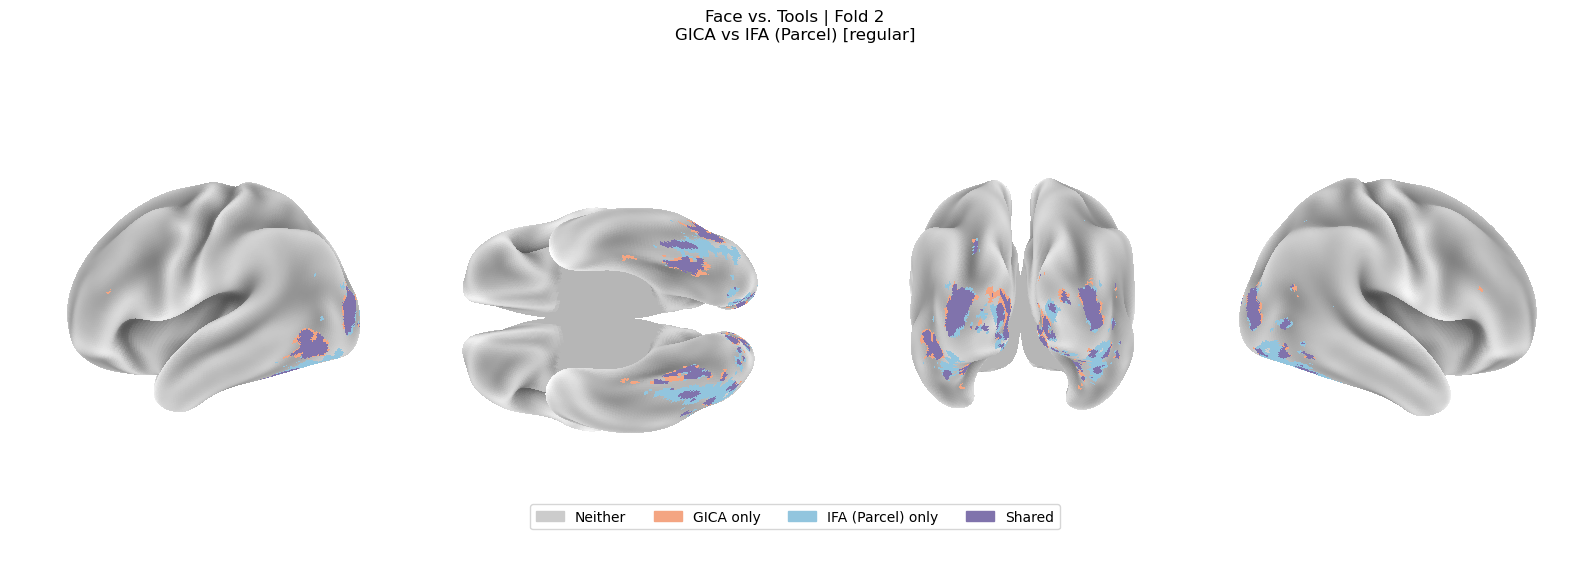

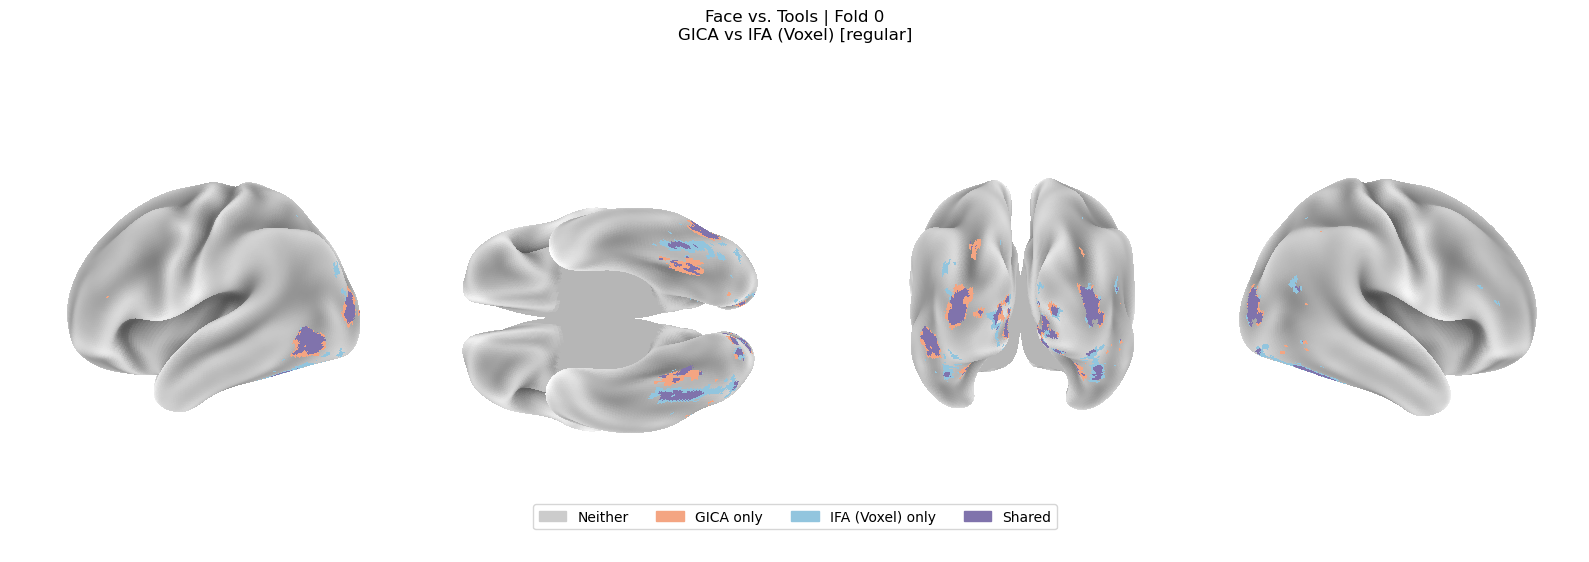

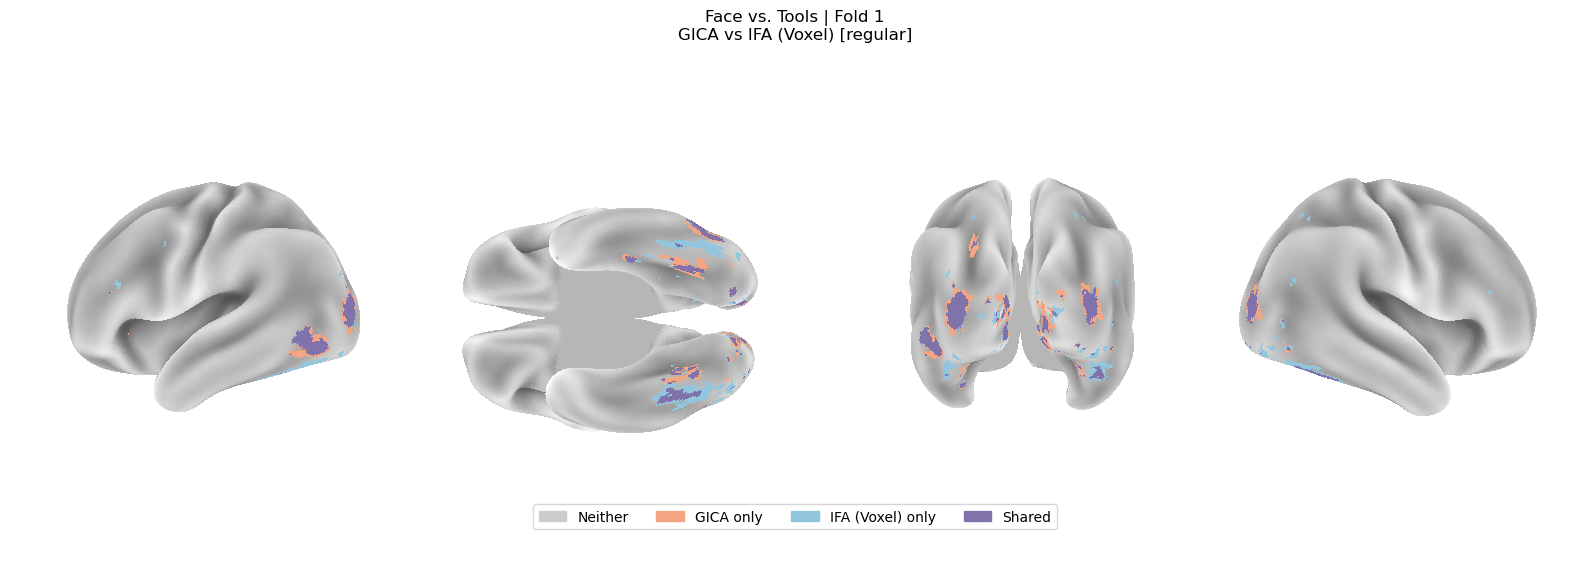

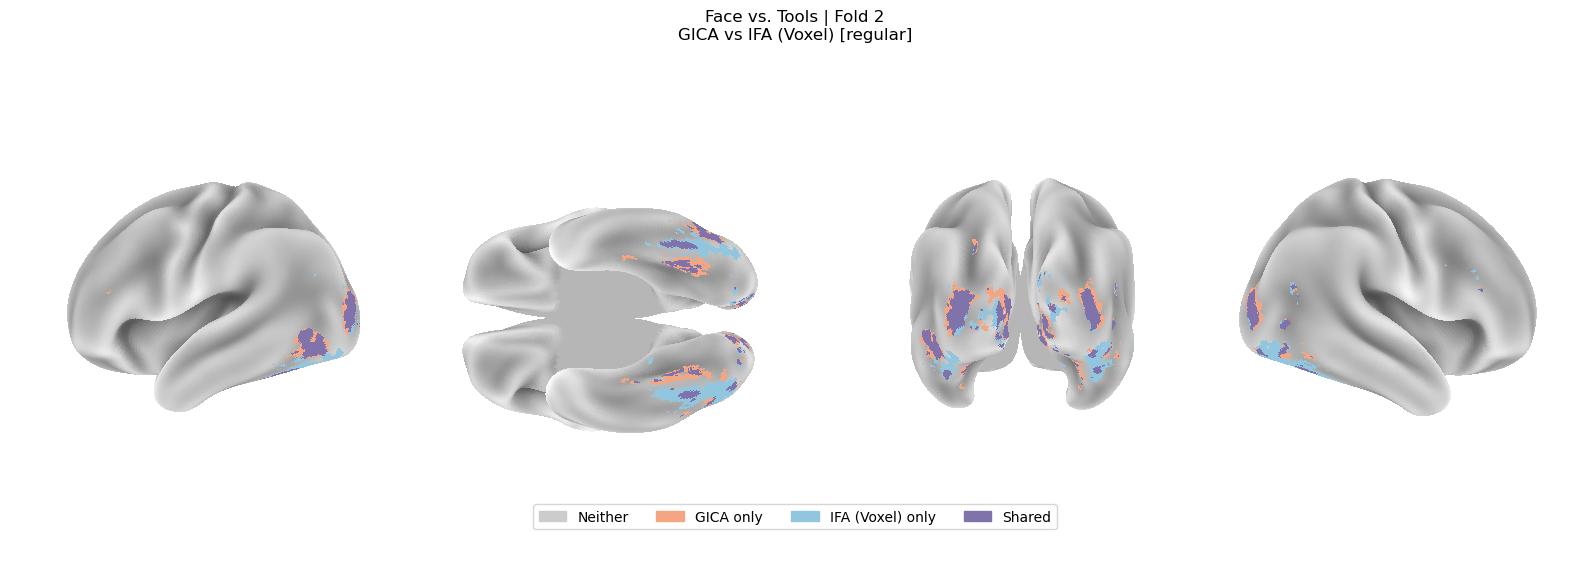

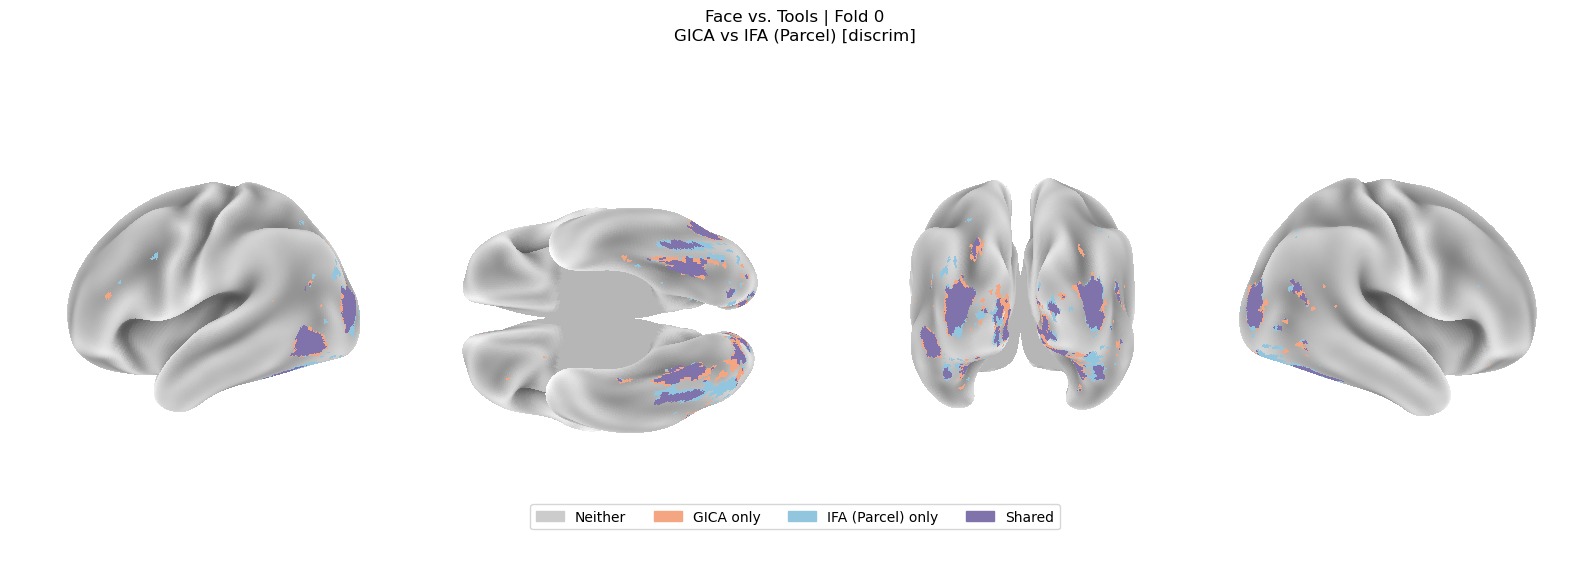

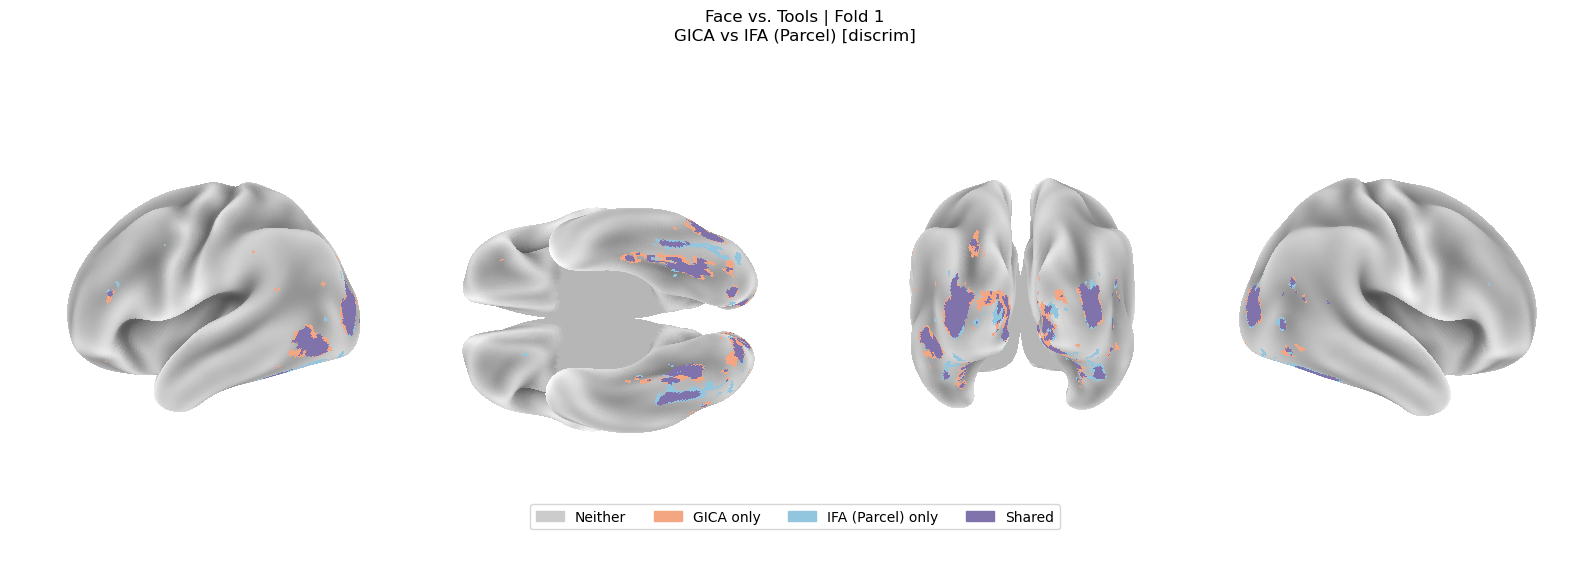

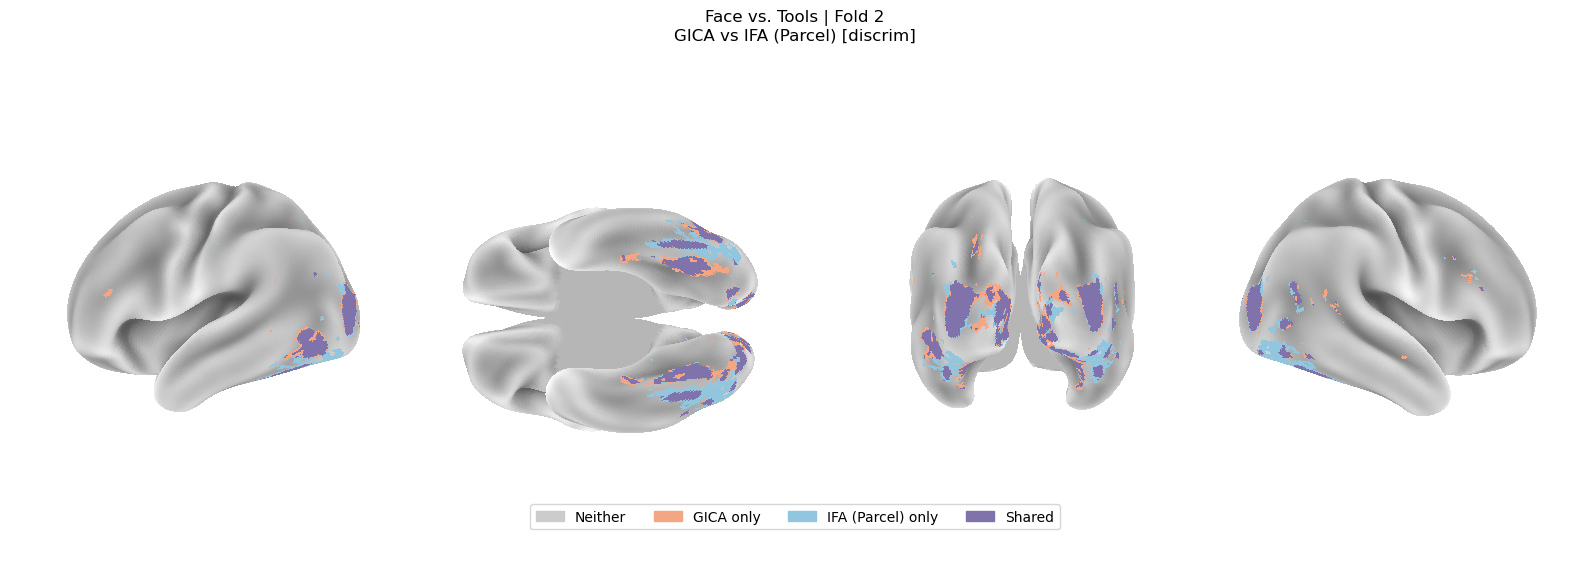

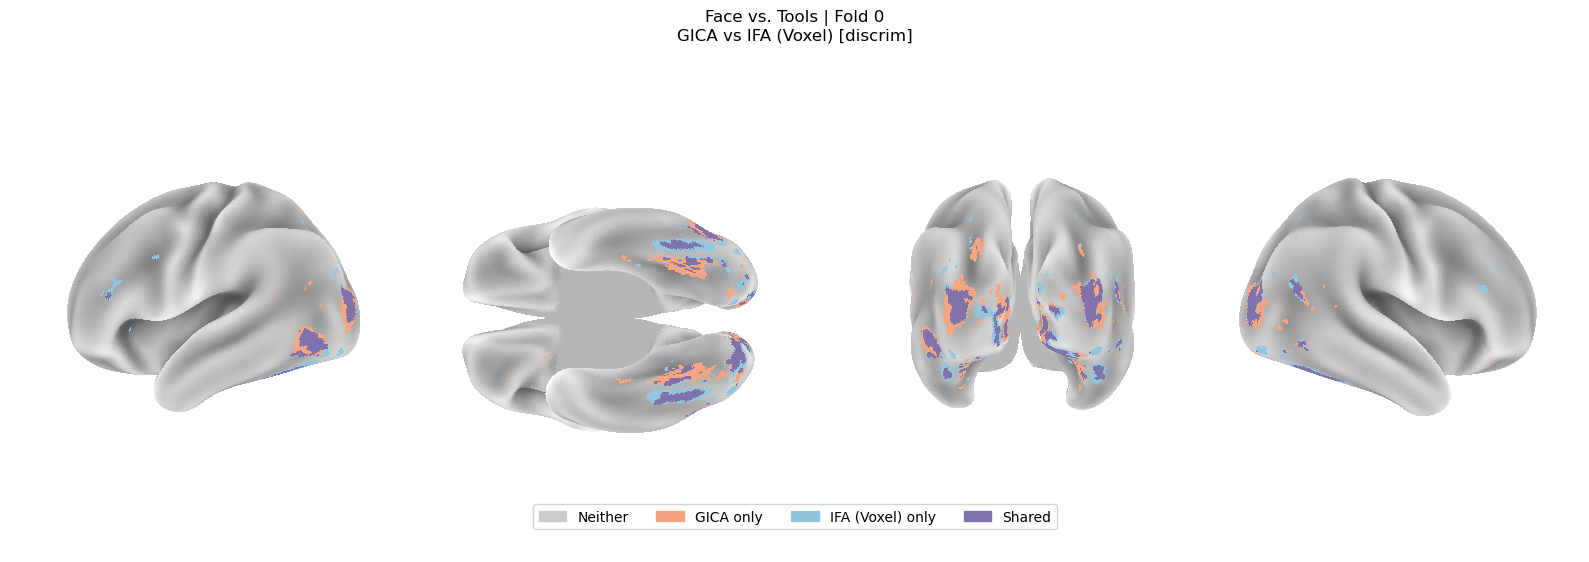

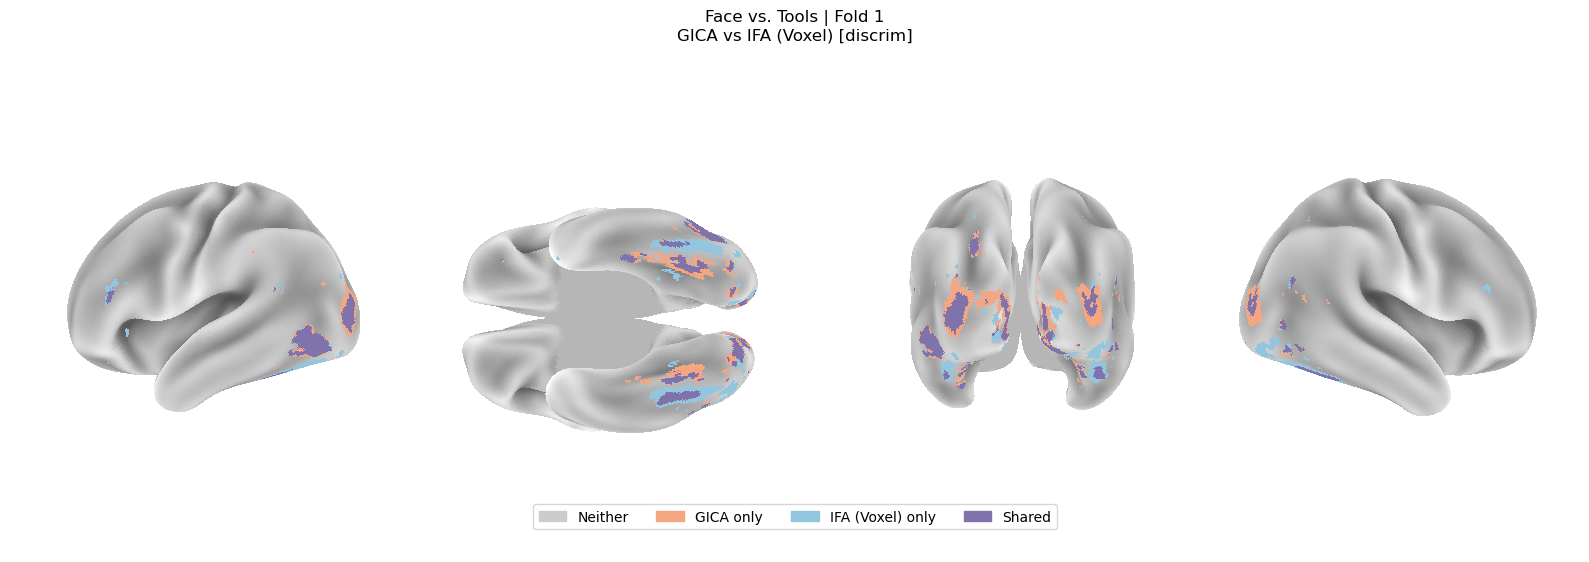

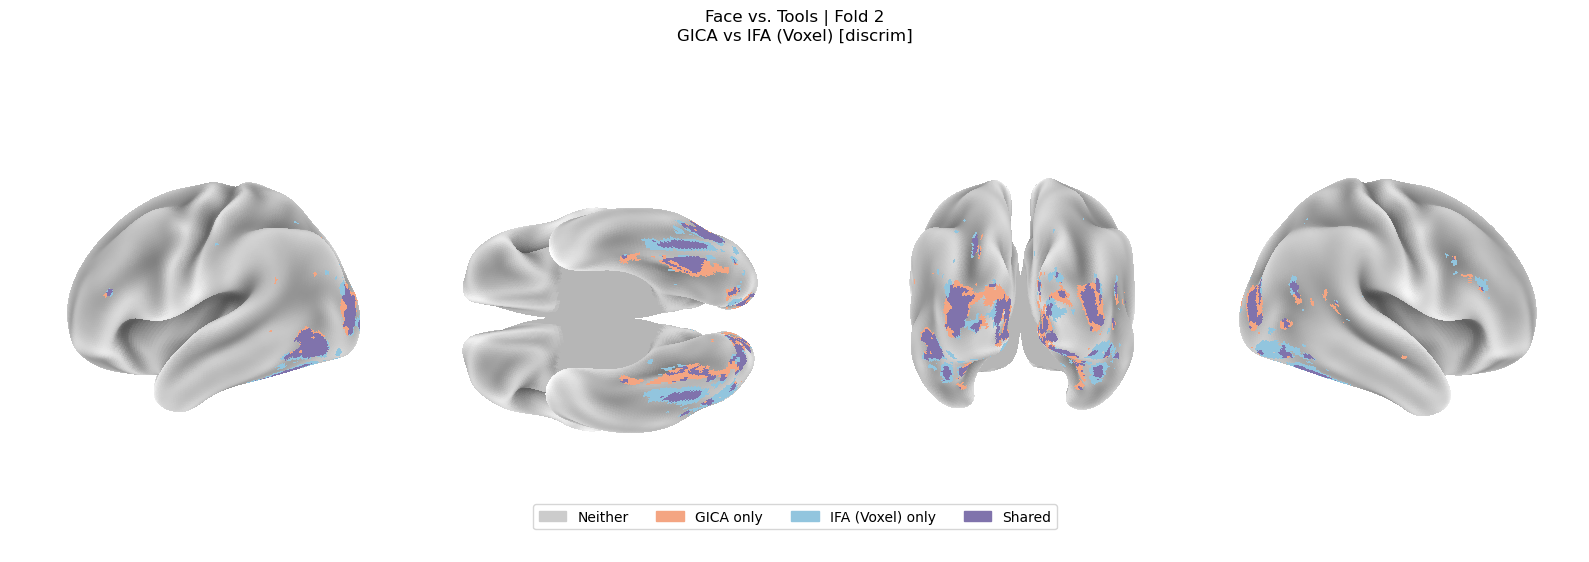


==== Relational ====
Missing: /project/3022057.01/relation_final_s05/fold_3/nPCA_8/Results/GICA/Normalized/results.pkl
Missing: /project/3022057.01/relation_final_s05/fold_3/nPCA_8/Results/parcel_IFA/Normalized/results.pkl
Missing: /project/3022057.01/relation_final_s05/fold_3/nPCA_8/Results/voxel_IFA/Normalized/results.pkl


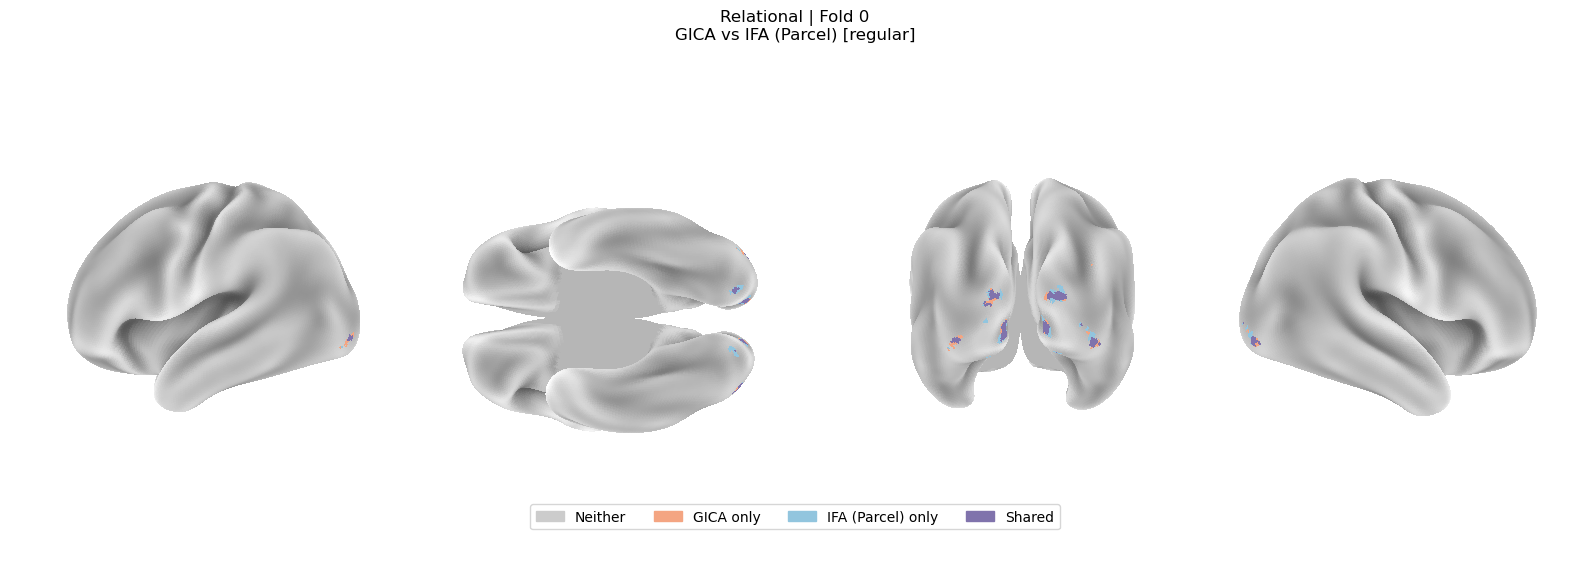

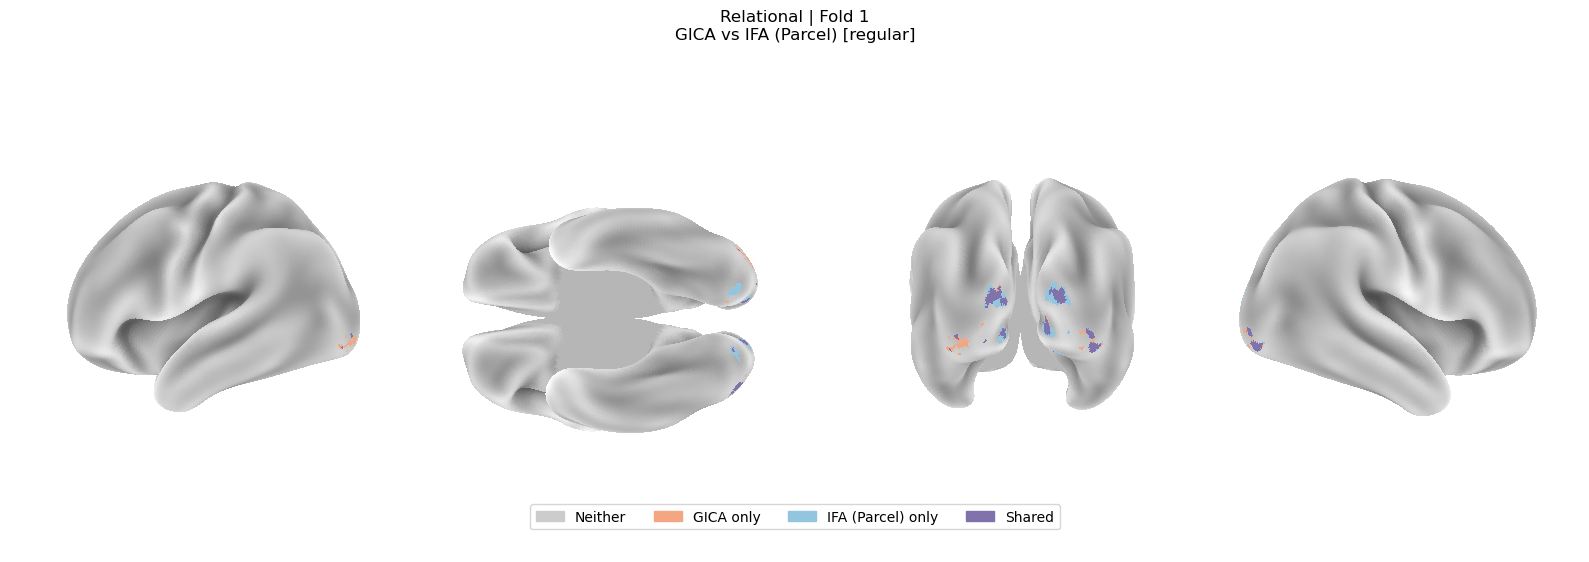

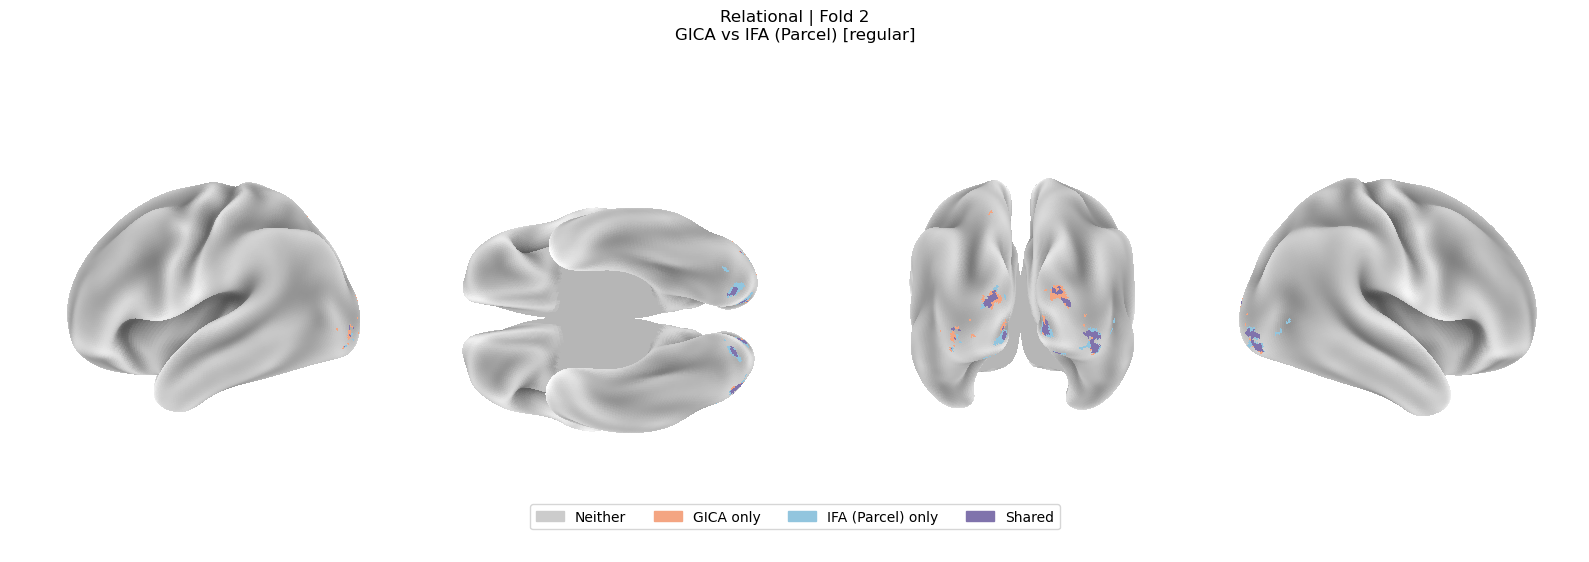

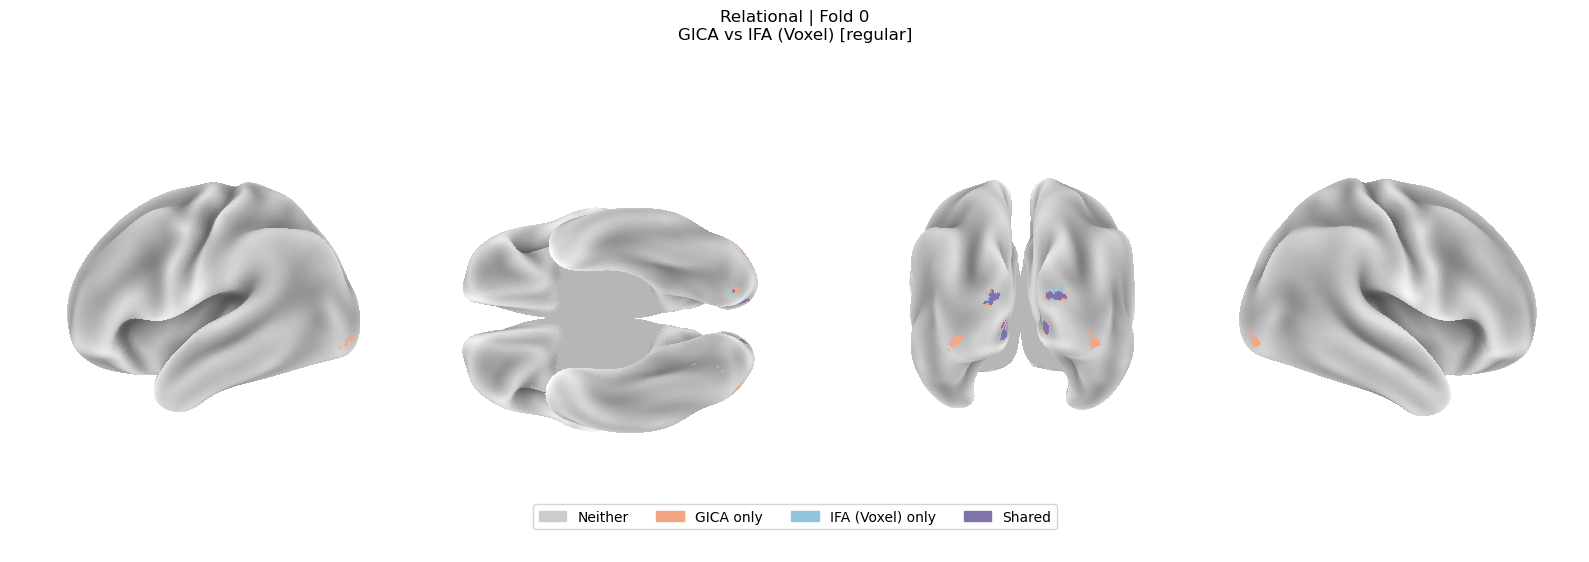

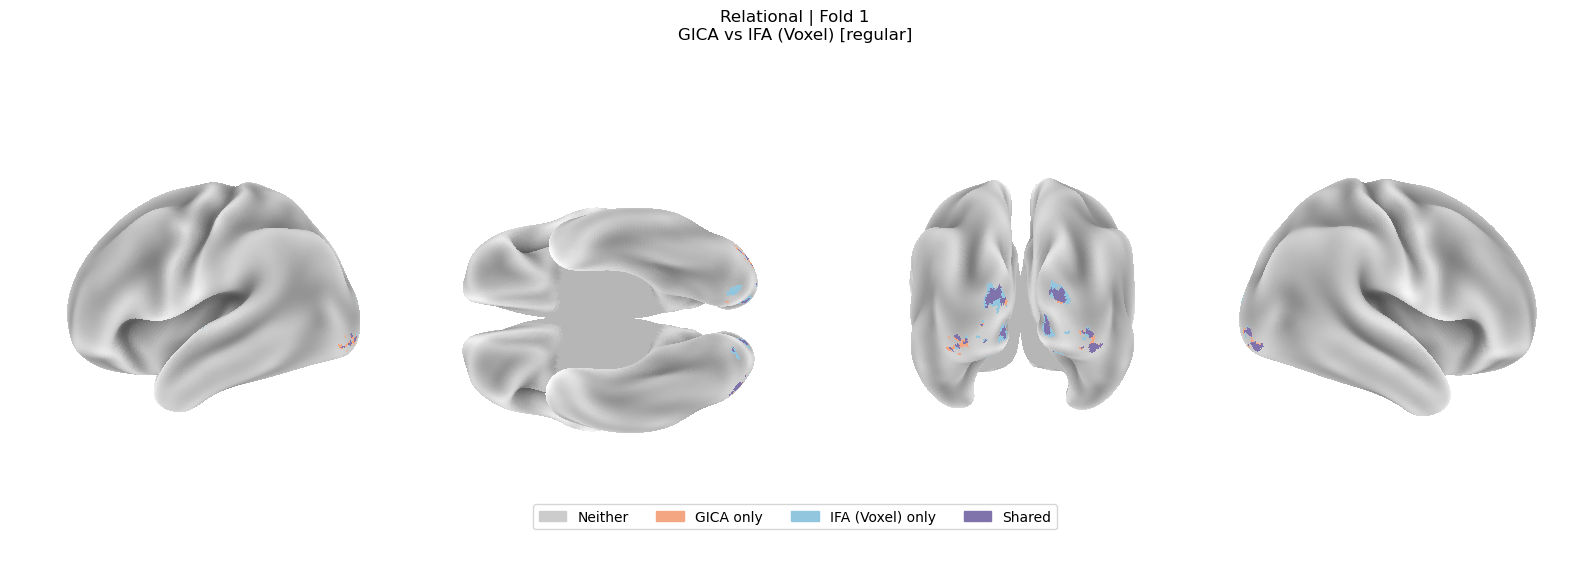

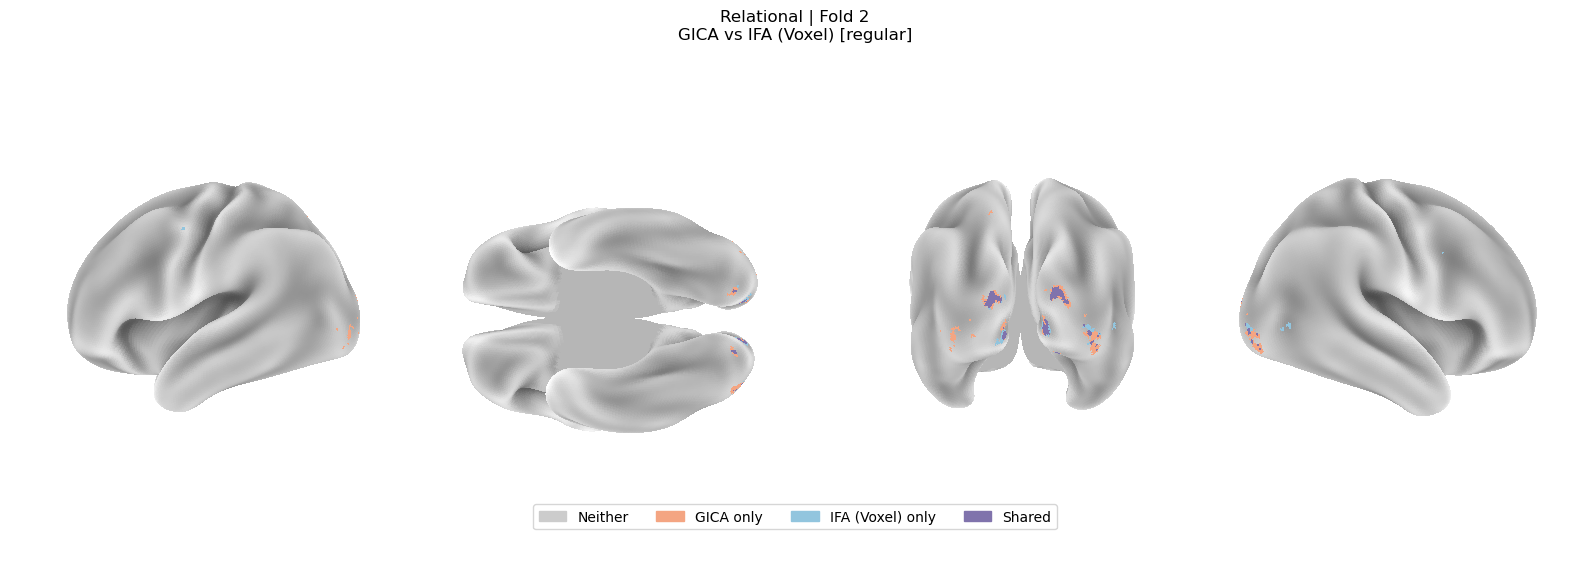

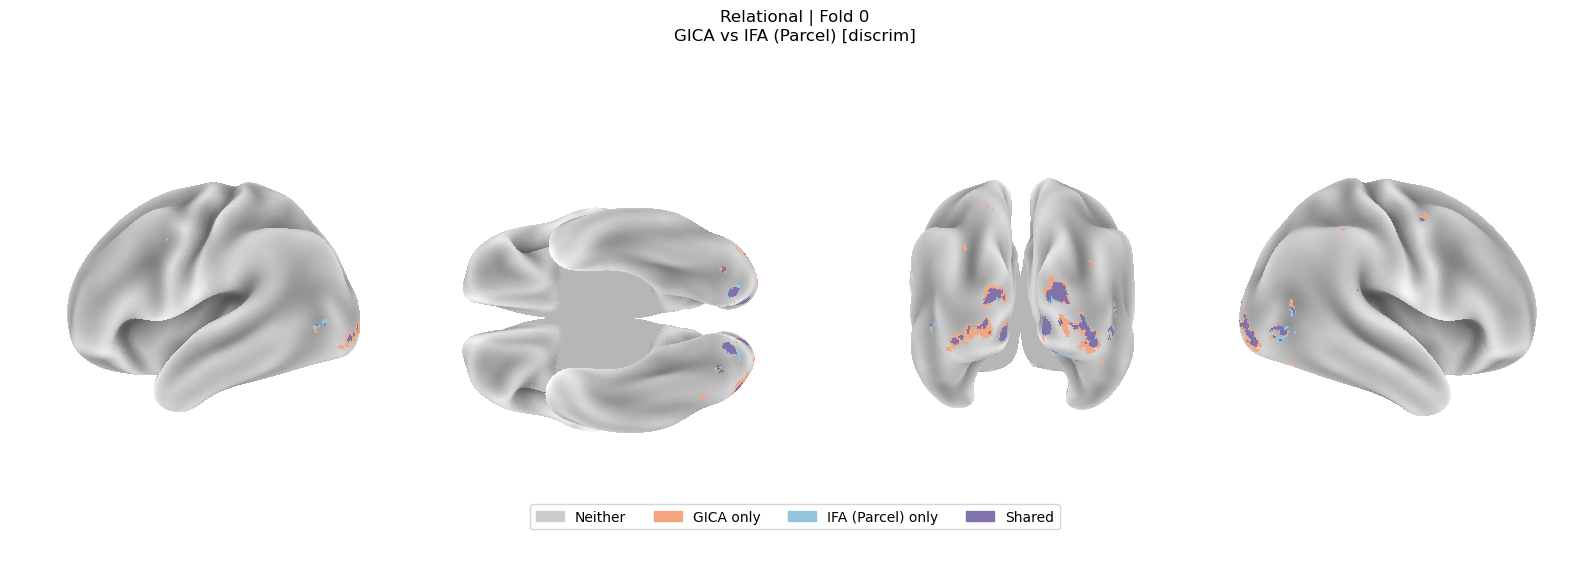

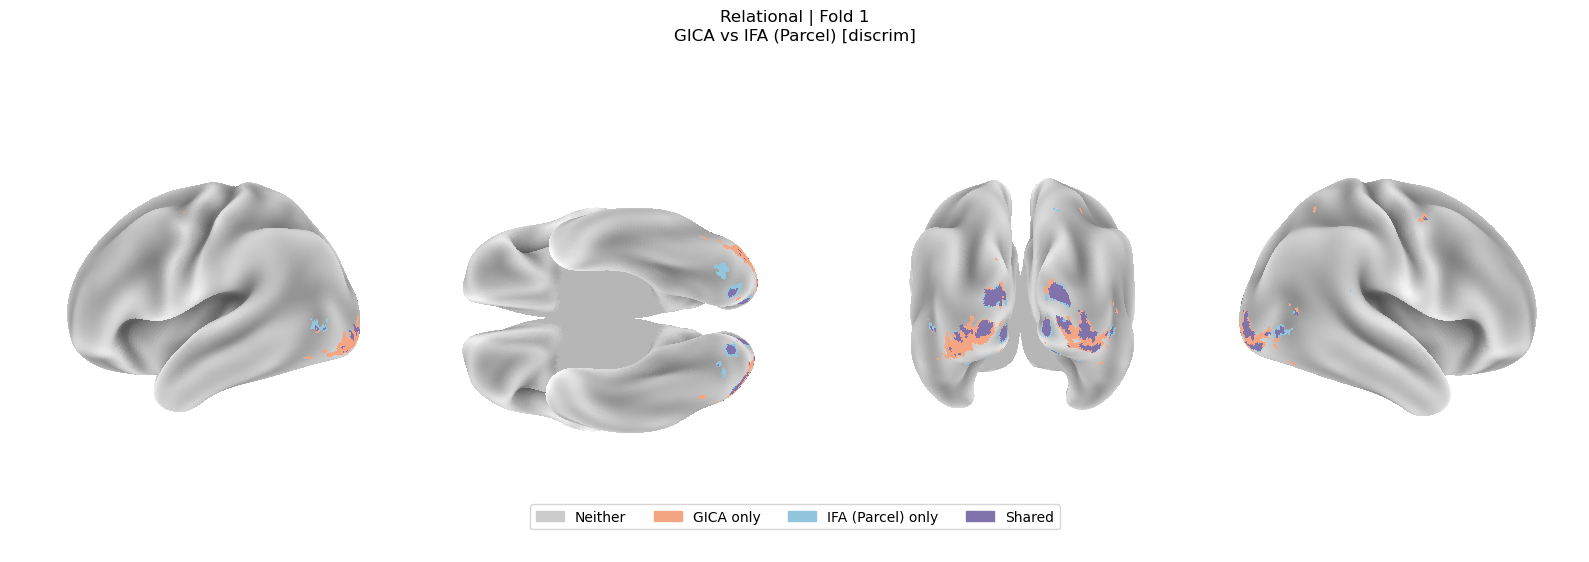

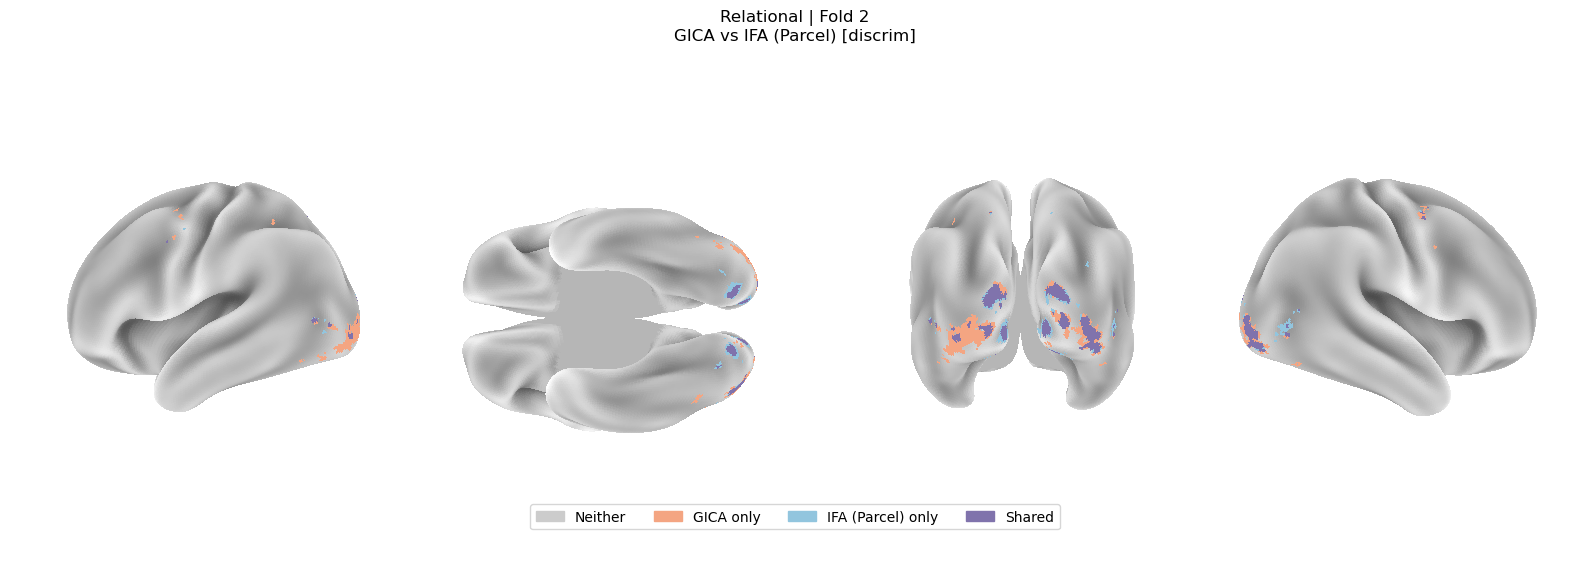

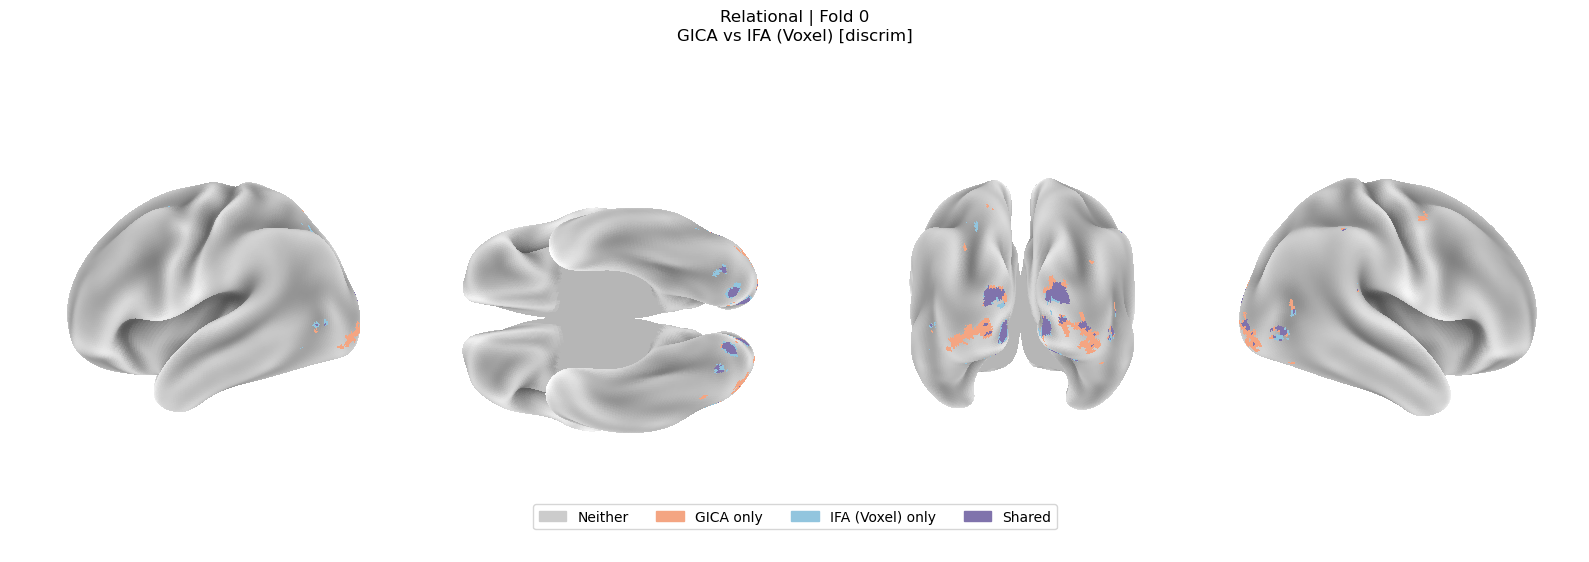

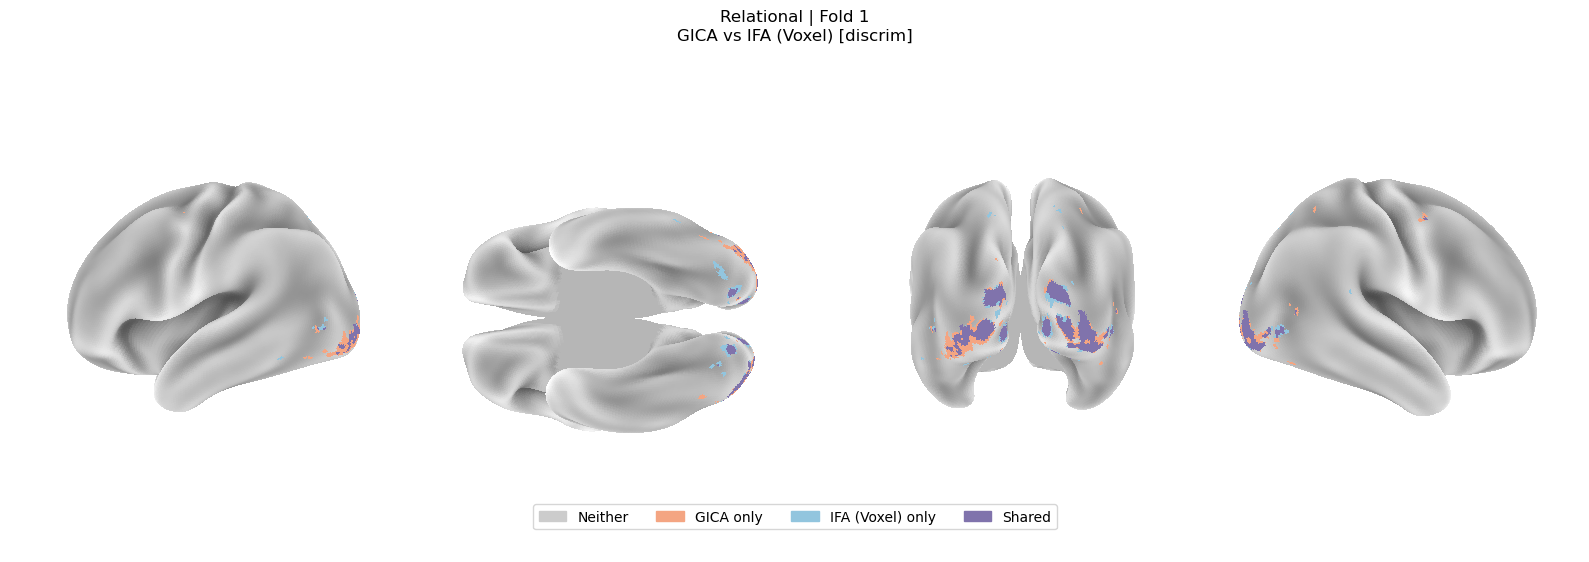

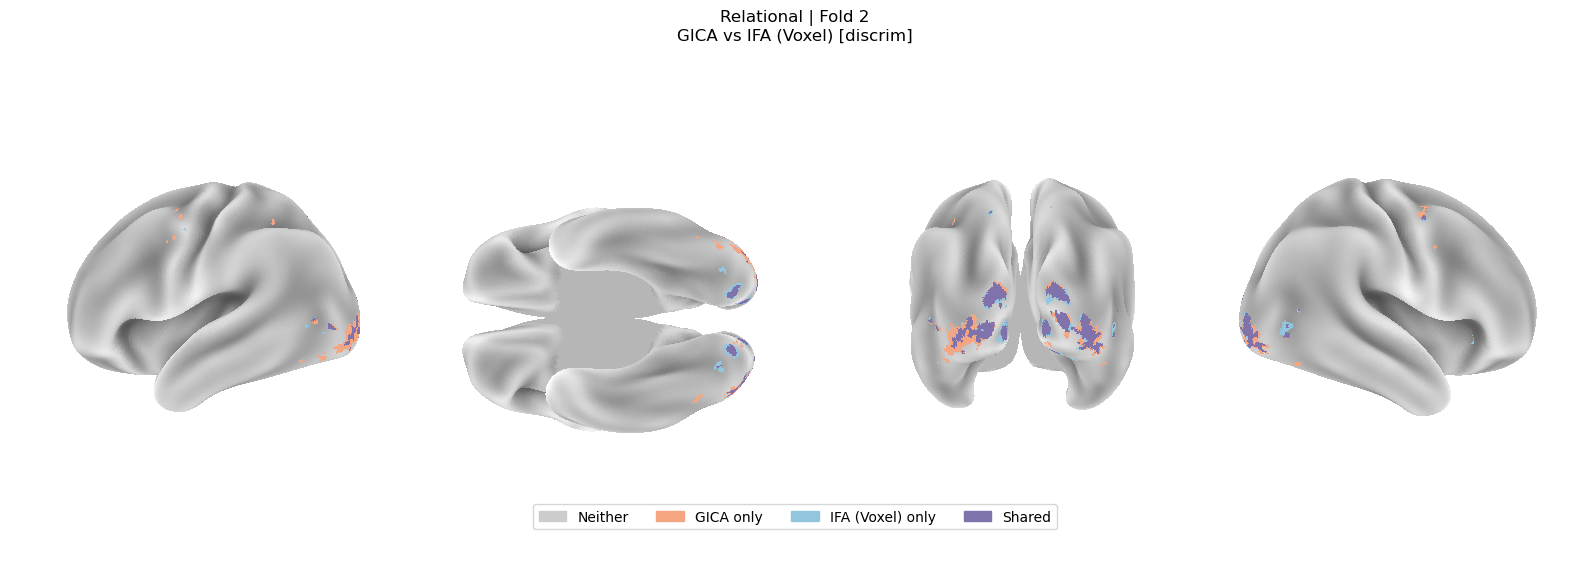


==== Incentive ====


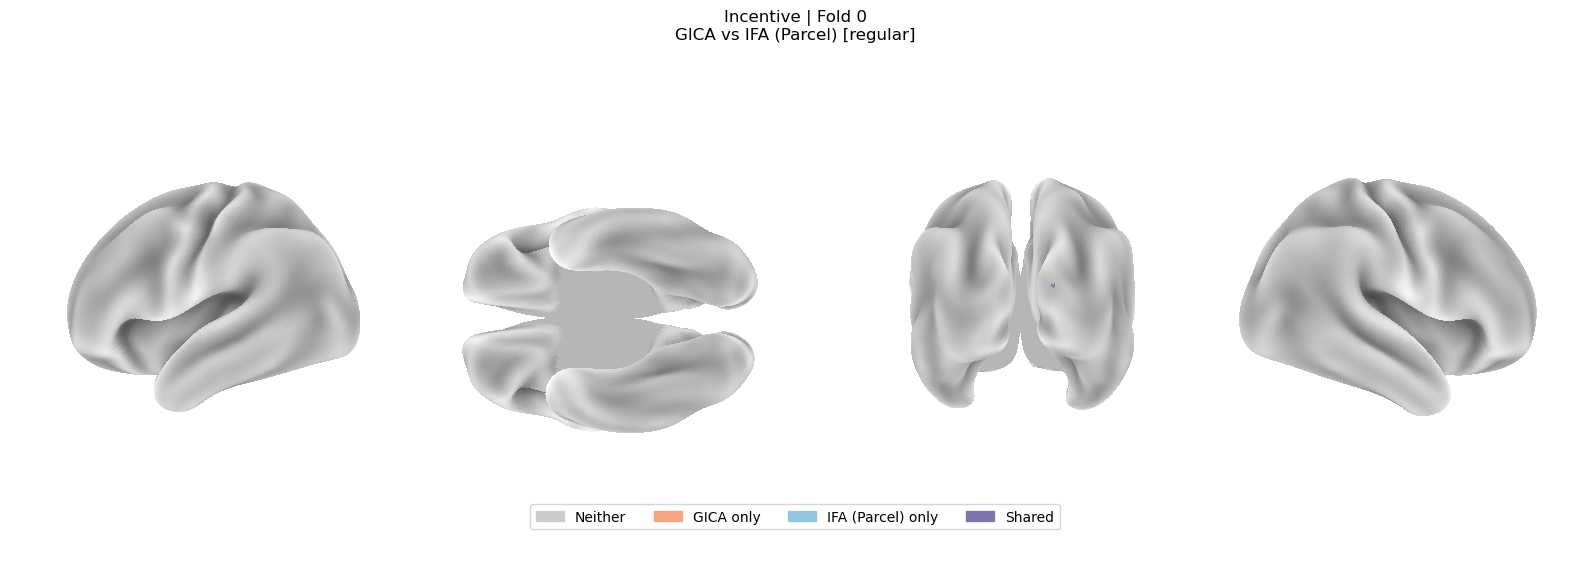

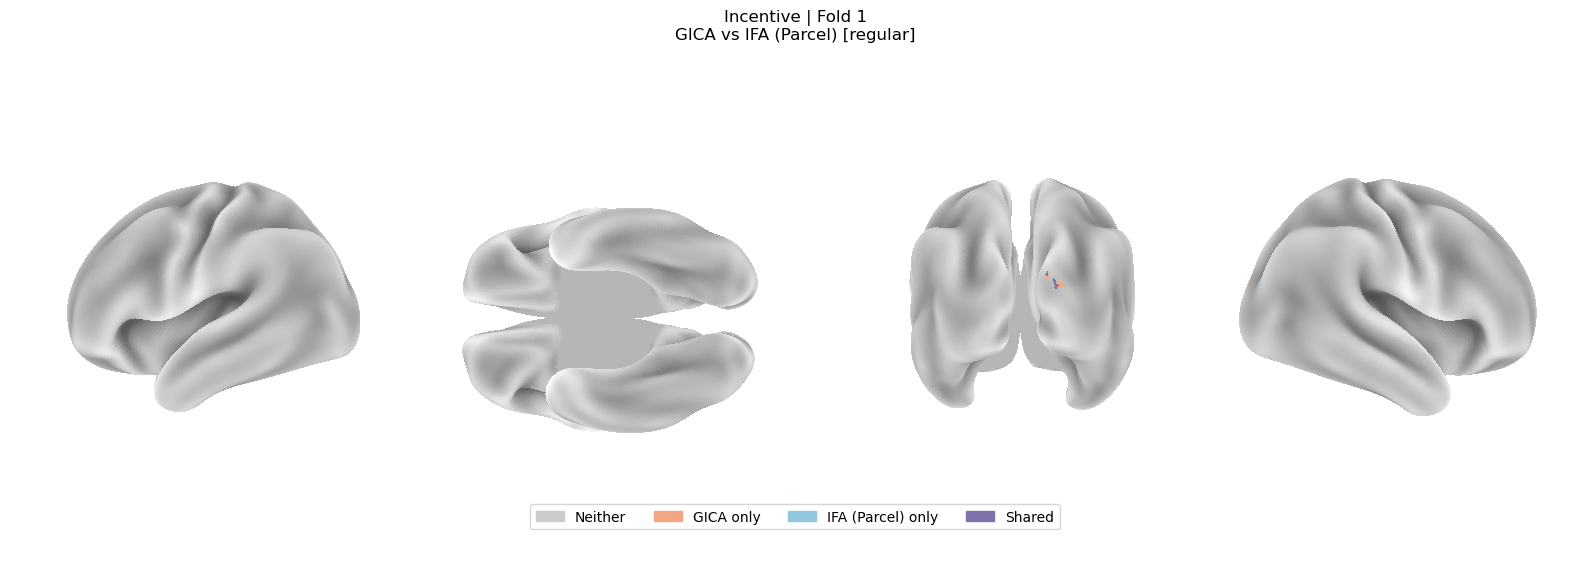

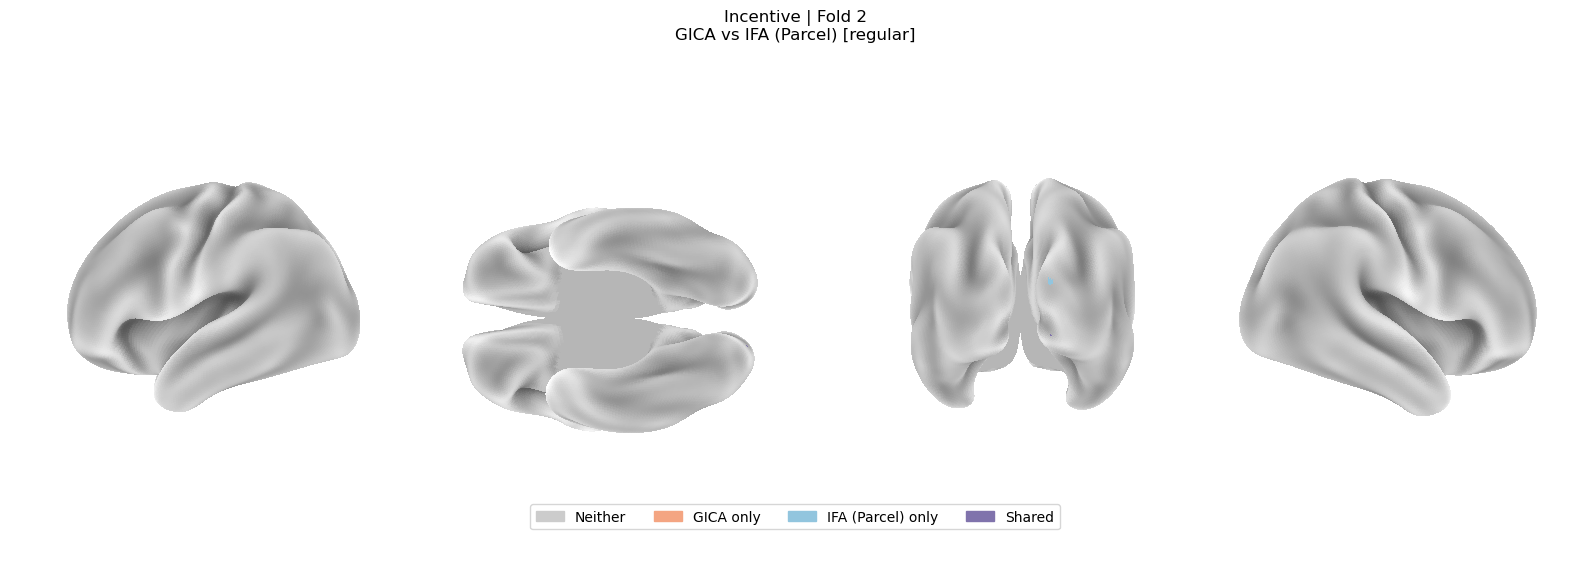

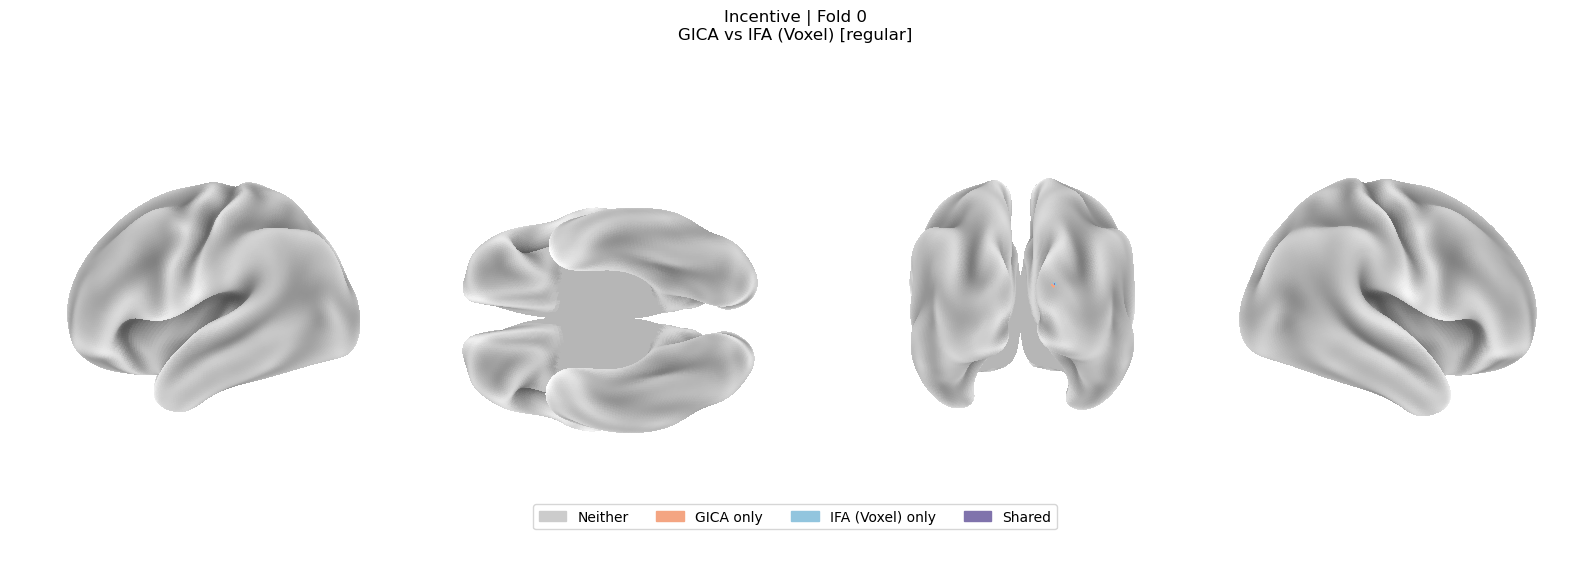

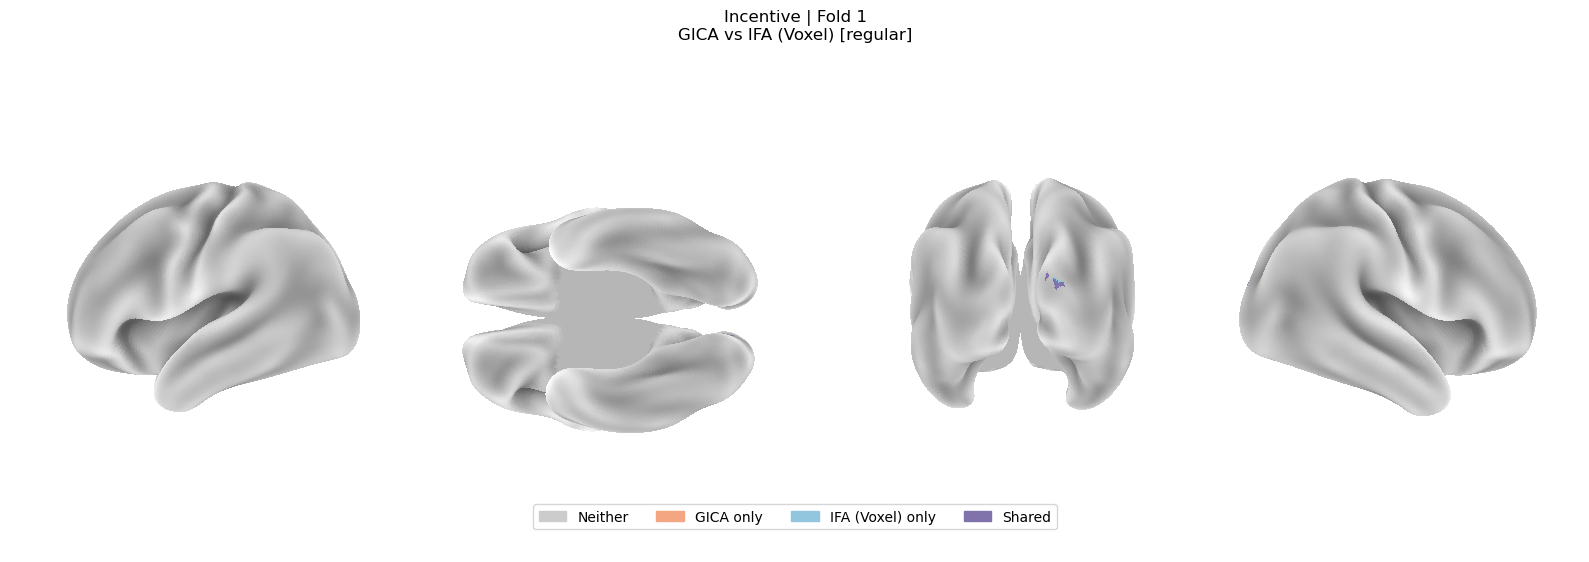

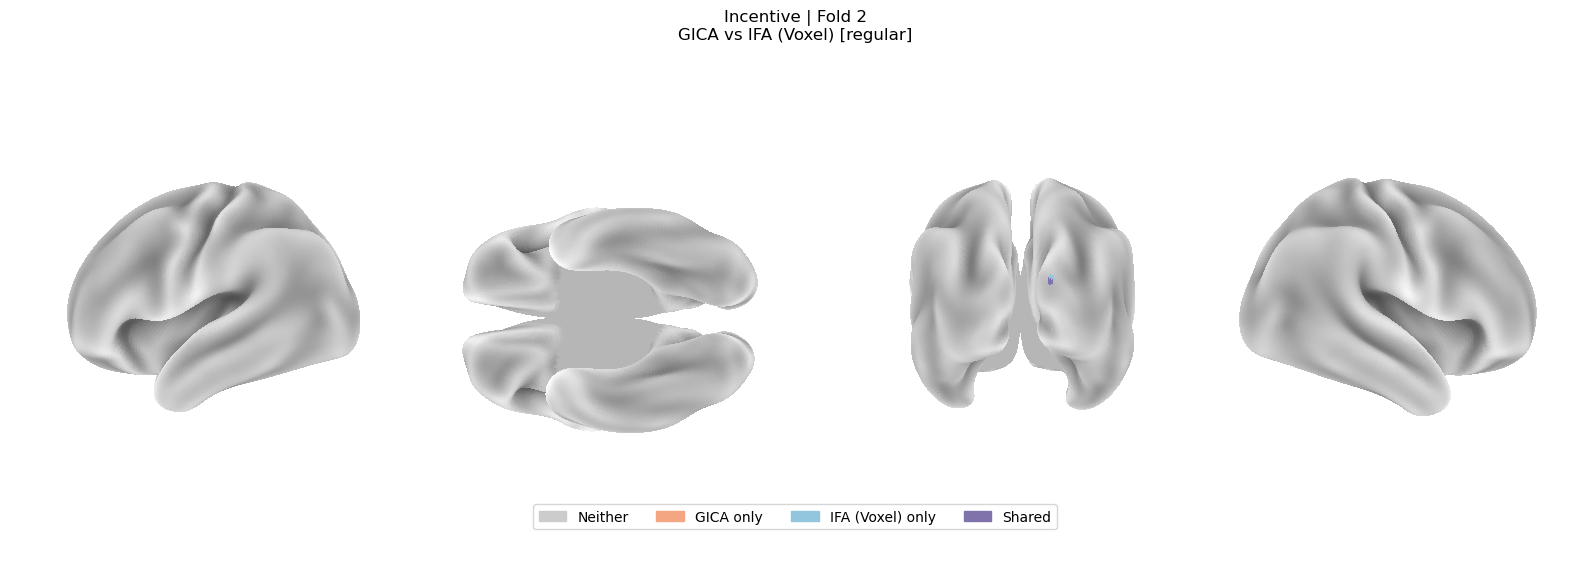

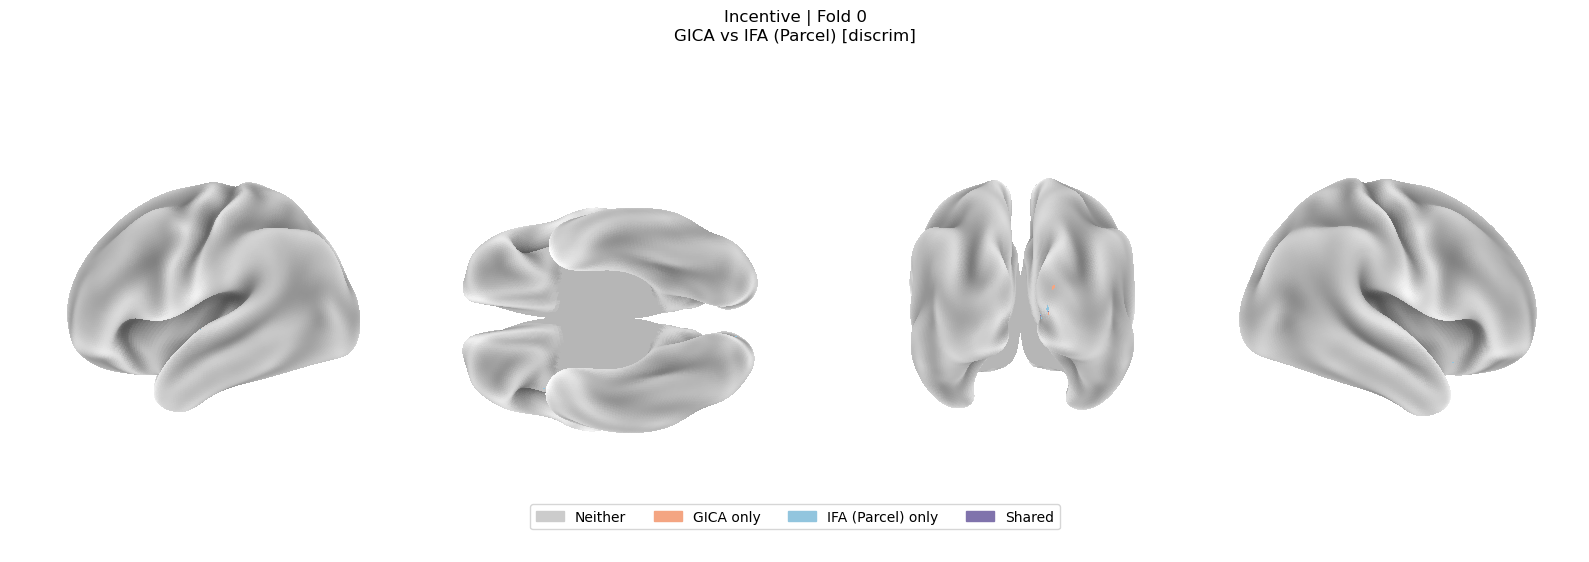

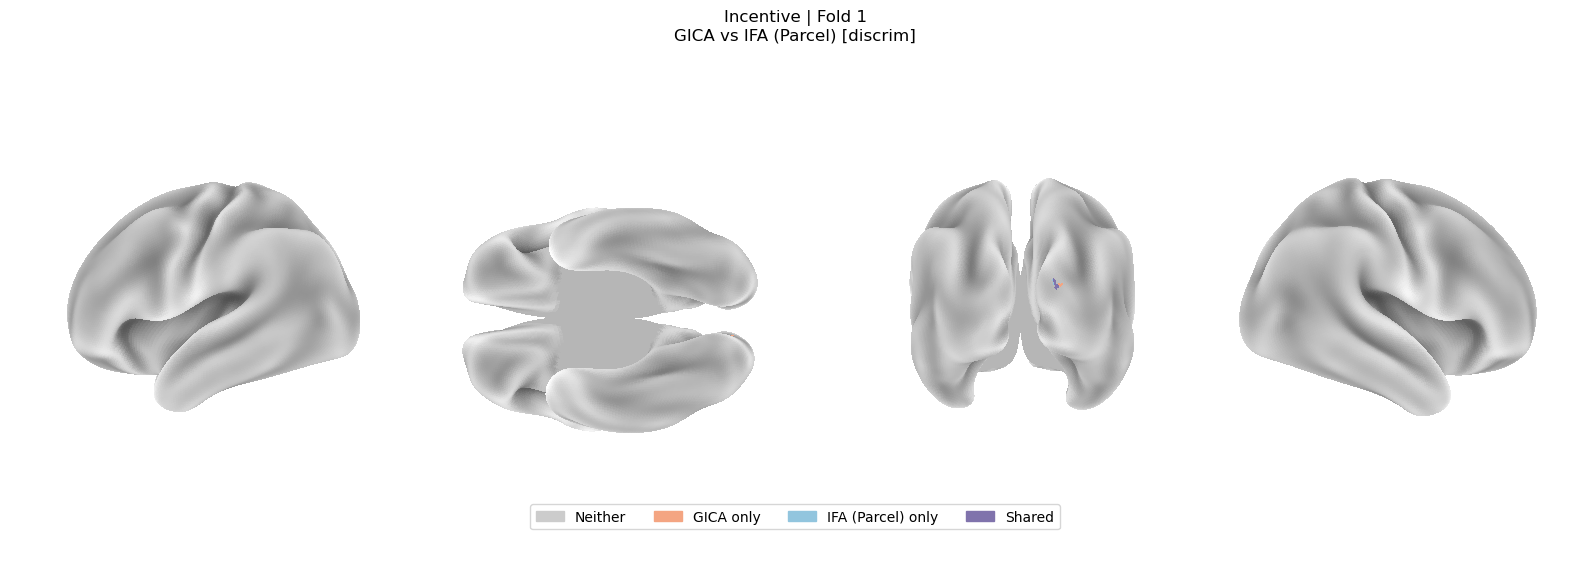

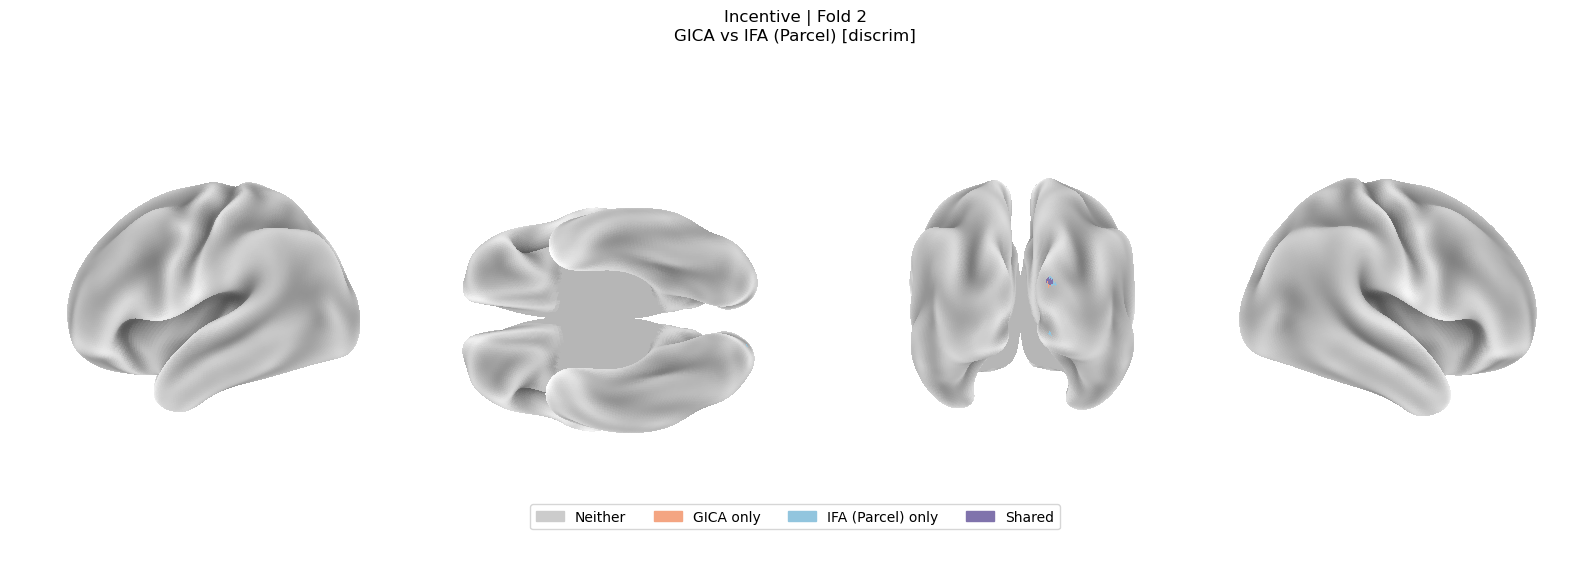

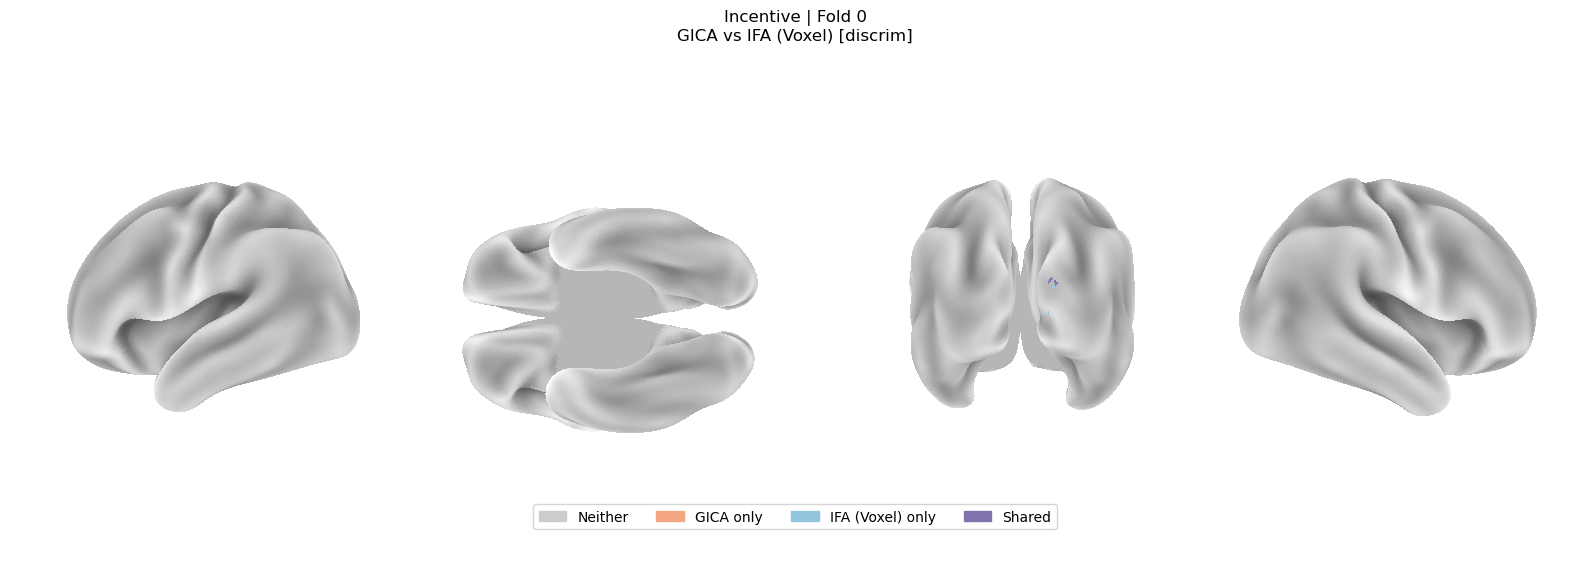

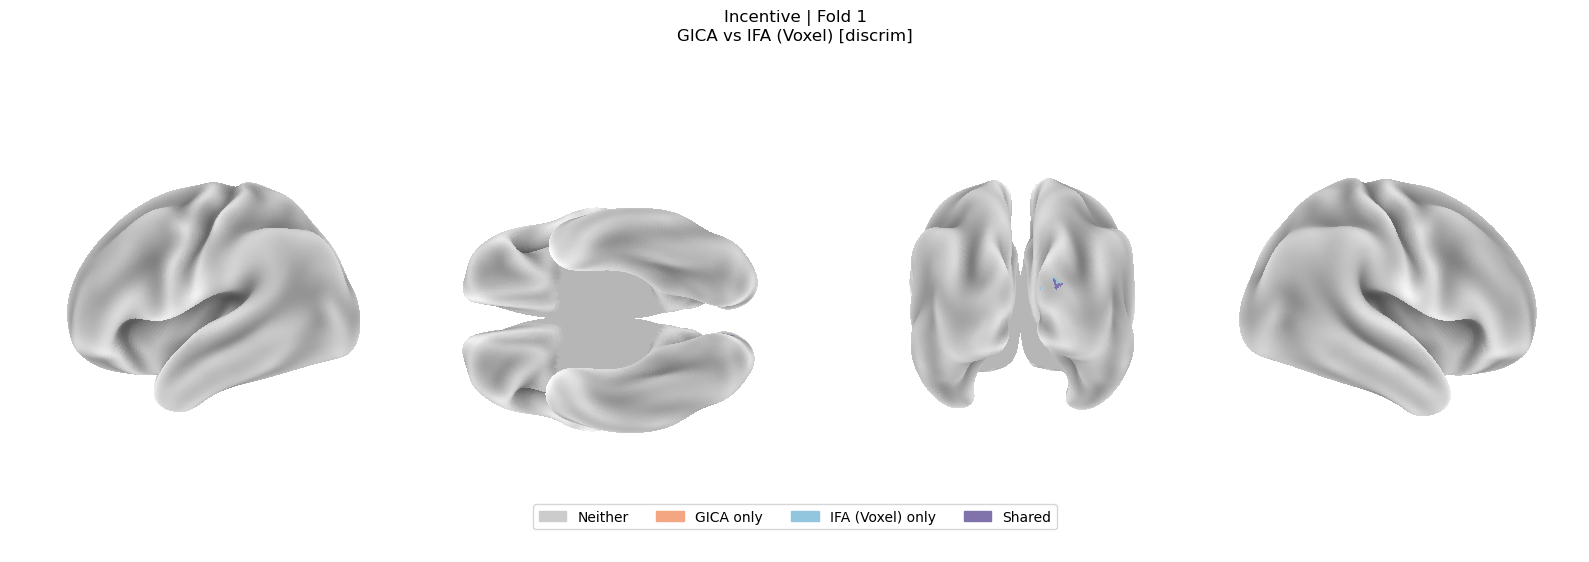

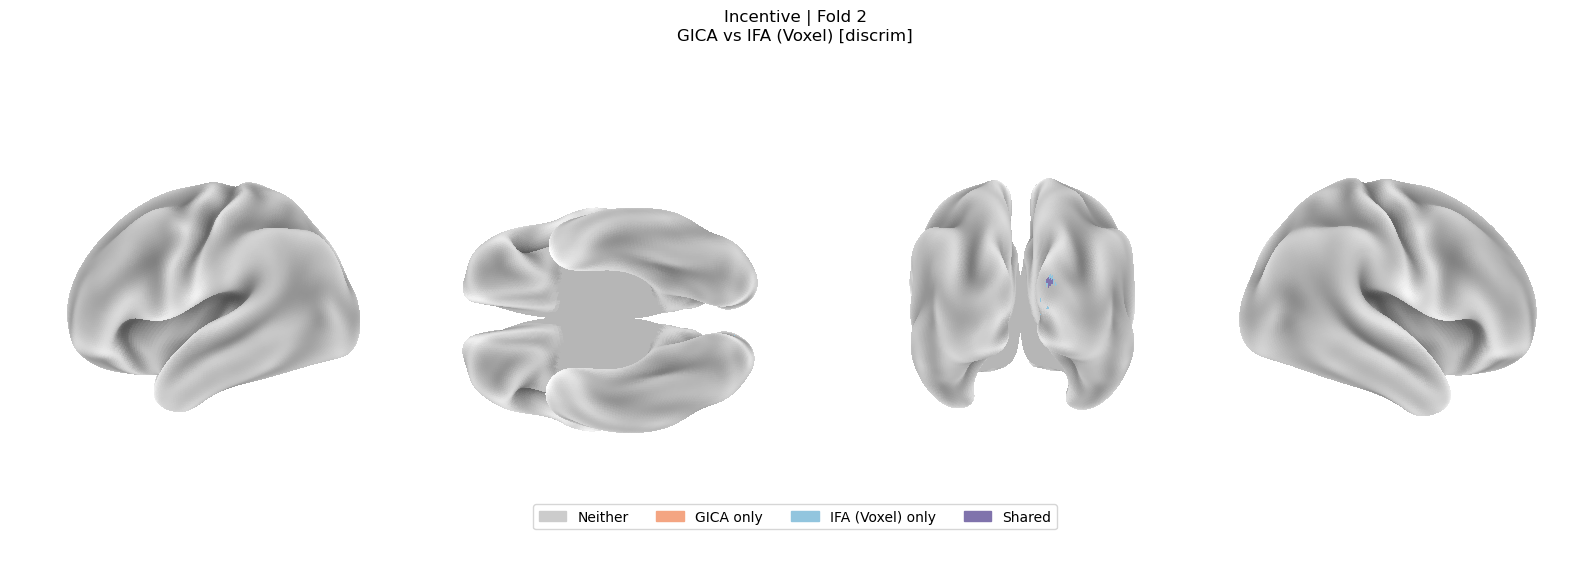

In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import hcp_utils as hcp
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

folders = ["GICA", "parcel_IFA", "voxel_IFA"]
condition_labels = ["Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
    "/project/3022057.01/tools_v_faces_final",
    "/project/3022057.01/relation_final_s05",
    "/project/3022057.01/Gamble_final",
]
folds = [0, 1, 2, 3, 4]
nPCA = 8
alpha = 0.05
views = ["lateral", "ventral", "posterior", "lateral"]

# Color mapping for categories
cmap = ListedColormap([
    "#cccccc",  # 0: neither
    "#f4a582",  # 1: A only
    "#92c5de",  # 2: B only
    "#8073ac",  # 3: shared
])

comparisons = [
    ("GICA", "IFA (Parcel)", "regular"),
    ("GICA", "IFA (Voxel)", "regular"),
    ("GICA", "IFA (Parcel)", "discrim"),
    ("GICA", "IFA (Voxel)", "discrim")
]

label_to_index = {
    "GICA": 0,
    "IFA (Parcel)": 1,
    "IFA (Voxel)": 2
}

def make_legend(label_a, label_b):
    return [
        mpatches.Patch(color="#cccccc", label="Neither"),
        mpatches.Patch(color="#f4a582", label=f"{label_a} only"),
        mpatches.Patch(color="#92c5de", label=f"{label_b} only"),
        mpatches.Patch(color="#8073ac", label="Shared")
    ]

def custom_mode(vertices):
    values, counts = np.unique(vertices, return_counts=True)
    if len(values) == 3:
        if 3 in values and 1 in values and 0 in values:
            return 1  # A only
        elif 3 in values and 2 in values and 0 in values:
            return 2  # B only
        elif 3 in values and 1 in values and 2 in values:
            return 3  # Shared
        else:
            return 0  # Neither
    return values[np.argmax(counts)]

def run_overlay_per_fold():
    for condition_idx, outputfolder in enumerate(condition_paths):
        condition_name = condition_labels[condition_idx]
        print(f"\n==== {condition_name} ====")

        pipe_out = {"regular": [], "discrim": []}

        for pipe in folders:
            reg_pvals = []
            discrim_pvals = []

            for fold in folds:
                path = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results" / pipe / "Normalized" / "results.pkl"
                if not path.exists():
                    print(f"Missing: {path}")
                    continue
                with open(path, "rb") as f:
                    data = pickle.load(f)
                reg = np.min(data["Spatial_t_test"][1], axis=0)
                discrim = np.min(data["Spatial_t_test_discrim"][1], axis=0)
                reg_pvals.append(reg < alpha)
                discrim_pvals.append(discrim < alpha)

            pipe_out["regular"].append(np.array(reg_pvals))
            pipe_out["discrim"].append(np.array(discrim_pvals))

        # === Fold-wise comparisons ===
        for label_a, label_b, kind in comparisons:
            data = pipe_out[kind]
            data_a = data[label_to_index[label_a]]
            data_b = data[label_to_index[label_b]]

            for fold_idx in range(len(pipe_out["regular"])):
                sig_a = data_a[fold_idx]
                sig_b = data_b[fold_idx]

                a_only = sig_a & ~sig_b
                b_only = sig_b & ~sig_a
                shared = sig_a & sig_b
                neither = ~(sig_a | sig_b)

                composite = np.zeros_like(sig_a, dtype=int)
                composite[a_only] = 1
                composite[b_only] = 2
                composite[shared] = 3

                # Plotting
                fig = plt.figure(figsize=(4 * len(views), 6))
                gs = gridspec.GridSpec(2, len(views), height_ratios=[6, 1])

                for i, view in enumerate(views):
                    ax = fig.add_subplot(gs[0, i], projection="3d")
                    hemi = "right" if (view == "lateral" and i == len(views) - 1) else "left"
                    plotting.plot_surf(
                        surf_mesh=hcp.mesh.inflated,
                        surf_map=hcp.cortex_data(composite),
                        bg_map=hcp.mesh.sulc,
                        hemi=hemi,
                        view=view,
                        cmap=cmap,
                        colorbar=False,
                        axes=ax,
                        threshold=0.0001,
                        symmetric_cmap=False,
                        avg_method=custom_mode
                    )

                # Legend
                legend_ax = fig.add_subplot(gs[1, :])
                legend_ax.axis("off")
                legend_ax.legend(handles=make_legend(label_a, label_b), loc="center", ncol=4, fontsize=10)

                title = (
                    f"{condition_name} | Fold {fold_idx}\n"
                    f"{label_a} vs {label_b} [{kind}]"
                )
                fig.suptitle(title, fontsize=12)
                plt.tight_layout(rect=[0, 0.05, 1, 0.95])
                plt.show()

run_overlay_per_fold()

In [164]:
import numpy as np
import pickle
import pandas as pd
from pathlib import Path
import hcp_utils as hcp

# ------------------ PARAMETERS ------------------
folders = ["GICA", "parcel_IFA", "voxel_IFA"]
condition_labels = ["Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
    "/project/3022057.01/tools_v_faces_final",
    "/project/3022057.01/relation_final_s05",
    "/project/3022057.01/Gamble_final",
]
folds = [0, 1, 2, 3, 4]
nPCA = 8
alpha = 0.05

comparisons = [
    ("GICA", "IFA (Parcel)", "regular"),
    ("GICA", "IFA (Voxel)", "regular"),
    ("GICA", "IFA (Parcel)", "discrim"),
    ("GICA", "IFA (Voxel)", "discrim")
]

label_to_index = {
    "GICA": 0,
    "IFA (Parcel)": 1,
    "IFA (Voxel)": 2
}

# ------------------ LOAD PARCELLATION ------------------
parcel_map = hcp.mmp["map_all"]
labels = hcp.mmp["labels"]

def parcel_overlap_table(sig_a, sig_b, parcel_vec, labels_dict, meta):
    a_only = sig_a & ~sig_b
    b_only = sig_b & ~sig_a
    shared = sig_a & sig_b

    parcel_ids = np.unique(parcel_vec)
    rows = []

    for pid in parcel_ids:
        if pid == 0:
            continue
        mask = parcel_vec == pid
        n_tot = mask.sum()
        if n_tot == 0:
            continue

        pct_a = a_only[mask].sum() / n_tot * 100
        pct_b = b_only[mask].sum() / n_tot * 100
        pct_s = shared[mask].sum() / n_tot * 100

        if (pct_a + pct_b + pct_s) > 0:
            rows.append({
                **meta,
                "parcel_id": int(pid),
                "label": labels_dict.get(pid, ""),
                "pct_A_only": round(pct_a, 2),
                "pct_B_only": round(pct_b, 2),
                "pct_shared": round(pct_s, 2)
            })
    return rows

# ------------------ MAIN ANALYSIS ------------------
all_results = []

for cond_idx, outputfolder in enumerate(condition_paths):
    cond_name = condition_labels[cond_idx]
    pipe_out = {"regular": [], "discrim": []}

    for pipe in folders:
        reg_masks, discrim_masks = [], []
        for fold in folds:
            p = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results" / pipe / "Normalized" / "results.pkl"
            if not p.exists():
                continue
            with open(p, "rb") as f:
                data = pickle.load(f)
            reg_p = np.min(data["Spatial_t_test"][1], axis=0)
            dis_p = np.min(data["Spatial_t_test_discrim"][1], axis=0)
            reg_masks.append(reg_p < alpha)
            discrim_masks.append(dis_p < alpha)
        pipe_out["regular"].append(np.array(reg_masks))
        pipe_out["discrim"].append(np.array(discrim_masks))

    for label_a, label_b, kind in comparisons:
        idx_a = label_to_index[label_a]
        idx_b = label_to_index[label_b]
        data_a = pipe_out[kind][idx_a]
        data_b = pipe_out[kind][idx_b]

        for fold_idx in range(min(len(data_a), len(data_b))):
            sig_a = data_a[fold_idx]
            sig_b = data_b[fold_idx]

            meta = {
                "condition": cond_name,
                "comparison": f"{label_a} vs {label_b}",
                "fold": fold_idx,
                "type": kind
            }
            rows = parcel_overlap_table(sig_a, sig_b, parcel_map, labels, meta)
            all_results.extend(rows)

# Save to CSV
output_dir_spatial_t = "ifa_gica_summary_spatial"
os.makedirs(output_dir_spatial_t, exist_ok=True)

output_df = pd.DataFrame(all_results)
output_df.to_csv(os.path.join(output_dir_spatial_t,"ifa_gica_overlap_summary.csv"), index=False)
print("✅ Results saved to 'ifa_gica_overlap_summary.csv'")

✅ Results saved to 'ifa_gica_overlap_summary.csv'


✅ Saved: Face_vs._Tools__GICA_vs_IFA_Parcel__regular.csv


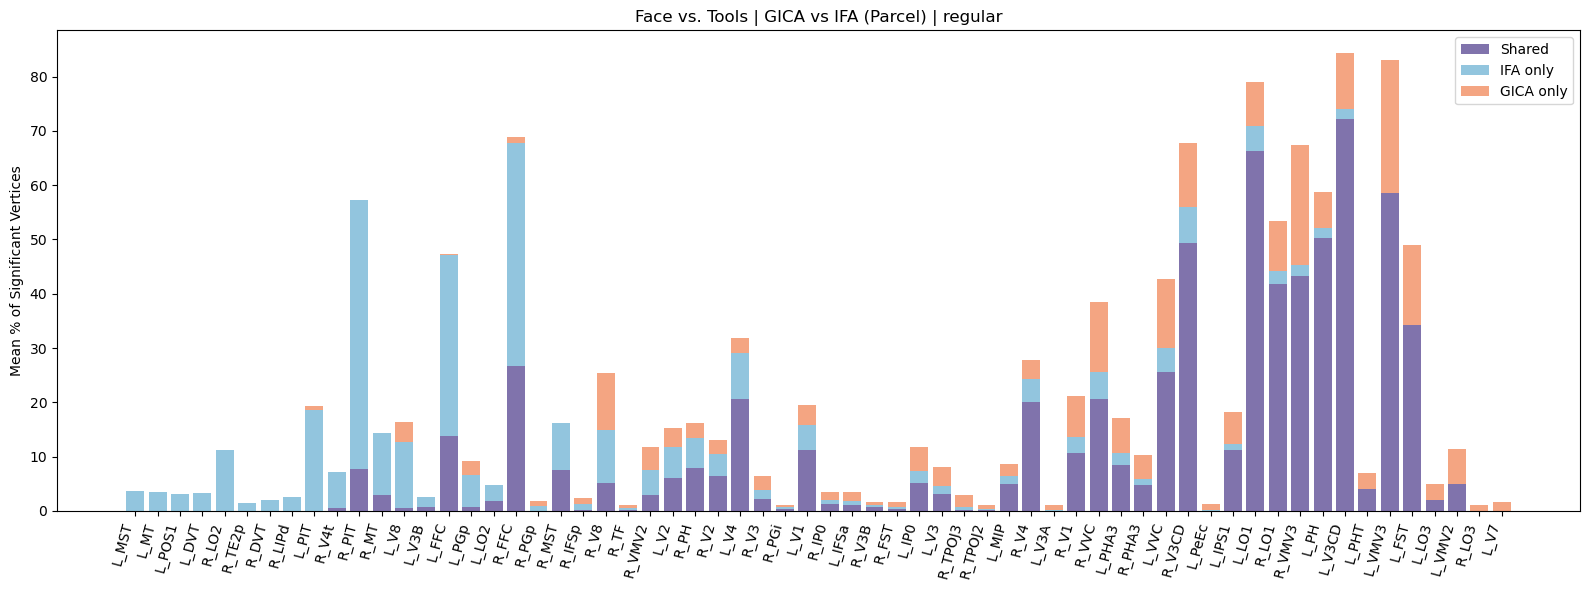

✅ Saved: Face_vs._Tools__GICA_vs_IFA_Voxel__regular.csv


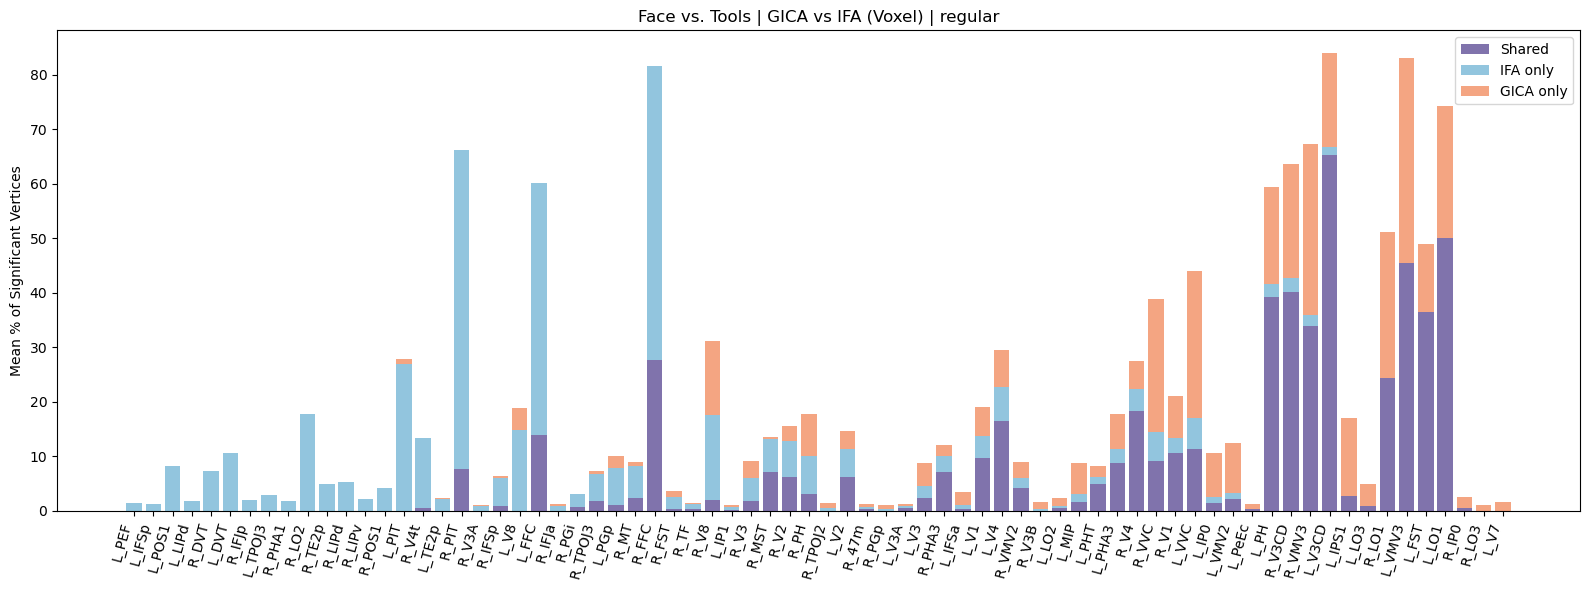

✅ Saved: Face_vs._Tools__GICA_vs_IFA_Parcel__discrim.csv


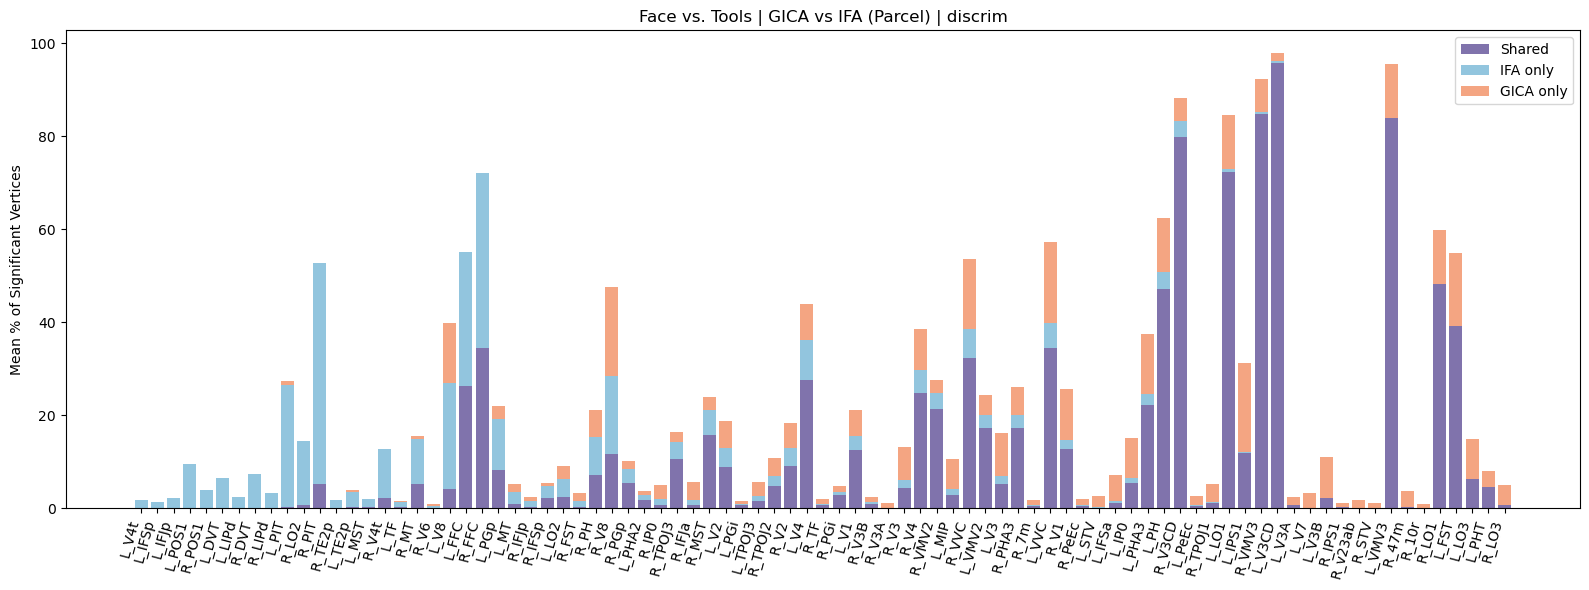

✅ Saved: Face_vs._Tools__GICA_vs_IFA_Voxel__discrim.csv


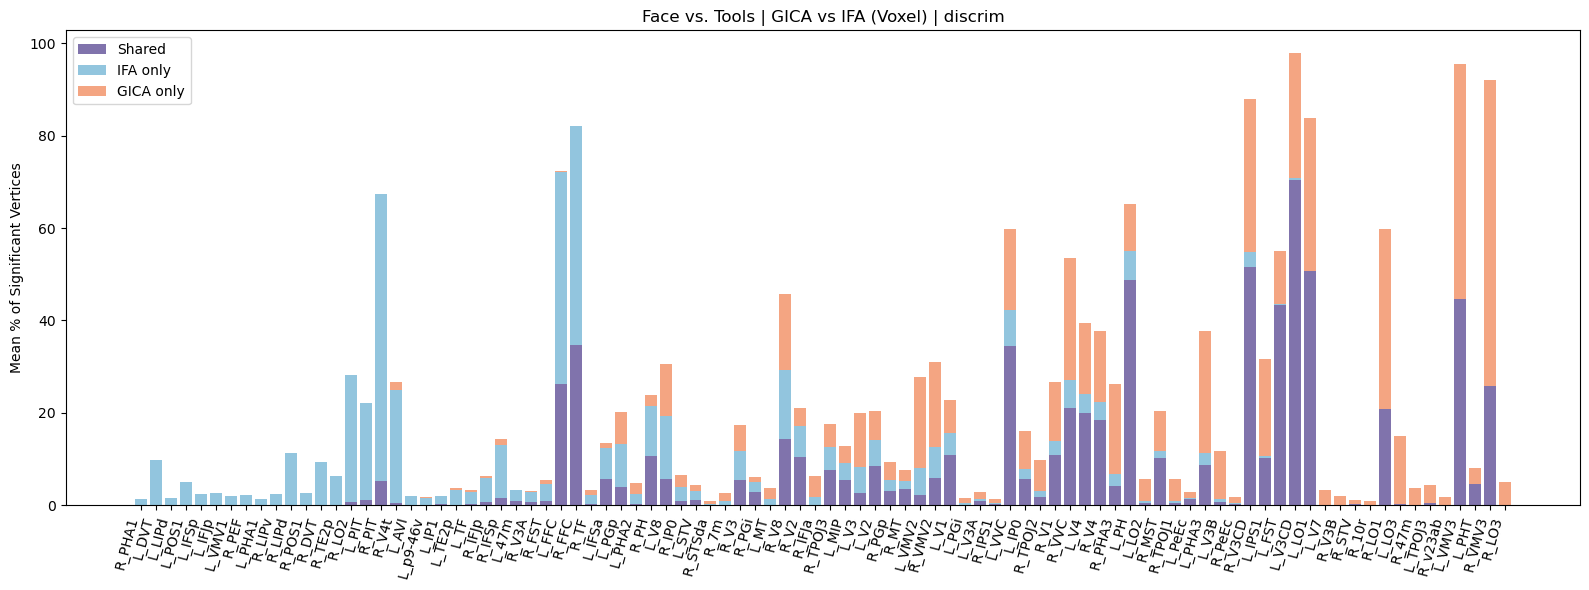

✅ Saved: Relational__GICA_vs_IFA_Parcel__regular.csv


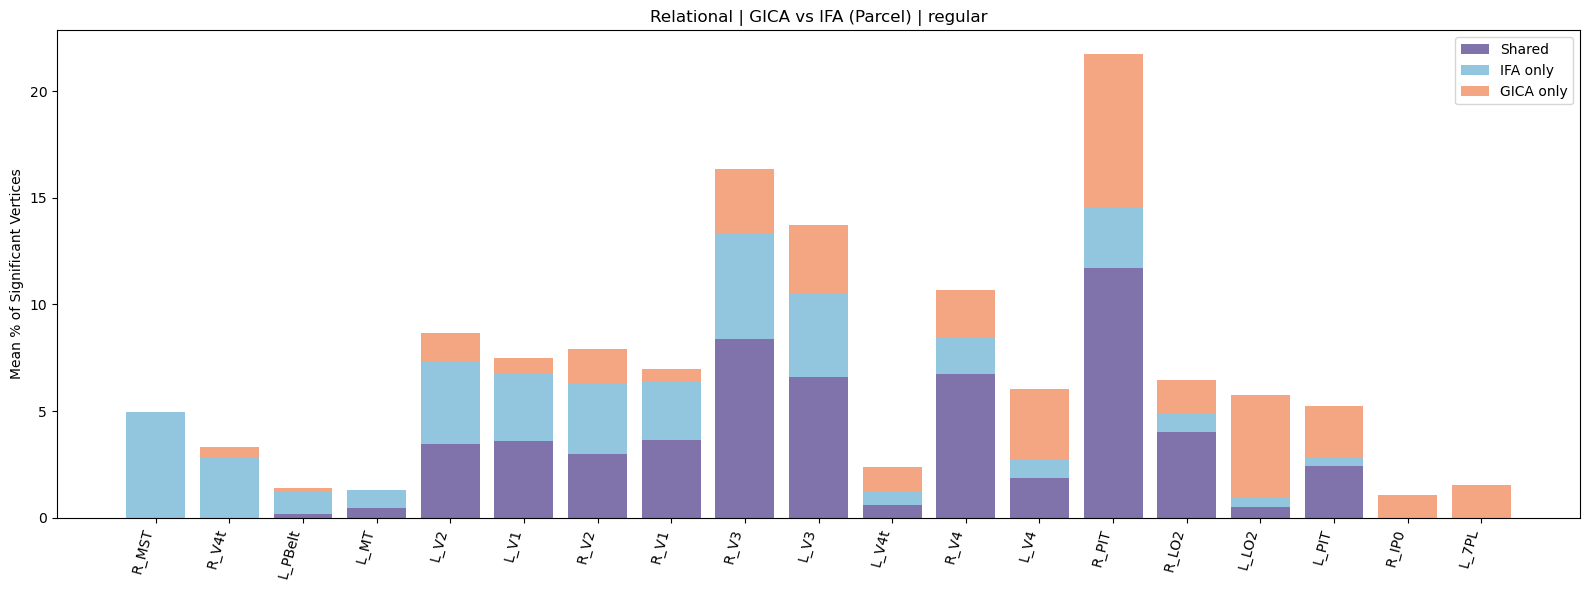

✅ Saved: Relational__GICA_vs_IFA_Voxel__regular.csv


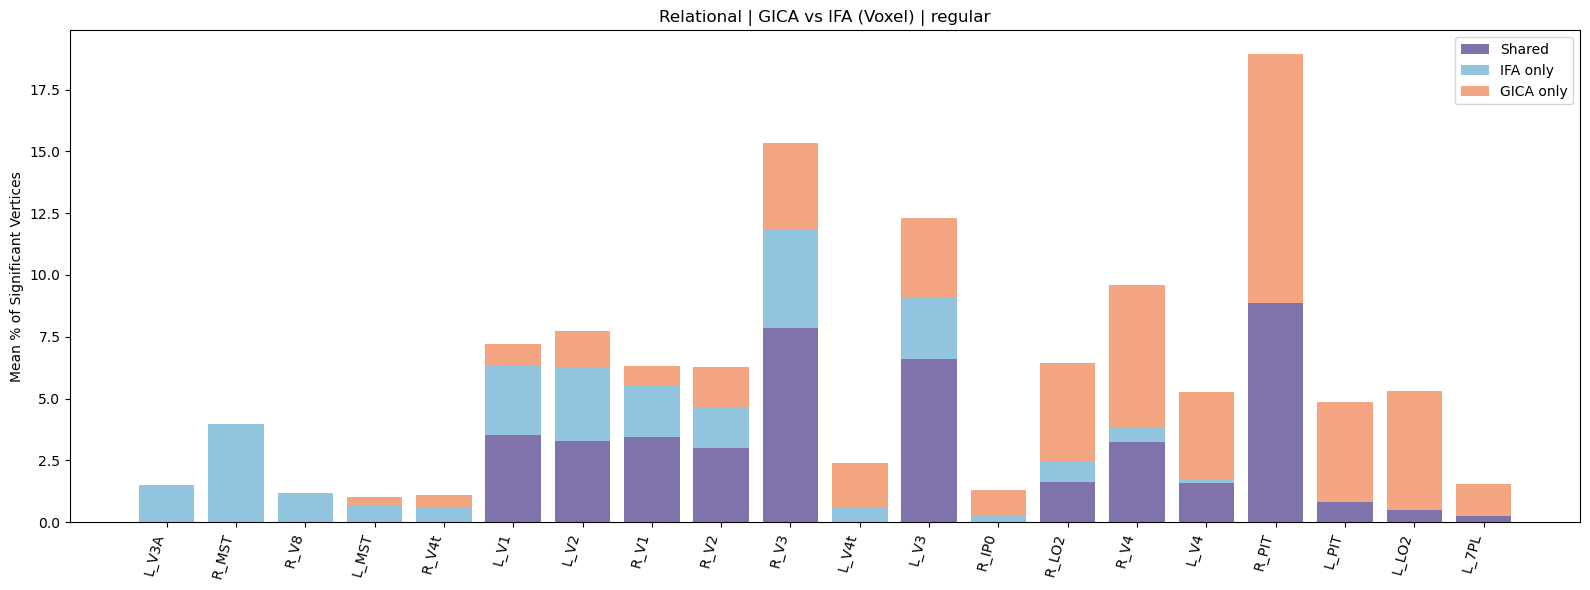

✅ Saved: Relational__GICA_vs_IFA_Parcel__discrim.csv


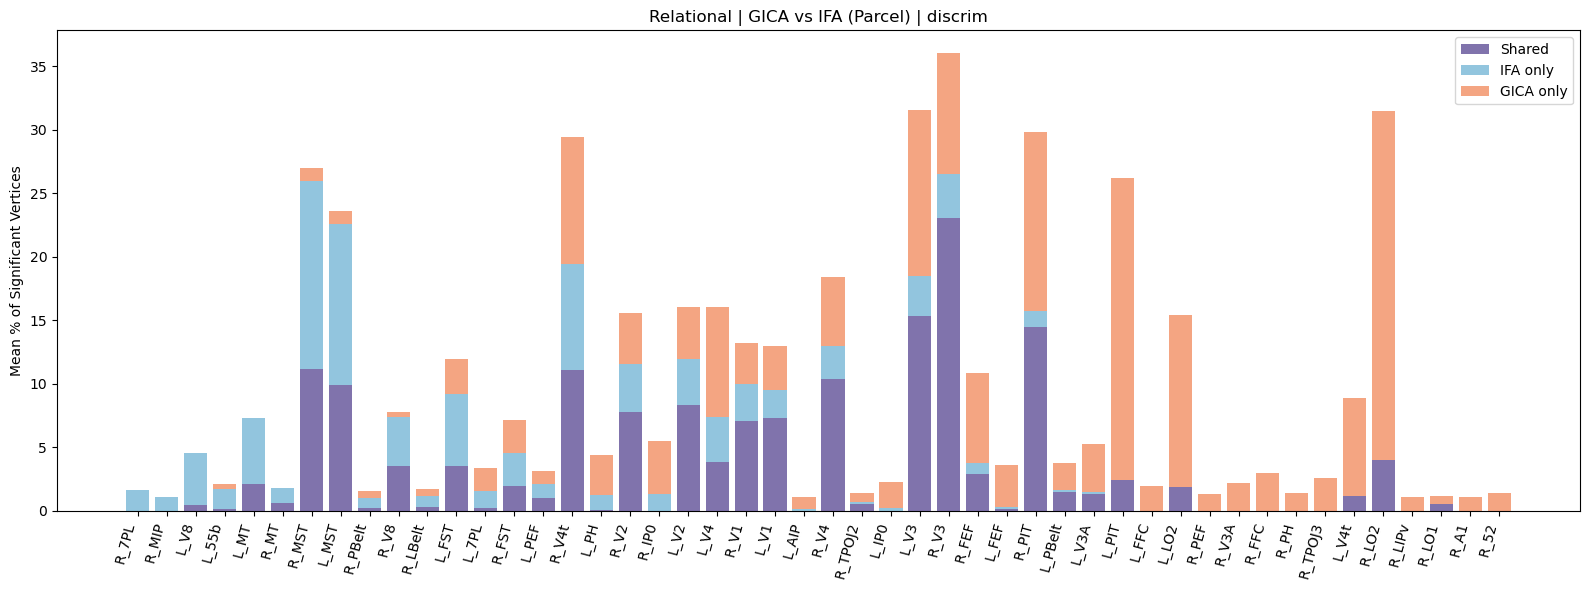

✅ Saved: Relational__GICA_vs_IFA_Voxel__discrim.csv


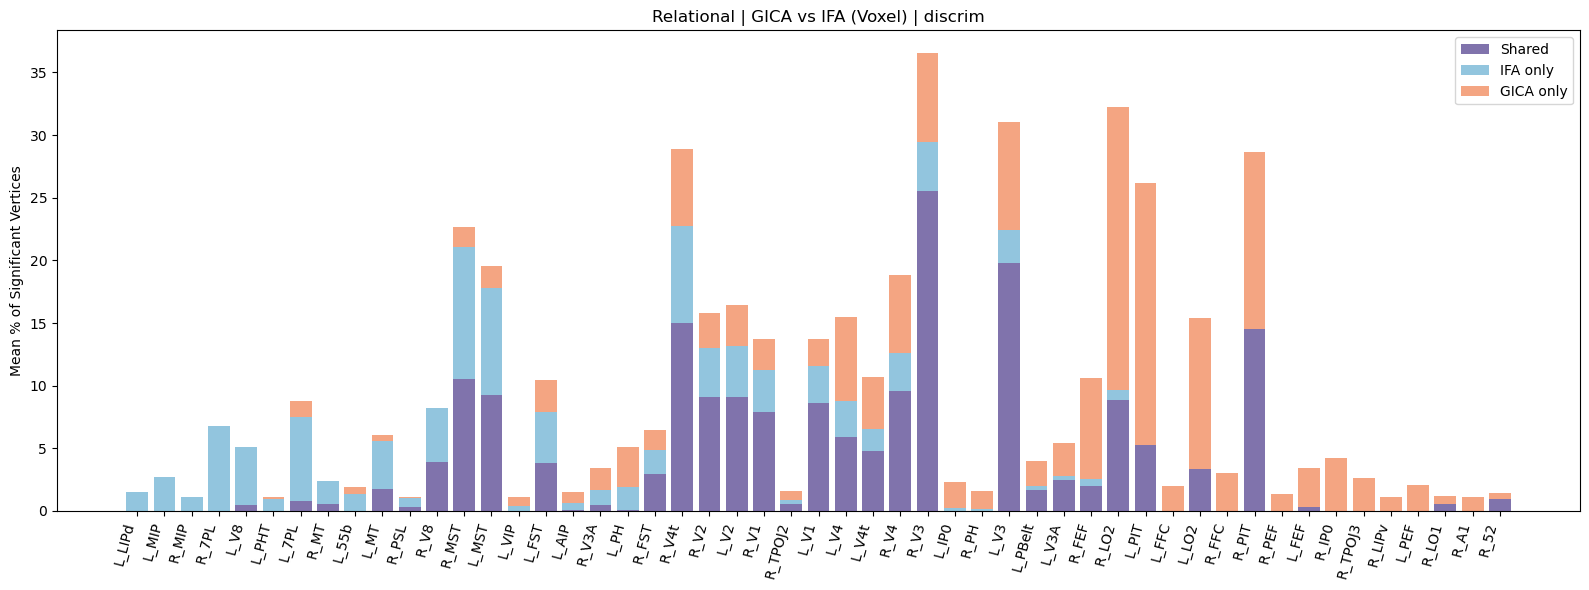

✅ Saved: Incentive__GICA_vs_IFA_Parcel__regular.csv


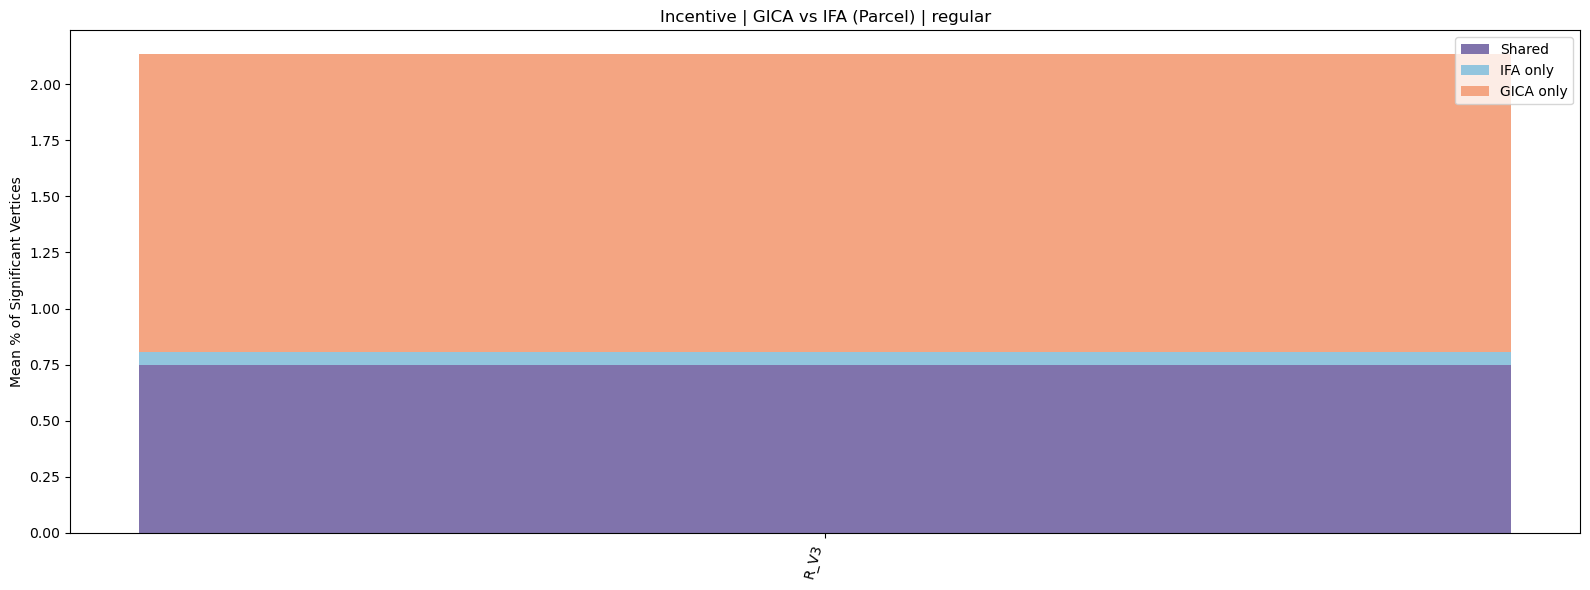

✅ Saved: Incentive__GICA_vs_IFA_Voxel__regular.csv


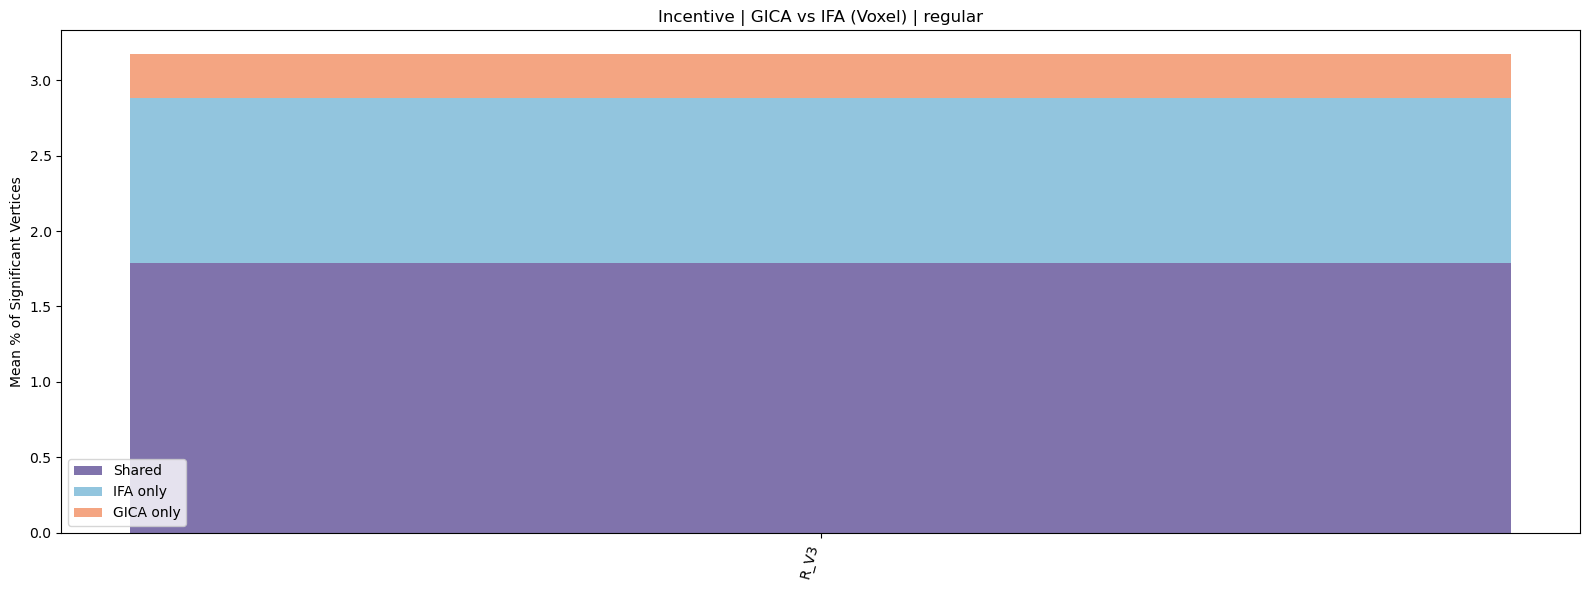

✅ Saved: Incentive__GICA_vs_IFA_Parcel__discrim.csv


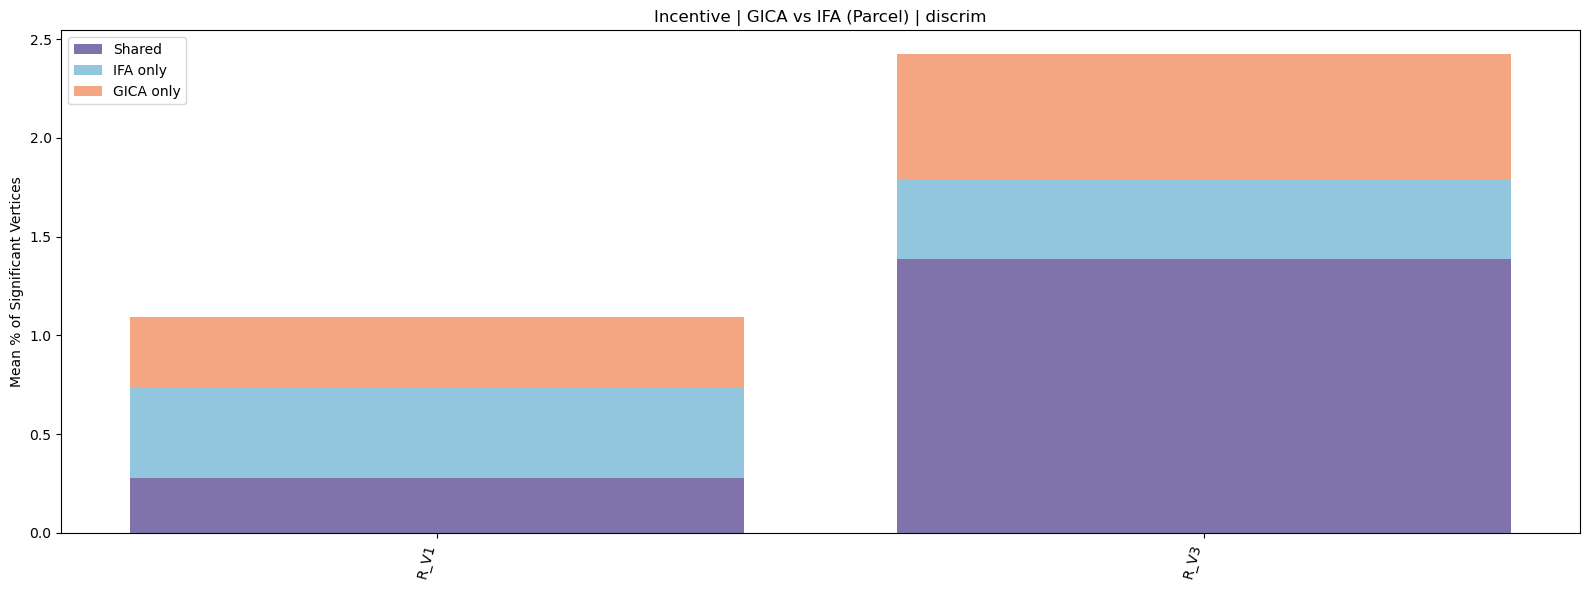

✅ Saved: Incentive__GICA_vs_IFA_Voxel__discrim.csv


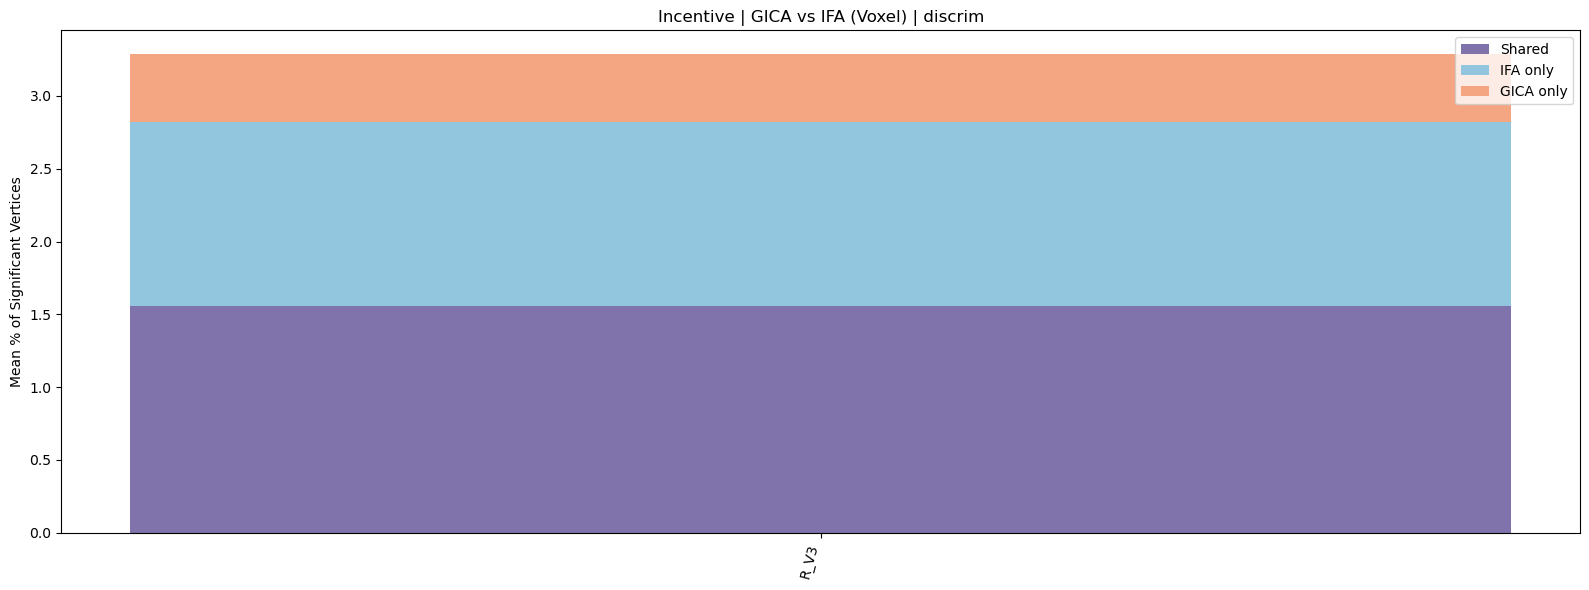

In [174]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv(os.path.join(output_dir_spatial_t, "ifa_gica_overlap_summary.csv"))

# Extract the unique keys
unique_keys = df[["condition", "comparison", "type", "parcel_id", "label"]].drop_duplicates()

# Aggregate across folds
rows = []
for _, key in unique_keys.iterrows():
    mask = (
        (df["condition"] == key["condition"]) &
        (df["comparison"] == key["comparison"]) &
        (df["type"] == key["type"]) &
        (df["parcel_id"] == key["parcel_id"])
    )
    sub = df[mask]

    denom = 4 if ("Relation" in key["condition"] or "Face" in key["condition"]) else 5

    mean_A = sub["pct_A_only"].sum() / denom
    mean_B = sub["pct_B_only"].sum() / denom
    mean_S = sub["pct_shared"].sum() / denom

    std_A = np.sqrt(((sub["pct_A_only"] - mean_A) ** 2).sum() / denom)
    std_B = np.sqrt(((sub["pct_B_only"] - mean_B) ** 2).sum() / denom)
    std_S = np.sqrt(((sub["pct_shared"] - mean_S) ** 2).sum() / denom)

    rows.append({
        "condition": key["condition"],
        "comparison": key["comparison"],
        "type": key["type"],
        "parcel_id": key["parcel_id"],
        "label": key["label"],
        "mean_pct_A_only": mean_A,
        "std_pct_A_only": std_A,
        "mean_pct_B_only": mean_B,
        "std_pct_B_only": std_B,
        "mean_pct_shared": mean_S,
        "std_pct_shared": std_S,
    })

# Create summary DataFrame and save
summary_df = pd.DataFrame(rows)
summary_df.to_csv(os.path.join(output_dir_spatial_t, "ifa_gica_overlap_summary_by_parcel.csv"), index=False)

# Generate per-condition stacked bar plots
unique_keys_sheet = summary_df[["condition", "comparison", "type"]].drop_duplicates()

for _, key in unique_keys_sheet.iterrows():
    mask = (
        (summary_df["condition"] == key["condition"]) &
        (summary_df["comparison"] == key["comparison"]) &
        (summary_df["type"] == key["type"])
    )
    sub_df = summary_df[mask].copy()

    # Add total signal column
    sub_df["Total_Discriminant_Signal_Pct"] = (
        sub_df["mean_pct_A_only"] +
        sub_df["mean_pct_B_only"] +
        sub_df["mean_pct_shared"]
    )

    # Add total signal column
    sub_df["Method_B_Unique_Contribution_Ratio"] = (
        sub_df["mean_pct_B_only"]/
        sub_df["Total_Discriminant_Signal_Pct"]
    )
    
    sub_df["Method_A_Unique_Contribution_Ratio"] = (
        sub_df["mean_pct_A_only"]/
        sub_df["Total_Discriminant_Signal_Pct"]
    )

    sub_df["Method_A_Total_Attribution_Ratio"] = (
        1-sub_df["Method_B_Unique_Contribution_Ratio"]
    )
    sub_df["Method_B_Total_Attribution_Ratio"] = (
        1-sub_df["Method_A_Unique_Contribution_Ratio"]
    )

    epsilon = .01  # or 1e-8 depending on precision

    sub_df["Fully_Method_A"] = sub_df["Method_A_Unique_Contribution_Ratio"] >= 1 - epsilon
    sub_df["Fully_Method_B"] = sub_df["Method_B_Unique_Contribution_Ratio"] >= 1 - epsilon


    # Save filtered CSV
    # Clean filename
    safe_condition = key["condition"].replace(" ", "_")
    safe_comparison = key["comparison"].replace(" ", "_").replace("(", "").replace(")", "")
    safe_type = key["type"].replace(" ", "_")
    filename = f"{safe_condition}__{safe_comparison}__{safe_type}.csv"
    sub_df.to_csv(os.path.join(output_dir_spatial_t, filename), index=False)
    print(f"✅ Saved: {filename}")

    # Threshold to only keep active parcels
    threshold = 1
    sub_df = sub_df[sub_df["Total_Discriminant_Signal_Pct"] > threshold]

    # Sort by GICA-only signal
    sub_df = sub_df.sort_values("Method_B_Unique_Contribution_Ratio", ascending=False)

    # Plot stacked bars
    plt.figure(figsize=(16, 6))
    plt.bar(sub_df["label"], sub_df["mean_pct_shared"], label="Shared", color="#8073ac")
    plt.bar(sub_df["label"], sub_df["mean_pct_B_only"],
            bottom=sub_df["mean_pct_shared"], label="IFA only", color="#92c5de")
    plt.bar(sub_df["label"], sub_df["mean_pct_A_only"],
            bottom=sub_df["mean_pct_shared"] + sub_df["mean_pct_B_only"], label="GICA only", color="#f4a582")

    plt.xticks(rotation=75, ha="right")
    plt.ylabel("Mean % of Significant Vertices")
    plt.title(f"{key['condition']} | {key['comparison']} | {key['type']}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir_spatial_t, filename.replace(".csv", ".png")), dpi=300)
    plt.show()

In [154]:
# Access full label names
mmp_labels = hcp.mmp.labels  # This is a dictionary {region_id: region_name}

# Convert to a pandas DataFrame for easier viewing
mmp_labels_df = pd.DataFrame({
    'id': list(mmp_labels.keys()),
    'name': list(mmp_labels.values())
})

# Optional: sort by ID
mmp_labels_df = mmp_labels_df.sort_values(by='id').reset_index(drop=True)

# Display the table
print(mmp_labels_df)


      id                name
0      0                    
1      1                L_V1
2      2               L_MST
3      3                L_V6
4      4                L_V2
5      5                L_V3
6      6                L_V4
7      7                L_V8
8      8                 L_4
9      9                L_3b
10    10               L_FEF
11    11               L_PEF
12    12               L_55b
13    13               L_V3A
14    14               L_RSC
15    15              L_POS2
16    16                L_V7
17    17              L_IPS1
18    18               L_FFC
19    19               L_V3B
20    20               L_LO1
21    21               L_LO2
22    22               L_PIT
23    23                L_MT
24    24                L_A1
25    25               L_PSL
26    26               L_SFL
27    27               L_PCV
28    28               L_STV
29    29               L_7Pm
30    30                L_7m
31    31              L_POS1
32    32               L_23d
33    33      

Processing condition: /project/3022057.01/simulated_test
  Processing pipeline: GICA
  Processing pipeline: parcel_IFA
  Processing pipeline: parcel_IFA
Processing condition: /project/3022057.01/tools_v_faces_final
  Processing pipeline: GICA
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/GICA/Normalized/results.pkl
  Processing pipeline: parcel_IFA
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/parcel_IFA/Normalized/results.pkl
  Processing pipeline: voxel_IFA
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/voxel_IFA/Normalized/results.pkl
Processing condition: /project/3022057.01/relation_final_s05
  Processing pipeline: GICA
Missing: /project/3022057.01/relation_final_s05/fold_3/nPCA_8/Results/GICA/Normalized/results.pkl
  Processing pipeline: parcel_IFA
Missing: /project/3022057.01/relation_final_s05/fold_3/nPCA_8/Results/parcel_IFA/Normalized/results.pkl
  Processing pipeline: voxel_IFA
Missing: /project/302205

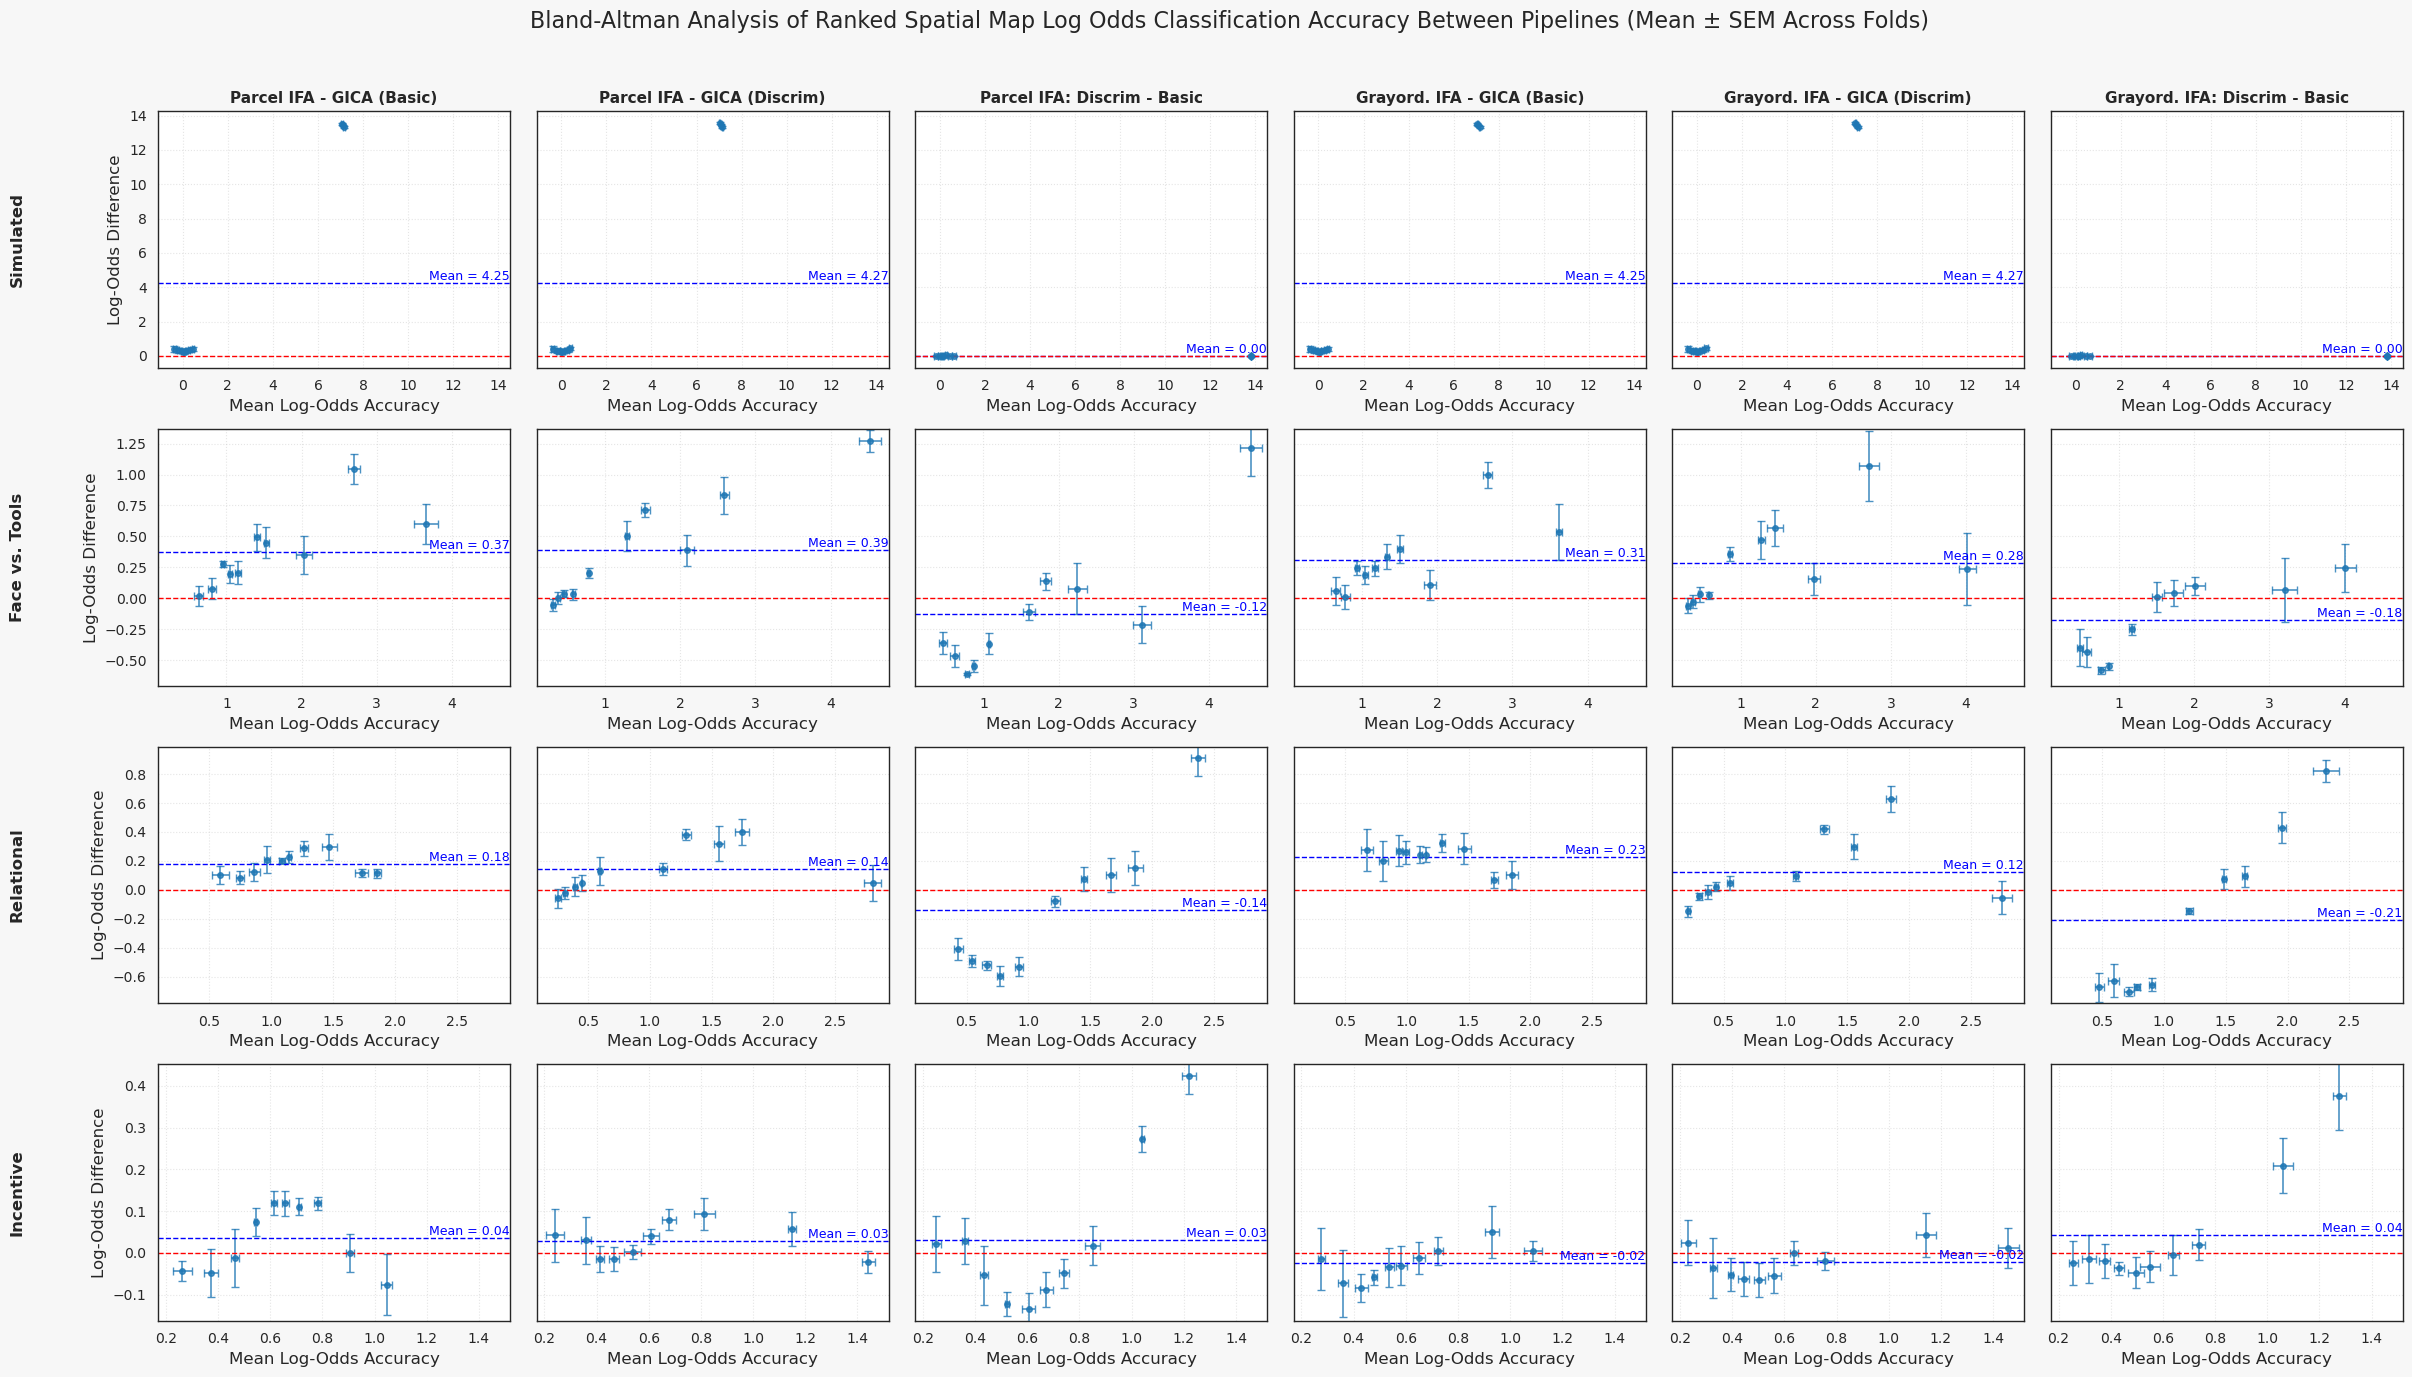

Saved figure as: ifa_bland_altman_log_odds.svg


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit
from pathlib import Path
import pickle
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
})

def bland_altman_data_with_sem(acc_baseline_folds, acc_method_folds, mode="raw"):
    mode = mode.lower()
    acc1 = np.array(acc_baseline_folds)
    acc2 = np.array(acc_method_folds)
    n_folds = acc1.shape[0]
    
    if mode == "log_odds":
        eps = 1e-6
        base = np.clip(acc1, eps, 1 - eps)
        meth = np.clip(acc2, eps, 1 - eps)
        base_trans = np.log(base / (1 - base))
        meth_trans = np.log(meth / (1 - meth))
        fold_means = (base_trans + meth_trans) / 2
        fold_diffs = meth_trans - base_trans
        xlabel = "Mean Log-Odds Accuracy"
        ylabel = "Log-Odds Difference"
    elif mode == "raw":
        base = acc1 * 100
        meth = acc2 * 100
        fold_means = (base + meth) / 2
        fold_diffs = meth - base
        xlabel = "Mean Accuracy (%)"
        ylabel = "Difference (Percentage Points)"
    elif mode == "sym_diff":
        fold_diffs = 200 * (acc2 - acc1) / (acc2 + acc1)
        fold_means = 100 * (acc1 + acc2) / 2
        xlabel = "Mean Accuracy (%)"
        ylabel = "Symmetric Relative Difference (%)"
    elif mode == "sym_error":
        e_baseline = 1 - acc1
        e_method = 1 - acc2
        fold_diffs = 200 * (e_method - e_baseline) / (e_method + e_baseline)
        fold_means = 100 * (e_baseline + e_method) / 2
        xlabel = "Mean Error Rate (%)"
        ylabel = "Symmetric Relative Error Difference (%)"
    else:
        raise ValueError("Invalid mode.")

    mean_vals_mean = np.mean(fold_means, axis=0)
    diff_mean = np.mean(fold_diffs, axis=0)
    mean_vals_sem = np.std(fold_means, axis=0, ddof=1) / np.sqrt(n_folds)
    diff_sem = np.std(fold_diffs, axis=0, ddof=1) / np.sqrt(n_folds)
    
    return mean_vals_mean, mean_vals_sem, diff_mean, diff_sem, xlabel, ylabel

# Configuration
share_axes = False  # Set to True for global x and y limits with shared axes.
mode = "log_odds"

pipelines = ["GICA", "parcel_IFA", "voxel_IFA"]
pipeline_labels = ["GICA", "IFA (Parcellated)", "IFA (Grayordinate)"]
condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
"/project/3022057.01/simulated_test",
"/project/3022057.01/tools_v_faces_final",
"/project/3022057.01/relation_final_s05",
"/project/3022057.01/Gamble_final",
]
folds = [0,1,2,3,4]
nPCA = 8
n_conditions = len(condition_paths)
n_cols = 6

# Create subplots with shared axes if the flag is set.
if share_axes:
    fig, axs = plt.subplots(n_conditions, n_cols, sharex=True, sharey=True,
                            figsize=(4 * n_cols, 3.5 * n_conditions), squeeze=False)
else:
    fig, axs = plt.subplots(n_conditions, n_cols,
                            figsize=(4 * n_cols, 3.5 * n_conditions), squeeze=False)

# Global lists used when share_axes is True.
global_means_list = []
global_diffs_list = []

for i, outputfolder in enumerate(condition_paths):
    print("Processing condition:", outputfolder)
    methods = []
    for pipe in pipelines:
        map_acc = []
        discrim_map_acc = []
        if outputfolder == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
            pipe = "parcel_IFA"
        print("  Processing pipeline:", pipe)
        for fold in folds:
            baseline_file = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results" / pipe / "Normalized" / "results.pkl"
            if not baseline_file.exists():
                    print(f"Missing: {baseline_file}")
                    continue
            with open(baseline_file, "rb") as f:
                baseline_data = pickle.load(f)
            map_acc.append(np.sort([class_acc['SVM (C=0.1)']['accuracy'] 
                                     for class_acc in baseline_data["Spatial_discrim"][0]]))
            discrim_map_acc.append(np.sort([class_acc['SVM (C=0.1)']['accuracy'] 
                                             for class_acc in baseline_data["Spatial_discrim"][1][2]]))
        methods.append((map_acc, discrim_map_acc))

    comparisons = [
       (methods[0][0], methods[1][0], "Parcel IFA - GICA (Basic)"),
       (methods[0][1], methods[1][1], "Parcel IFA - GICA (Discrim)"),
       (methods[1][0], methods[1][1], "Parcel IFA: Discrim - Basic"),
       (methods[0][0], methods[2][0], "Grayord. IFA - GICA (Basic)"),
       (methods[0][1], methods[2][1], "Grayord. IFA - GICA (Discrim)"),
       (methods[2][0], methods[2][1], "Grayord. IFA: Discrim - Basic")
    ]

    comp_data = []
    row_means = []
    row_diffs = []

    for acc1_folds, acc2_folds, title in comparisons:
        mean_vals_mean, mean_vals_sem, diff_mean, diff_sem, xlabel, ylabel = bland_altman_data_with_sem(acc1_folds, acc2_folds, mode=mode)
        comp_data.append({
            "mean": mean_vals_mean,
            "mean_err": mean_vals_sem,
            "diff": diff_mean,
            "diff_err": diff_sem,
            "title": title,
            "xlabel": xlabel,
            "ylabel": ylabel
        })
        row_means.append(mean_vals_mean)
        row_diffs.append(diff_mean)
        if share_axes:
            global_means_list.append(mean_vals_mean)
            global_diffs_list.append(diff_mean)

    # For non-shared axes, compute per-row x and y limits.
    if not share_axes:
        all_means = np.concatenate(row_means)
        all_diffs = np.concatenate(row_diffs)
        margin_x = 0.05 * np.ptp(all_means) if np.ptp(all_means) != 0 else 0.1
        margin_y = 0.05 * np.ptp(all_diffs) if np.ptp(all_diffs) != 0 else 0.1
        row_xlim = (np.min(all_means) - margin_x, np.max(all_means) + margin_x)
        row_ylim = (np.min(all_diffs) - margin_y, np.max(all_diffs) + margin_y)

    for j, data in enumerate(comp_data):
        ax = axs[i, j]
        ax.errorbar(data["mean"], data["diff"], 
                    xerr=data["mean_err"], yerr=data["diff_err"],
                    fmt='o', markersize=4, alpha=0.8, capsize=3)
        
        # For non-shared axes, set limits first so the "Mean" label is correctly placed.
        if not share_axes:
            ax.set_xlim(row_xlim)
            ax.set_ylim(row_ylim)
        
        overall_mean_diff = np.mean(data["diff"])
        ax.axhline(overall_mean_diff, color='blue', linestyle='--', linewidth=1)
        ax.axhline(0, color='red', linestyle='--', linewidth=1)
        
        # Use the updated limits to position the text.
        xlim = ax.get_xlim()
        ax.text(xlim[1], overall_mean_diff, f"Mean = {overall_mean_diff:.2f}",
                ha='right', va='bottom', color='blue', fontsize=9)
        ax.grid(True, linestyle=':', alpha=0.5)

        # Set xlabel always.
        ax.set_xlabel(data["xlabel"])
        
        # Set y-axis labels: If not sharing, follow original behavior; if sharing, leave all y tick labels visible.
        if not share_axes:
            if j == 0:
                ax.set_ylabel(data["ylabel"])
                ax.text(-0.4, 0.5, condition_labels[i],
                        transform=ax.transAxes,
                        rotation=90, fontsize=12,
                        va='center', ha='center', fontweight='bold')
            else:
                ax.set_yticklabels([])
        else:
            # When sharing, set the left column's axis label and condition text
            if j == 0:
                ax.set_ylabel(data["ylabel"])
                ax.text(-0.4, 0.5, condition_labels[i],
                        transform=ax.transAxes,
                        rotation=90, fontsize=12,
                        va='center', ha='center', fontweight='bold')
            # Do not clear y tick labels in other columns
       
        # Set title only on top row.
        if i == 0:
            ax.set_title(data["title"], fontsize=11, fontweight='bold')

# For shared axes mode, compute the global x and y limits and update all axes.
if share_axes and global_means_list and global_diffs_list:
    global_all_means = np.concatenate(global_means_list)
    global_all_diffs = np.concatenate(global_diffs_list)
    margin_x_global = 0.05 * np.ptp(global_all_means) if np.ptp(global_all_means) != 0 else 0.1
    margin_y_global = 0.05 * np.ptp(global_all_diffs) if np.ptp(global_all_diffs) != 0 else 0.1
    global_xlim = (np.min(global_all_means) - margin_x_global, np.max(global_all_means) + margin_x_global)
    global_ylim = (np.min(global_all_diffs) - margin_y_global, np.max(global_all_diffs) + margin_y_global)
    for ax in axs.flat:
        ax.set_xlim(global_xlim)
        ax.set_ylim(global_ylim)

fig.suptitle(f"Bland-Altman Analysis of Ranked Spatial Map {mode.replace('_', ' ').title()} Classification Accuracy Between Pipelines (Mean ± SEM Across Folds)", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
filename = f"ifa_bland_altman_{mode}.svg"
fig.savefig(filename, format="svg", bbox_inches="tight")
print(f"Saved figure as: {filename}")

In [7]:
nPCA = 8
# pipelines = ["GICA", "parcel_IFA", "voxel_IFA"]
folders = ["GICA", "parcel_IFA", "voxel_IFA"]
pipeline_labels = ["GICA", "IFA (Parcellated)", "IFA (Grayordinate)"]
condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
"/project/3022057.01/simulated_test",
"/project/3022057.01/tools_v_faces_final",
"/project/3022057.01/relation_final_s05",
"/project/3022057.01/Gamble_final",
]
folds = [0,1,2,3,4]

for outputfolder in condition_paths:
    print(outputfolder)
    for folder in folders:
        scores = []
        significant_connections = []
        possible = []
        if outputfolder == "/project/3022057.01/simulated_test" and folder == "voxel_IFA":
            folder = "parcel_IFA"
        for fold in folds:
            baseline_file = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}"/f"Results" /f"{folder}"/f"Unnormalized"/f"results.pkl"
            if not baseline_file.exists():
                print(f"Missing: {baseline_file}")
                continue
            with open(baseline_file, "rb") as f:
                baseline_data = pickle.load(f)
            
            t_matrix = (baseline_data["t_test"][1])
            n = t_matrix.shape[0]
            triu_with_diag = np.triu(np.ones((n, n)), k=0)  # includes diagonal
            num_sig = np.sum((np.abs(t_matrix) > 0) & (triu_with_diag == 1))
            total_possible = np.sum(triu_with_diag)
            
            possible.append(total_possible)
            significant_connections.append(num_sig)
            scores.append(baseline_data["Class_Result"]['SVM (C=0.1)']["accuracy"])

        print("----------------",folder,"----------------")
        print(f"Tangent Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
        print(f"Number of Connections: {np.mean(significant_connections):.4f} ± {np.std(significant_connections):.4f}")
        print(f"Total Possible Number of Connections: {np.mean(possible):.4f} ± {np.std(possible):.4f}")
        print()


/project/3022057.01/simulated_test
---------------- GICA ----------------
Tangent Accuracy: 0.4900 ± 0.0561
Number of Connections: 0.0000 ± 0.0000
Total Possible Number of Connections: 55.0000 ± 0.0000

---------------- parcel_IFA ----------------
Tangent Accuracy: 1.0000 ± 0.0000
Number of Connections: 21.6000 ± 1.3565
Total Possible Number of Connections: 55.0000 ± 0.0000

---------------- parcel_IFA ----------------
Tangent Accuracy: 1.0000 ± 0.0000
Number of Connections: 21.6000 ± 1.3565
Total Possible Number of Connections: 55.0000 ± 0.0000

/project/3022057.01/tools_v_faces_final
Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/GICA/Unnormalized/results.pkl
---------------- GICA ----------------
Tangent Accuracy: 0.8364 ± 0.0066
Number of Connections: 12.0000 ± 1.2247
Total Possible Number of Connections: 55.0000 ± 0.0000

Missing: /project/3022057.01/tools_v_faces_final/fold_1/nPCA_8/Results/parcel_IFA/Unnormalized/results.pkl
---------------- parcel_IFA --

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Set publication style with a slightly off-white overall background
sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Use a softer off-white for the overall figure background
mpl.rcParams['figure.facecolor'] = '#f7f7f7'
mpl.rcParams['axes.facecolor'] = 'white'

# Pipeline and condition setup
pipelines = ["GICA", "parcel_IFA", "voxel_IFA"]
# pipelines = ["GICA", "parcel_IFA"]
pipeline_labels = ["GICA", "IFA (Parcellated)", "IFA (Grayordinate)"]
# pipeline_labels = ["GICA", "IFA (Parcellated)"]

condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
"/project/3022057.01/simulated_test",
"/project/3022057.01/tools_v_faces_final",
"/project/3022057.01/relation_final_s05",
"/project/3022057.01/Gamble_final",
]

fold = 2
nPCA = 8
tval_mats = {}

# Load matrices
for pipe in pipelines:
    for cond_path in condition_paths:
        if cond_path == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
            pipe = "parcel_IFA"
        baseline_file = Path(cond_path) / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results" / pipe / "Unnormalized" / "results.pkl"
        with open(baseline_file, "rb") as f:
            baseline_data = pickle.load(f)
        tval_mats[(pipe, cond_path)] = baseline_data["t_test"][1]

# Determine color scaling based on 99th percentile of absolute values
all_vals = np.concatenate([np.abs(mat.flatten()) for mat in tval_mats.values()])
vlim = np.nanpercentile(all_vals, 99)

# Define custom diverging colormap with a richer blue and red
colors = [(0, '#2c7bb6'), (0.5, 'white'), (1, '#d7191c')]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Setup tick labels
n_connections = list(tval_mats.values())[0].shape[0]
tick_labels = [str(i) for i in range(n_connections)]

# Create the overall figure with GridSpec
fig = plt.figure(figsize=(20, 13))
outer = fig.add_gridspec(
    nrows=len(pipelines) + 1,
    ncols=len(condition_paths),
    height_ratios=[0.15] + [1] * len(pipelines),
    hspace=0.35,
    wspace=0.1
)

# Plot condition labels in the top row (text-only panels)
for j, cond_label in enumerate(condition_labels):
    ax_label = fig.add_subplot(outer[0, j])
    ax_label.axis("off")
    ax_label.text(0.5, 0.5, cond_label,
                  fontsize=12, ha="center", va="center", fontweight="bold")

# Plot the heatmaps for each pipeline and condition
for i, (pipe, pipe_label) in enumerate(zip(pipelines, pipeline_labels)):
    for j, cond_path in enumerate(condition_paths):
        if cond_path == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
            pipe = "parcel_IFA"
        mat = tval_mats[(pipe, cond_path)]
        ax = fig.add_subplot(outer[i + 1, j])
        
        # Create heatmap with gridlines for a defined cell border appearance
        sns.heatmap(
            mat,
            cmap=custom_cmap,
            center=0,
            vmin=-vlim,
            vmax=vlim,
            square=True,
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            linewidths=0.5,    # Thicker gridlines for better definition
            linecolor='lightgray',
            cbar=False,
            ax=ax
        )
        
        # Ensure the x-axis ticks and bottom spine are visible
        ax.tick_params(axis='x', labelsize=8, rotation=90, bottom=True)
        ax.xaxis.set_visible(True)
        ax.xaxis.set_tick_params(bottom=True)
        if 'bottom' in ax.spines:
            ax.spines['bottom'].set_visible(True)
            
        # Ensure the y-axis ticks and left spine are visible
        ax.tick_params(axis='y', labelsize=8, left=True)
        ax.yaxis.set_visible(True)
        ax.yaxis.set_tick_params(left=True)
        if 'left' in ax.spines:
            ax.spines['left'].set_visible(True)
        
        # Add y-label only in the leftmost column with bold formatting
        if j == 0:
            ax.set_ylabel(pipe_label, fontsize=12, fontweight="bold", labelpad=10)
        
        # Add subplot title with the sum of absolute T-values
        ax.set_title(f"∑|T| = {np.sum(np.abs(mat)):.2f}",
                     fontsize=10, pad=8)

# Add a shared colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.30, 0.015, 0.4])
norm = plt.Normalize(vmin=-vlim, vmax=vlim)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Tangent T-values', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Set the overall figure title
fig.suptitle("Thresholded Tangent T-values (Lower Triangle Only)", fontsize=18, y=0.99)

# Save the figure with high resolution and display it
# plt.savefig("tangent_tvals.svg", dpi=300, bbox_inches='tight')
plt.show()

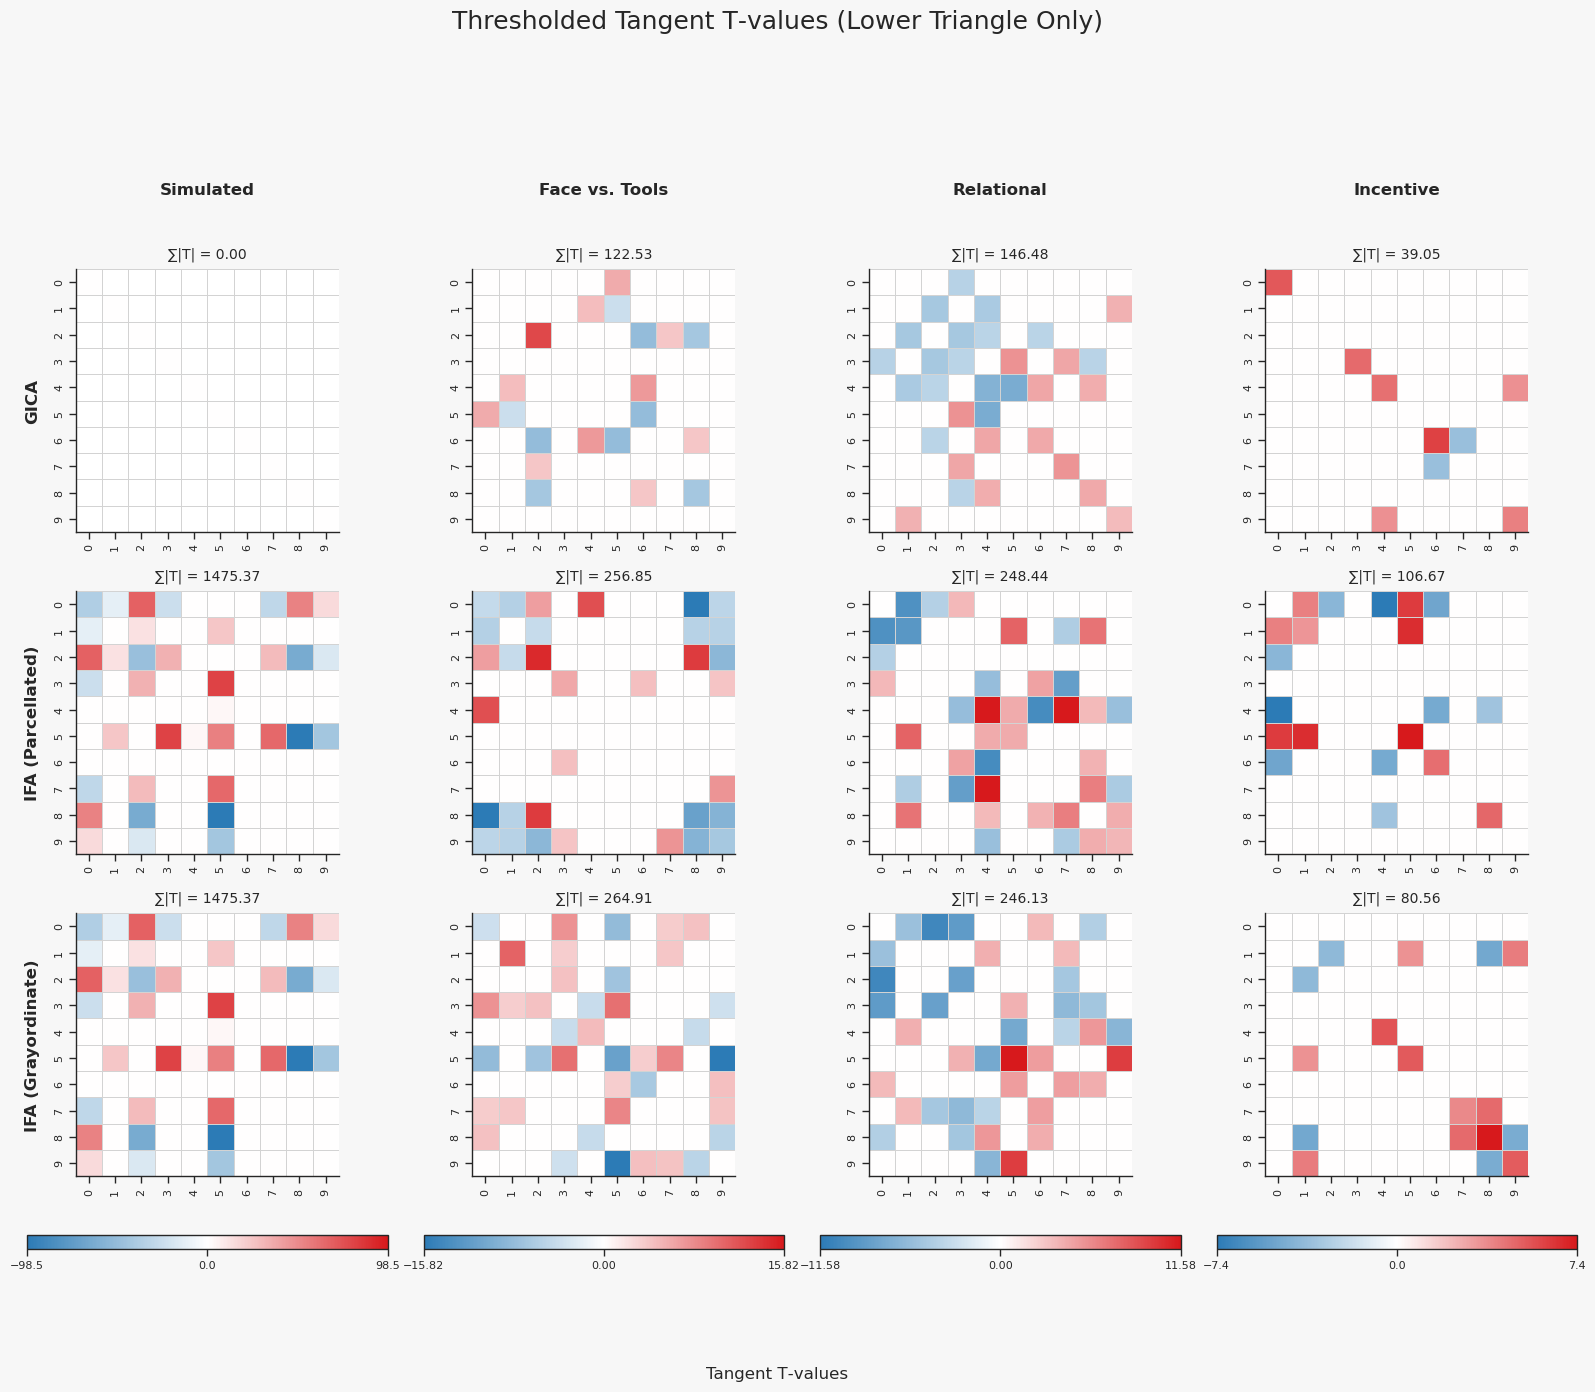

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase
import matplotlib as mpl

# Set publication style with a slightly off-white overall background
sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Use a softer off-white for the overall figure background
mpl.rcParams['figure.facecolor'] = '#f7f7f7'
mpl.rcParams['axes.facecolor'] = 'white'

# Pipeline and condition setup
pipelines = ["GICA", "parcel_IFA", "voxel_IFA"]
pipeline_labels = ["GICA", "IFA (Parcellated)", "IFA (Grayordinate)"]

condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
    "/project/3022057.01/simulated_test",
    "/project/3022057.01/tools_v_faces_final",
    "/project/3022057.01/relation_final_s05",
    "/project/3022057.01/Gamble_final",
]

fold = 2
nPCA = 8
tval_mats = {}

# Load matrices
for pipe in pipelines:
    for cond_path in condition_paths:
        actual_pipe = pipe
        if cond_path == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
            actual_pipe = "parcel_IFA"
        baseline_file = (
            Path(cond_path)
            / f"fold_{fold}"
            / f"nPCA_{nPCA}"
            / "Results"
            / actual_pipe
            / "Unnormalized"
            / "results.pkl"
        )
        with open(baseline_file, "rb") as f:
            baseline_data = pickle.load(f)
        tval_mats[(pipe, cond_path)] = baseline_data["t_test"][1]

# Compute per‐column vlim (99th percentile) across all pipelines in that column
col_vlims = []
for j, cond_path in enumerate(condition_paths):
    mats = [tval_mats[(pipe, cond_path)].flatten() for pipe in pipelines]
    all_vals_j = np.concatenate(mats)
    col_vlims.append(np.nanpercentile(np.abs(all_vals_j), 99))

# Define custom diverging colormap with a richer blue and red
colors = [(0, "#2c7bb6"), (0.5, "white"), (1, "#d7191c")]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Setup tick labels
n_connections = list(tval_mats.values())[0].shape[0]
tick_labels = [str(i) for i in range(n_connections)]

# Create the overall figure with GridSpec
n_rows = 1 + len(pipelines) + 1
height_ratios = [0.15] + [1] * len(pipelines) + [0.05]

fig = plt.figure(figsize=(20, 14))
outer = fig.add_gridspec(
    nrows=n_rows,
    ncols=len(condition_paths),
    height_ratios=height_ratios,
    hspace=0.35,
    wspace=0.1,
)

# Plot condition labels in the top row (text-only panels)
for j, cond_label in enumerate(condition_labels):
    ax_label = fig.add_subplot(outer[0, j])
    ax_label.axis("off")
    ax_label.text(
        0.5,
        0.5,
        cond_label,
        fontsize=12,
        ha="center",
        va="center",
        fontweight="bold",
    )

# Plot the heatmaps for each pipeline and condition
for i, (pipe, pipe_label) in enumerate(zip(pipelines, pipeline_labels)):
    for j, cond_path in enumerate(condition_paths):
        actual_pipe = pipe
        if cond_path == "/project/3022057.01/simulated_test" and pipe == "voxel_IFA":
            actual_pipe = "parcel_IFA"
        mat = tval_mats[(pipe, cond_path)]
        ax = fig.add_subplot(outer[1 + i, j])

        sns.heatmap(
            mat,
            cmap=custom_cmap,
            center=0,
            vmin=-col_vlims[j],
            vmax=col_vlims[j],
            square=True,
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            linewidths=0.5,
            linecolor="lightgray",
            cbar=False,
            ax=ax,
        )

        ax.tick_params(axis="x", labelsize=8, rotation=90, bottom=True)
        if "bottom" in ax.spines:
            ax.spines["bottom"].set_visible(True)

        ax.tick_params(axis="y", labelsize=8, left=True)
        if "left" in ax.spines:
            ax.spines["left"].set_visible(True)

        if j == 0:
            ax.set_ylabel(pipe_label, fontsize=12, fontweight="bold", labelpad=10)

        ax.set_title(f"∑|T| = {np.nansum(np.abs(mat)):.2f}", fontsize=10, pad=8)

# Bottom row: one horizontal colorbar per column
for j in range(len(condition_paths)):
    cb_ax = fig.add_subplot(outer[-1, j])
    norm_j = Normalize(vmin=-col_vlims[j], vmax=col_vlims[j])
    ColorbarBase(
        cb_ax,
        cmap=custom_cmap,
        norm=norm_j,
        orientation="horizontal",
        ticks=[-col_vlims[j], 0, col_vlims[j]],
    )
    cb_ax.xaxis.set_tick_params(labelsize=8)
    cb_ax.spines["top"].set_visible(False)

# Add a single shared label below all the colorbars
fig.text(
    0.5,              # x position: center
    0.02,             # y position: a little above the bottom of the figure
    "Tangent T‑values",
    ha="center",
    va="center",
    fontsize=12,
)

# Overall figure title
fig.suptitle(
    "Thresholded Tangent T‑values (Lower Triangle Only)", fontsize=18, y=0.995
)

# Save as SVG
plt.savefig("tangent_tvals.svg", format="svg", bbox_inches="tight")

# (Optionally) display it as well
plt.show()

In [19]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import cairosvg
import io

# === Setup ===
pipelines = ["GICA", "parcel_IFA", "voxel_IFA"]
pipeline_labels = ["GICA", "IFA (Parcellated)", "IFA (Grayordinate)"]
condition_labels = ["Simulated", "Face vs. Tools", "Relational", "Incentive"]
condition_paths = [
    "simulated_test",
    "tools_v_faces_final",
    "relation_final_s05",
    "Gamble_final",
]

base_path = Path("/project/3022057.01")
fold = 4
nPCA = 8

# === Parameters ===
panel_width_px = 400   # increase for better clarity
panel_height_px = 350
dpi = 150

# === Load and store images ===
images = []
for i, pipe in enumerate(pipelines):
    row = []
    for j, cond in enumerate(condition_paths):
        actual_pipe = "parcel_IFA" if cond == "simulated_test" and pipe == "voxel_IFA" else pipe
        file_path = (
            base_path / cond / f"fold_{fold}" / f"nPCA_{nPCA}" / "Results"
            / actual_pipe / "Unnormalized" / f"{actual_pipe}_Unnormalized_log-var_2d.svg"
        )

        if not file_path.exists():
            row.append(None)
        else:
            with open(file_path, 'rb') as f:
                png = cairosvg.svg2png(bytestring=f.read(), output_width=panel_width_px, output_height=panel_height_px)
                img = Image.open(io.BytesIO(png))
                row.append(img)
    images.append(row)

# === Plot ===
fig, axes = plt.subplots(
    nrows=len(pipelines), ncols=len(condition_paths),
    figsize=(len(condition_paths)*4.5, len(pipelines)*3.8)  # adjust for scale
)

for i in range(len(pipelines)):
    for j in range(len(condition_paths)):
        ax = axes[i, j]
        ax.axis('off')
        if images[i][j] is not None:
            ax.imshow(images[i][j])
        else:
            ax.text(0.5, 0.5, "Missing", ha="center", va="center", color="red")

        if i == 0:
            ax.set_title(condition_labels[j], fontsize=12, fontweight="bold")

# Add vertical row labels
for i, label in enumerate(pipeline_labels):
    axes[i, 0].text(-0.15, 0.5, label, transform=axes[i, 0].transAxes,
                    fontsize=12, fontweight='bold', rotation=90, ha='center', va='center')

plt.tight_layout()
plt.savefig("composite_logvar_2d.svg", format="svg", dpi=dpi)
plt.show()


In [ ]:
from pathlib import Path
baseline = ([],[])
for fold in range(0,5):
    if deconfound:
        end = "_deconf"
    else:
        end = ""
    baseline_file = Path(outputfolder) / f"fold_{fold}" / f"nPCA_{nPCA}"/f"Results" /f"GICA"/f"Unnormalized"/f"results.pkl"
    with open(baseline_file, "rb") as f:
        baseline_data = pickle.load(f)
    print(baseline_data)
    # class_keys = baseline_data.keys()
    # baseline[0].append(class_keys)
    # baseline[1].append([baseline_data[class_key]["accuracy"] for class_key in class_keys])

In [ ]:
from scipy.stats import sem
from pathlib import Path

def load_results(output_folder, prefix, subfold="Demeaned"):
    results = {
        f"{prefix}_var_results": [],
        f"{prefix}_cov_results": [],
        f"{prefix}_Class_Result": ([], []),
        f"{prefix}_recon": ([], [])
    }
    for fold in range(0,5):
        if True:
            fold_results_file = Path(output_folder) / f"fold_{fold}" /  f"Results" /f"Results_{nPCA}" / f"{subfold}" /f"{prefix}_results_{subfold.lower()}.pkl"
            with open(fold_results_file, "rb") as f:
                fold_data = pickle.load(f)
            
            for key in results.keys():
                if "Class" in key:
                    all_keys = fold_data[key].keys()
                    results[key][0].append(all_keys)
                    results[key][1].append([fold_data[key][class_key]["accuracy"] for class_key in all_keys])
                elif "recon" in key:
                    # (1 - np.linalg.norm(reconstructed - reconstructed.mean())/np.linalg.norm(Xn - Xn.mean()))*100
                    # transform = lambda x: (1 - (x/100))**2
                    results[key][0].extend((fold_data[key][0]))
                    results[key][1].extend((fold_data[key][1]))
                else:
                    results[key].append(fold_data[key])
    return results

def summarize_results(results):
    summary = {key: [] for key in results.keys()}
    for key, values in results.items():
        values_array = np.array(values if "Class" not in key and "recon" not in key else values[1])
        if "_var_results" in key or "_cov_results" in key:
            summary[key].extend([np.mean(values_array, axis=0), sem(values_array, axis=0)])
        elif "Class" in key:
            classifiers = results[key][0][0]
            avg_accuracy = np.mean(values_array, axis=0)
            std_error = sem(values_array, axis=0)
            summary[key] = (classifiers, avg_accuracy, std_error)
        elif "recon" in key:
            summary[key] = values
    return summary

# Define output folders and load/save results
output_folder = Path(outputfolder)

# Process IFA and ICA results
IFA_all_results_norm = load_results(outputfolder, "IFA",subfold="Normalized")
IFA_results_summary_norm = summarize_results(IFA_all_results_norm)

ICA_all_results_norm = load_results(outputfolder, "ICA", subfold="Normalized")
ICA_results_summary_norm = summarize_results(ICA_all_results_norm)


# Process IFA and ICA results
IFA_all_results_demean = load_results(outputfolder, "IFA",subfold="Demeaned")
IFA_results_summary_demean = summarize_results(IFA_all_results_demean)

ICA_all_results_demean = load_results(outputfolder, "ICA", subfold="Demeaned")
ICA_results_summary_demean = summarize_results(ICA_all_results_demean)

In [ ]:
from scipy.stats import sem
from pathlib import Path

def across_dims(output_folder, prefix, subfold="Demeaned"):
    results = []
    comp = [5, 30]
    for n_comp in comp:
        comp_list = [n_comp+n_filters_per_group*2]
        class_acc = []
        var_explain_train = []
        var_explain_test = []
        recon = []
        for fold in range(0,5):
            fold_results_file = Path(output_folder) / f"fold_{fold}" / f"Results" /f"Results_{n_comp}" / f"{subfold}" /f"{prefix}_results_{subfold.lower()}.pkl"
            with open(fold_results_file, "rb") as f:
                fold_data = pickle.load(f)
            
            for key in fold_data.keys():
                if "Class" in key:
                    all_keys = set(fold_data[key].keys())
                    keys_to_exclude = {"SVM (C=0.001)", "L2 SVM (C=0.001)"}
                    class_keys = list(all_keys - keys_to_exclude)
                    class_acc.extend([fold_data[key][class_key]["accuracy"] for class_key in class_keys])
                elif "recon" in key:
                    var_explain_train.extend((fold_data[key][0]))
                    var_explain_test.extend((fold_data[key][1]))
            
            discriminant = np.load(os.path.join(outputfolder,f"fold_{fold}/Filters/haufe_filters_ortho.npy"))
            variance_explaining = np.load(os.path.join(outputfolder,f"fold_{fold}/MIGP/vt_{n_comp}.npy"))
            reconstructed = discriminant.T@np.linalg.pinv(variance_explaining)@variance_explaining
            numerator = np.linalg.norm(discriminant.T - reconstructed, 'fro') ** 2
            denominator = np.linalg.norm(discriminant.T, 'fro') ** 2
            reconstruction_percentage = (1 - numerator / denominator)
            recon.append(reconstruction_percentage)

        comp_list.extend([np.mean(class_acc),sem(class_acc),np.mean(var_explain_train),np.mean(var_explain_test),np.mean(recon),sem(recon)])
        results.append(comp_list)
    
    return results

IFA_across_dims = np.array(across_dims(outputfolder, "IFA", subfold="Normalized"))
ICA_across_dims = np.array(across_dims(outputfolder, "ICA", subfold="Normalized"))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

plt.figure(figsize=(10, 6))

# Plot IFA and ICA accuracies with error bars
plt.errorbar(
    IFA_across_dims[:, 0], IFA_across_dims[:, 1], yerr=IFA_across_dims[:, 2],
    fmt='-o', label='IFA Accuracy', color='blue', capsize=3
)
plt.errorbar(
    ICA_across_dims[:, 0], ICA_across_dims[:, 1], yerr=ICA_across_dims[:, 2],
    fmt='-o', label='ICA Accuracy', color='orange', capsize=3
)

# # Plot the baseline line
# baseline_mean = np.mean(np.array(baseline[1]))
# baseline_sem = sem(np.array(baseline[1]).flatten())
# plt.plot(
#     IFA_across_dims[:, 0], np.tile(baseline_mean, len(IFA_across_dims[:, 0])),
#     label='Baseline Accuracy', color='red', linestyle='--'
# )
# plt.fill_between(
#     IFA_across_dims[:, 0],
#     baseline_mean - baseline_sem,
#     baseline_mean + baseline_sem,
#     color='red', alpha=0.2
# )

# Add labels, title, and legend
plt.xlabel("Number of Spatial Components", fontsize=12)
plt.ylabel("Classification Accuracy", fontsize=12)
plt.title("Classification Accuracy Averaged Across Models and Folds", fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




# Calculate the combined SEM for the difference https://www.statisticshowto.com/statistics-basics/error-propagation/
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Reconstruction Percentage on the left y-axis
color = 'black'
plt.xlabel("Number of Spatial Components", fontsize=12)
ax1.set_ylabel("Reconstruction Percentage (%) Averaged Across Folds", color=color, fontsize=12)
ax1.errorbar(
    IFA_across_dims[:, 0], IFA_across_dims[:, 5], yerr=IFA_across_dims[:, 6],
    fmt='-o', label='Discriminant information captured by PCA via linear reconstruction', color=color, capsize=3
)
ax1.tick_params(axis='y', labelcolor=color)

# Plot Accuracy Difference on the right y-axis
ax2 = ax1.twinx()
color = 'tab:red'
sem_diff = np.sqrt(IFA_across_dims[:, 2]**2 + ICA_across_dims[:, 2]**2)
ax2.set_ylabel("Accuracy Difference (IFA - ICA)", color=color, fontsize=12)
ax2.errorbar(
    IFA_across_dims[:, 0], IFA_across_dims[:, 1] - ICA_across_dims[:, 1],
    yerr=sem_diff, fmt='-o', label='Accuracy Difference', color=color, capsize=3
)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legends
fig.suptitle("Reconstruction of Discriminant Information and Accuracy Difference Between IFA & ICA", fontsize=14)
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
fig.tight_layout()
plt.grid(alpha=0.3)
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))

# Plot Variance Explained for Train and Test
ax.plot(
    IFA_across_dims[:, 0], IFA_across_dims[:, 3], 'o-', label='IFA Train Variance Explained', color='blue'
)
ax.plot(
    IFA_across_dims[:, 0], IFA_across_dims[:, 4], 'o--', label='IFA Test Variance Explained', color='blue'
)
ax.plot(
    IFA_across_dims[:, 0], ICA_across_dims[:, 3], 'o-', label='ICA Train Variance Explained', color='orange'
)
ax.plot(
    IFA_across_dims[:, 0], ICA_across_dims[:, 4], 'o--', label='ICA Test Variance Explained', color='orange'
)

# Add labels, title, and legend
ax.set_xlabel("Number of Spatial Components", fontsize=12)
ax.set_ylabel("Average Variance Explained Across Subjects", fontsize=12)
ax.set_title("Subject-Level Variance Explained by IFA or ICA Basis", fontsize=14)
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from analysis import reconstruction_plot

def plot_model_comparison(x, mean_IFA, sterr_IFA, mean_ICA, sterr_ICA,xlabel="",ylabel="",title="",output_dir="path", baseline=None):   
    # Increase the spacing between bins
    spacing_factor = 10  # Increased spacing factor from 2 to 3
    x_positions = np.arange(len(x)) * spacing_factor
    
    # Width for offsets (should be less than half of spacing_factor)
    width = (spacing_factor / 5)*1
    
    # Offsets for each method
    offsets = [-width, 0, width]
    
    # Adjust x-values for each method
    x_IFA = x_positions + offsets[0]
    x_ICA = x_positions + offsets[2]
    
    plt.figure(figsize=(12, 6))  # Adjust the width (e.g., 12) to make the figure wider
    # Plotting TSSF, ICA, and FKT with adjusted x-values
    plt.errorbar(x_ICA, mean_ICA, yerr=sterr_ICA, fmt='o', label='ICA', color='orange', capsize=0)
    plt.errorbar(x_IFA, mean_IFA, yerr=sterr_IFA, fmt='o', label='IFA', color='blue', capsize=0)
    if baseline is not None:
        mean_baseline = np.mean(baseline[1], axis=0)
        sem_baseline = sem(baseline[1], axis=0)

        # Plot the baseline line
        plt.plot(x_positions, mean_baseline, label='Baseline', color='red')

        # Add shaded error region
        plt.fill_between(
            x_positions,
            mean_baseline - sem_baseline,
            mean_baseline + sem_baseline,
            color='red',
            alpha=0.3,  # Transparency of the shading
        )

    # Set x-ticks to x_positions without offsets, labels to models
    plt.xticks(x_positions, x, rotation=45, ha='right')

    
    # Formatting plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{title}.svg'))

In [ ]:
all_results_output_dir_normalized = output_folder / "Results_Normalized"
all_results_output_dir_normalized.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,2],IFA_results_summary_norm["IFA_var_results"][1][:,2],ICA_results_summary_norm["ICA_var_results"][0][:,2],ICA_results_summary_norm["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_var_results"][0][:,0],IFA_results_summary_norm["IFA_var_results"][0][:,1],IFA_results_summary_norm["IFA_var_results"][1][:,1],ICA_results_summary_norm["ICA_var_results"][0][:,1],ICA_results_summary_norm["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,2],IFA_results_summary_norm["IFA_cov_results"][1][:,2],ICA_results_summary_norm["ICA_cov_results"][0][:,2],ICA_results_summary_norm["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_normalized)
plot_model_comparison(IFA_results_summary_norm["IFA_cov_results"][0][:,0],IFA_results_summary_norm["IFA_cov_results"][0][:,1],IFA_results_summary_norm["IFA_cov_results"][1][:,1],ICA_results_summary_norm["ICA_cov_results"][0][:,1],ICA_results_summary_norm["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_normalized)

plot_model_comparison(IFA_results_summary_norm["IFA_Class_Result"][0],IFA_results_summary_norm["IFA_Class_Result"][1],IFA_results_summary_norm["IFA_Class_Result"][2],ICA_results_summary_norm["ICA_Class_Result"][1],ICA_results_summary_norm["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_normalized, baseline=baseline)

reconstruction_plot(IFA_results_summary_norm["IFA_recon"][0], ICA_results_summary_norm["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_normalized)
reconstruction_plot(IFA_results_summary_norm["IFA_recon"][1], ICA_results_summary_norm["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_normalized)

In [ ]:
all_results_output_dir_demean = output_folder / "Results_Demeaned"
all_results_output_dir_demean.mkdir(parents=True, exist_ok=True)


plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,2],IFA_results_summary_demean["IFA_var_results"][1][:,2],ICA_results_summary_demean["ICA_var_results"][0][:,2],ICA_results_summary_demean["ICA_var_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Var_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_var_results"][0][:,0],IFA_results_summary_demean["IFA_var_results"][0][:,1],IFA_results_summary_demean["IFA_var_results"][1][:,1],ICA_results_summary_demean["ICA_var_results"][0][:,1],ICA_results_summary_demean["ICA_var_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Var_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,2],IFA_results_summary_demean["IFA_cov_results"][1][:,2],ICA_results_summary_demean["ICA_cov_results"][0][:,2],ICA_results_summary_demean["ICA_cov_results"][1][:,2],xlabel="Number of FKT Filters", ylabel="SVM Accuracy", title="Log_Cov_Accuracy_Across_Folds",output_dir=all_results_output_dir_demean)
plot_model_comparison(IFA_results_summary_demean["IFA_cov_results"][0][:,0],IFA_results_summary_demean["IFA_cov_results"][0][:,1],IFA_results_summary_demean["IFA_cov_results"][1][:,1],ICA_results_summary_demean["ICA_cov_results"][0][:,1],ICA_results_summary_demean["ICA_cov_results"][1][:,1],xlabel="Number of FKT Filters", ylabel="Riemannian Distance", title="Log_Cov_Distance_Across_Folds",output_dir=all_results_output_dir_demean)

plot_model_comparison(IFA_results_summary_demean["IFA_Class_Result"][0],IFA_results_summary_demean["IFA_Class_Result"][1],IFA_results_summary_demean["IFA_Class_Result"][2],ICA_results_summary_demean["ICA_Class_Result"][1],ICA_results_summary_demean["ICA_Class_Result"][2],xlabel="Model", ylabel="Accuracy", title="Tangent Netmat Accuracy Across Folds",output_dir=all_results_output_dir_demean, baseline=baseline)

reconstruction_plot(IFA_results_summary_demean["IFA_recon"][0], ICA_results_summary_demean["ICA_recon"][0],label="Train",output_dir=all_results_output_dir_demean)
reconstruction_plot(IFA_results_summary_demean["IFA_recon"][1], ICA_results_summary_demean["ICA_recon"][1],label="Test",output_dir=all_results_output_dir_demean)

In [ ]:
import pandas as pd
from preprocessing import load_subject, process_subject
import nibabel as nib
import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
import hcp_utils as hcp
# %matplotlib inline

In [ ]:
IFA_groupmaps = np.load("/project/3022057.01/Run_19/fold_0/ICA/IFA/IFA_zmaps_thresh.npy")

In [ ]:
plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(IFA_groupmaps[:,2]), threshold=0)

In [ ]:
plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(IFA_groupmaps[:,4]), threshold=0)

In [ ]:
plotting.view_surf(hcp.mesh.inflated, hcp.cortex_data(IFA_groupmaps[:,5]), threshold=0)

### Visualize Spatial Differences

In [ ]:
import numpy as np
from nilearn import datasets, surface, image
from nilearn.plotting import view_surf
from scipy.stats import zscore, pearsonr
from scipy.ndimage import label
import hcp_utils as hcp  # For HCP surface meshes
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Function: Convert volumetric maps to surface space
def vol_to_surface_map(volume_map, mesh_L, mesh_R):
    surf_left = surface.vol_to_surf(volume_map, mesh_L)
    surf_right = surface.vol_to_surf(volume_map, mesh_R)
    return np.hstack([surf_left, surf_right])

# Fetch the Smith RSN templates (volumetric data)
rsn_templates = datasets.fetch_atlas_smith_2009().rsn10  # 10-component RSN atlas

# Load HCP surface meshes
fsLR_mesh_L = hcp.mesh.inflated_left
fsLR_mesh_R = hcp.mesh.inflated_right

# Process all folds
for fold in range(1):
    print(f"Processing fold {fold}...")
    
    # Load spatial maps and test indices
    fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
    fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
    fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
    dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete
    fold_results_normalized = os.path.join(fold_results_nPCA, f"Normalized")
    fold_results_demeaned = os.path.join(fold_results_nPCA, f"Demeaned")
    indices_dir = os.path.join(fold_output_dir, "Indices")
    train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
    test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
    labels = np.load(os.path.join(outputfolder,"labels.npy"))
    ica_data = np.load(os.path.join(dual_dir, "IFA_spatial_mapdm.npy"))
    
    # Average across subjects and Z-score
    ica_data = np.mean(ica_data[test_idx, :, :], axis=0)
    ica_data = zscore(ica_data, axis=1)  # Shape: n_components x grayordinates

    # Initialize combined map and storage for component maps
    combined_map = np.zeros(hcp.cortex_data(ica_data[0, :]).shape[0])
    individual_maps = []

    # Convert RSN templates to surface space
    rsn_maps = [vol_to_surface_map(rsn, fsLR_mesh_L, fsLR_mesh_R) for rsn in image.iter_img(rsn_templates)]

    # Process each spatial component
    for i, spatial_map in enumerate(ica_data):
        # Convert component map to surface space
        spatial_map_surf = hcp.cortex_data(spatial_map)

        # Threshold the map
        threshold = 2.58  # p < 0.01 (two-tailed)

        binary_map = (np.abs(spatial_map_surf) > threshold).astype(int)

        # Identify clusters
        labeled_clusters, num_clusters = label(binary_map)

        # Keep significant clusters (e.g., size > 5)
        component_map = np.zeros_like(combined_map)
        for cluster_id in range(1, num_clusters + 1):
            cluster_mask = (labeled_clusters == cluster_id).astype(int)
            if cluster_mask.sum() >= 5:
                combined_map += cluster_mask * (i + 1)
                component_map += cluster_mask * (i + 1)

        # Store individual component map
        individual_maps.append(spatial_map_surf)

        # Correlate with RSN templates
        correlations = [pearsonr(spatial_map_surf, rsn_surf)[0] for rsn_surf in rsn_maps]
        best_match = np.argmax(correlations)
        print(f"Component {i}: Best Match - RSN {best_match}, Correlation: {correlations[best_match]:.2f}")

    # Visualization: Combined Map
    base_cmap = plt.cm.get_cmap("tab10", 10)
    colors = [(1, 1, 1)] + list(base_cmap.colors)  # Add white for background
    custom_cmap = ListedColormap(colors)

    view_combined = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=combined_map,
        cmap=custom_cmap,
        symmetric_cmap=False,
        black_bg=False,
        colorbar=False,
        title=f"Fold {fold}: Combined Thresholded Components"
    )
    display(view_combined)

    # Visualization: Individual Components
    for idx, component_map in enumerate(individual_maps, start=0):
        view_component = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=component_map,
            # cmap=custom_cmap,
            # symmetric_cmap=False,
            # black_bg=False,
            colorbar=True,
            title=f"Fold {fold}: Component {idx}"
        )
        display(view_component)

    # Add color legend
    plt.figure(figsize=(10, 2))
    for idx, color in enumerate(colors[1:], start=1):
        plt.bar(idx, 1, color=color, edgecolor="black")
        plt.text(idx, 0.5, f"Comp {idx-1}", ha="center", va="center", fontsize=10)
    plt.axis("off")
    plt.title("Color Legend for Components")
    plt.show()

print("Processing complete for all folds.")


In [ ]:
from analysis import spatial_t_test

def run_t(time_norm=False):
    for fold in range(5):
        print(f"Processing fold {fold}...")
        # Load spatial maps and test indices
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete

        indices_dir = os.path.join(fold_output_dir, "Indices")
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder,"labels.npy"))
        test_labels = labels[test_idx]

        if time_norm:
            results = os.path.join(fold_results_nPCA, f"Normalized")
            IFA_SpatialMaps_test = np.load(os.path.join(dual_dir, "IFA_spatial_maps.npy"))[test_idx]
            ICA_SpatialMaps_test = np.load(os.path.join(dual_dir, "ICA_spatial_maps.npy"))[test_idx]
        else:
            results = os.path.join(fold_results_nPCA, f"Demeaned")
            IFA_SpatialMaps_test = np.load(os.path.join(dual_dir, "IFA_spatial_mapdm.npy"))[test_idx]
            ICA_SpatialMaps_test = np.load(os.path.join(dual_dir, "ICA_spatial_mapdm.npy"))[test_idx]


        spatial_t_test(IFA_SpatialMaps_test, test_labels, alpha=0.05, permutations=False, correction="fdr_bh", output_dir=os.path.join(results, "IFA_SpatialMaps"), basis="IFA",corr_across_maps=False)
        spatial_t_test(ICA_SpatialMaps_test, test_labels, alpha=0.05, permutations=False, correction="fdr_bh", output_dir=os.path.join(results, "ICA_SpatialMaps"), basis="ICA",corr_across_maps=False)
run_t(time_norm=True)
run_t(time_norm=False)

In [ ]:
from scipy.stats import zscore
def visualize_spatial_variance_per_map(time_norm=False):
    methods = ["IFA", "ICA"]
    IFA_results = []
    ICA_results = []
    for fold in range(5):
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}")
        indices_dir = os.path.join(fold_output_dir, "Indices")
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder, "labels.npy"))
        test_labels = labels[test_idx]

        if time_norm:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_maps.npy"))[test_idx]
            ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_maps.npy"))[test_idx]
        else:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_mapdm.npy"))[test_idx]
            ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_mapdm.npy"))[test_idx]

        for method, spatial_maps in zip(methods, [IFA_SpatialMaps, ICA_SpatialMaps]):
            spatial_maps = zscore(spatial_maps,axis=-1)
            spatial_maps[spatial_maps <= 3.5] = 0 
            print(spatial_maps.shape)
            groupA_maps = spatial_maps[test_labels == 1]
            groupB_maps = spatial_maps[test_labels == 0]
            groupA_mean = np.mean(groupA_maps, axis=0)
            groupB_mean = np.mean(groupB_maps, axis=0)

            within_A = np.mean(np.linalg.norm(groupA_maps - groupA_mean, axis=-1),axis=0)
            within_B = np.mean(np.linalg.norm(groupB_maps - groupB_mean, axis=-1),axis=0)
            between = np.linalg.norm(groupA_mean - groupB_mean,axis=-1)
            print(within_A,within_B,between)
            groupA_map_norms = np.linalg.norm(groupA_maps, axis=-1)
            plt.hist(groupA_map_norms.flatten(), bins=50, alpha=0.7, label="Group A Individual Maps")
            plt.hist(np.linalg.norm(groupA_mean,axis=-1).flatten(), bins=50, alpha=0.7, label="Group A Mean Norms")
            plt.legend()
            plt.show()

            if method == "IFA":
                IFA_results.append(np.array([between, within_A,within_B]))
            else:
                ICA_results.append(np.array([between, within_A,within_B]))
            
        return np.array(IFA_euc_map_spread), np.array(ICA_results)
    
IFA_euc_map_spread, ICA_euc_map_spread = visualize_spatial_variance_per_map(time_norm=True)

In [ ]:
def vis_spatial_stat_maps(method,time_norm=False):
    for fold in range(0,1):
        print(f"Processing fold {fold}...")
        # Load spatial maps and test indices
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete

        if time_norm:
            results = os.path.join(fold_results_nPCA, f"Normalized")
        else:
            results = os.path.join(fold_results_nPCA, f"Demeaned")
                
        output = os.path.join(results, f"{method}_SpatialMaps")
        reject = np.load(os.path.join(output, f"{method}_reject.npy"))
        groupA_mean = np.load(os.path.join(output, f"{method}_groupA_mean.npy"))
        groupB_mean = np.load(os.path.join(output, f"{method}_groupB_mean.npy"))
        t_test = np.load(os.path.join(output, f"{method}_t_values.npy"))
        if method=="ICA":
            maps = np.load(os.path.join(fold_output_dir,f"ICA_8/GICA/{method}_zmaps.npy"))
        else:
            maps = np.load(os.path.join(fold_output_dir,f"ICA_8/{method}/{method}_zmaps.npy"))

        for i in range(reject.shape[0]):
            # if np.sum(reject[i,:]) < 30:
            #     continue
            # else:
            #     print(f"Component {i}",np.sum(reject[i,:]))
            #     print(f"Component {i}",np.max(np.abs((t_test*reject)[i,:])))
            if i==3:
                view_combined = view_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data((groupA_mean)[i,:]),
                    # black_bg=False,
                    title=f"Fold {fold}: Group A {i} Component"
                )
                display(view_combined)


                view_combined = view_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data((groupB_mean)[i,:]),
                    # black_bg=False,
                    title=f"Fold {fold}: Group B {i} Component"
                )
                display(view_combined)

                # print(np.var((groupA_mean)[i,:]),np.var((groupB_mean)[i,:]))


                # view_combined = view_surf(
                #     surf_mesh=hcp.mesh.inflated,
                #     surf_map=hcp.cortex_data((((groupA_mean)[i,:] - (groupB_mean)[i,:]))**2),
                #     # black_bg=False,
                #     title=f"Fold {fold}: T_Test (A-B) {i} Component"
                # )

                # display(view_combined)

                # view_combined = view_surf(
                #     surf_mesh=hcp.mesh.inflated,
                #     surf_map=hcp.cortex_data(maps[:,i]),
                #     # black_bg=False,
                #     title=f"Fold {fold}: Map {i} Component"
                # )
                # display(view_combined)

vis_spatial_stat_maps("IFA",time_norm=True)
# vis_spatial_stat_maps("ICA",time_norm=True)

In [ ]:
def normalize_components(components):
    """
    Normalize each component to have zero mean and unit variance.
    """
    print(components.shape)
    normalized = (components) / np.linalg.norm(components, axis=0)
    return normalized

def compute_and_visualize_correlations(components, filters, title):
    """
    Compute the absolute value of the correlation matrix between components and filters,
    and visualize it using a heatmap.
    """
    # Normalize components and filters
    norm_components = normalize_components(components)
    norm_filters = normalize_components(filters)
    
    # Compute correlation matrix
    correlation_matrix = np.abs(np.dot(norm_components.T, norm_filters))
    
    recon = components@(np.linalg.pinv(components)@filters)
    residuals = (filters) - (recon)
    # Compute variances
    var_residuals = np.var(residuals, ddof=1)
    var_original = np.var(filters, ddof=1)
    # Calculate variance explained
    variance_explained = (1 - (var_residuals / var_original))
    # Visualize the correlation matrix
    sns.heatmap(correlation_matrix, cmap='viridis',vmin=0,vmax=1)
    plt.title(title + f" | Recon % {variance_explained:.3f}")
    plt.xlabel('Filters')
    plt.ylabel('Components')
    plt.show()

    view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(components[:,np.argmax(correlation_matrix[:,0])]),
            # black_bg=False,
            # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
            title=f"{title} 0th components"
        )
    display(view_combined)

    view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(components[:,np.argmax(correlation_matrix[:,1])]),
            # black_bg=False,
            # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
            title=f"{title} 1st components"
        )
    display(view_combined)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
from pyriemann.utils.tangentspace import untangent_space, mean_covariance, unupper
from pyriemann.estimation import Covariances

from tangent import tangent_transform

metric ="logeuclid"
condition = "WM_2back_v_0back"
fold = 0
cov_est = Covariances(estimator='oas')
train = np.load(f"{condition}/fold_{fold}/Indices/train_idx.npy")
test = np.load(f"{condition}/fold_{fold}/Indices/test_idx.npy")
labels = np.load(f"/project/3022057.01/{condition}/labels.npy")
filters = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Filters/haufe_filters_ortho_voxel.npy")

ifa_z_maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/ICA_8/IFA/IFA_zmaps.npy")
A_ifa = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/IFA_Adm.npy")
An_ifa = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/IFA_An.npy")
A_ifa_train = A_ifa[train]
A_ifa_test = A_ifa[test]
An_ifa_train = An_ifa[train]
An_ifa_test = An_ifa[test]
ifa_maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/IFA_spatial_maps.npy")
ifa_maps_train = ifa_maps[train]
ifa_maps_test = ifa_maps[test]
ifa_train_covs =  cov_est.transform(np.transpose(A_ifa_train, (0, 2, 1)))
ifa_test_covs =  cov_est.transform(np.transpose(A_ifa_test, (0, 2, 1)))
ifa_train_vecs, ifa_test_vecs, ifa_mean = tangent_transform(ifa_train_covs, ifa_test_covs, metric=metric)

ica_z_maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/ICA_8/GICA/ICA_zmaps.npy")
A_ica = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/ICA_Adm.npy")
An_ica = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/ICA_An.npy")
A_ica_train = A_ica[train]
A_ica_test = A_ica[test]
An_ica_train = An_ica[train]
An_ica_test = An_ica[test]
ica_maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/Dual_Regression_8/ICA_spatial_maps.npy")
ica_maps_train = ica_maps[train]
ica_maps_test = ica_maps[test]
ica_train_covs =  cov_est.transform(np.transpose(A_ica_train, (0, 2, 1)))
ica_test_covs =  cov_est.transform(np.transpose(A_ica_test, (0, 2, 1)))
ica_train_vecs, ica_test_vecs, ica_mean = tangent_transform(ica_train_covs, ica_test_covs, metric=metric)


labels_train = labels[train]
labels_test = labels[test]

groupA = hcp.normalize(np.load(f"/project/3022057.01/{condition}/fold_{fold}/MIGP/reducedsubsA.npy"))
groupB = hcp.normalize(np.load(f"/project/3022057.01/{condition}/fold_{fold}/MIGP/reducedsubsB.npy"))

In [ ]:
with open(os.path.join(f"/project/3022057.01/{condition}", "paths.pkl"), "rb") as f:
    paths = pickle.load(f)    

test_paths = paths[test]
A_subtest_paths = test_paths[labels_test==1][:3]
B_subtest_paths = test_paths[labels_test==0][:3]

In [ ]:
import numpy as np
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from skopt import gp_minimize
from skopt.space import Real

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.pso import PSO  
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.core.problem import StarmapParallelization
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

from preprocessing import load_subject

def evaluate_subject_helper(args):
    """
    A module-level helper function that unpacks arguments and calls
    the instance's evaluate_subject method.
    """
    instance, sub_path, hyperparams = args
    return instance.evaluate_subject(sub_path, hyperparams)

class DualRegressionOptimizer:
    def __init__(self, subject_paths, spatial_map, mode="normalize", search_space=None, 
                 parallel_points=10, parallel_subs=3):
        """
        Parameters:
          - subject_paths: list of file paths for subjects.
          - spatial_map: spatial map array (e.g., from IFA/ICA), shape [V, C].
          - mode: "normalize" or "demean". Determines how predictors are computed.
          - search_space: Optional; either a dict with keys 'alpha' and 'l1_ratio' 
                          or a list of skopt dimensions.
          - parallel_points: Number of parallel evaluations for Bayesian optimization.
          - parallel_subs: Number of parallel subject evaluations.
        """
        self.subject_paths = subject_paths
        self.spatial_map = spatial_map
        self.spatial_map_dm = self.spatial_map - self.spatial_map.mean(axis=0, keepdims=True)
        self.spatial_map_dm_plus = np.linalg.pinv(self.spatial_map_dm.T)
        self.parallel_points = parallel_points
        self.parallel_subs = parallel_subs

        self.mode = mode.lower()
        if self.mode not in ["normalize", "demean"]:
            raise ValueError("mode must be either 'normalize' or 'demean'")
       
        if search_space is None:
            self.search_space_dict = {'alpha': (1e-3, 100), 'l1_ratio': (1e-3, 0.5)}
        elif isinstance(search_space, dict):
            self.search_space_dict = search_space
        else:
            raise ValueError("search_space must be either None or a dict")

        # Build a list of skopt dimensions for Bayesian optimization.
        self.search_space_dims = [
            Real(self.search_space_dict['alpha'][0], 
                 self.search_space_dict['alpha'][1], 
                 prior='log-uniform', 
                 name='alpha'),
            Real(self.search_space_dict['l1_ratio'][0], 
                 self.search_space_dict['l1_ratio'][1], 
                 name='l1_ratio')
        ]


    def evaluate_subject(self, sub_path, hyperparams):
        """
        For a given subject file path, load data, compute the network matrix A,
        compute predictors (using the chosen mode), perform a train-test split,
        train an ElasticNet model with given hyperparameters, and return the R² score.
        """
        try:
            Xn = load_subject(sub_path)
            # Demean each time point (row) of Xn.
            Xn_demeaned = Xn - Xn.mean(axis=1, keepdims=True)
            # Compute the network matrix A.
            A = Xn_demeaned @ self.spatial_map_dm_plus
            # Compute predictors.
            if self.mode == "normalize":
                predictors = hcp.normalize(A)
            else:
                predictors = A - A.mean(axis=0, keepdims=True)
            # Split data into train and test sets.
            X_train, X_test, y_train, y_test = train_test_split(
                predictors, Xn, test_size=0.3, random_state=42
            )
            # Train ElasticNet.
            model = ElasticNet(alpha=hyperparams[0], l1_ratio=hyperparams[1],
                               fit_intercept=False, max_iter=10000, selection='random')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = r2_score(y_test, y_pred, multioutput='uniform_average')
            return score
        except Exception as e:
            print(f"Error processing subject {sub_path}: {e}")
            return 0.0

    def objective(self, hyperparams):
        """
        Shared objective function for both Bayesian and PSO optimization.
        Receives hyperparams as a list [alpha, l1_ratio] and returns the negative
        average R² score (to be minimized).
        """
        # Prepare the arguments for each subject evaluation.
        args = [(self, sub, hyperparams) for sub in self.subject_paths]
        with ThreadPoolExecutor(max_workers=self.parallel_subs) as executor:
            scores = list(executor.map(evaluate_subject_helper, args))
        avg_score = np.mean(scores)
        return -avg_score  # Negative because we minimize

    def optimize_bayesian(self, n_calls=15, random_state=42):
        res = gp_minimize(
            func=self.objective,
            dimensions=self.search_space_dims,
            n_calls=n_calls,
            random_state=random_state,
            n_jobs=self.parallel_points  # Remove if unsupported by your skopt version
        )
        best_params = res.x
        best_cv_score = -res.fun
        return best_params, best_cv_score
    
    class MyOutput(Output):
        def __init__(self):
            super().__init__()
            self.best_f = Column("best_f", width=12)
            self.best_alpha = Column("best_alpha", width=12)
            self.best_l1 = Column("best_l1", width=12)
            # Add the new columns to the output columns.
            self.columns += [self.best_f, self.best_alpha, self.best_l1]

        def update(self, algorithm):
            super().update(algorithm)
            F = algorithm.pop.get("F")
            best_index = np.argmin(F)
            best_value = np.min(F)
            X = algorithm.pop.get("X")
            best_candidate = X[best_index]
            self.best_f.set(best_value)
            self.best_alpha.set(best_candidate[0])
            self.best_l1.set(best_candidate[1])

    class AggregatedElasticNetCVProblem(ElementwiseProblem):
        def __init__(self, outer, **kwargs):
            """
            Parameters:
              - outer: a reference to the outer DualRegressionOptimizer instance.
            """
            self.outer = outer
            # Set bounds: convert alpha to log10 space.
            xl = [np.log10(self.outer.search_space_dict['alpha'][0]),
                  self.outer.search_space_dict['l1_ratio'][0]]
            xu = [np.log10(self.outer.search_space_dict['alpha'][1]),
                  self.outer.search_space_dict['l1_ratio'][1]]
            super().__init__(n_var=2, n_obj=1, n_constr=0, xl=xl, xu=xu, **kwargs)

        def _evaluate(self, x, out):
            alpha_original = 10 ** x[0]
            out["F"] = self.outer.objective([alpha_original, x[1]])

    def optimize_pso(self, random_state=42, particles=15,ftol=1e-2, period=1, n_max_gen=5):
        # Use a multiprocessing pool for parallel evaluations.
        pool = multiprocessing.Pool(processes=particles)
        runner = StarmapParallelization(pool.starmap)
        problem_instance = self.AggregatedElasticNetCVProblem(outer=self,elementwise_runner=runner)
        algorithm = PSO(pop_size=particles)
        termination = DefaultSingleObjectiveTermination(ftol=ftol, period=period, n_max_gen=n_max_gen)
        res = minimize(problem_instance, algorithm, termination=termination,
                       seed=random_state, verbose=True, output=self.MyOutput())

        pool.close()
        pool.join()
        best_params = res.X
        best_cv_score = -res.F[0]
        print("PSO optimization:")
        print("  Best hyperparameters found:", best_params)
        print("  Best CV R² score:", best_cv_score)
        # Note: best_params[0] is in log-space; convert it.
        best_params[0] = 10 ** best_params[0]
        return best_params, best_cv_score

    def optimize(self, optimizer="bayesian", **kwargs):
        """
        Optimize the ElasticNet hyperparameters over all subjects using the selected method.
        
        Parameters:
          - optimizer: "bayesian" or "pso"
          - kwargs: additional parameters passed to the specific optimizer method.
        
        Returns:
          A tuple: (best_params, best_cv_score)
        """
        if optimizer.lower() == "bayesian":
            return self.optimize_bayesian(**kwargs)
        elif optimizer.lower() == "pso":
            return self.optimize_pso(**kwargs)
        else:
            raise ValueError("optimizer must be either 'bayesian' or 'pso'")
        

# Create an instance of DualRegressionOptimizer.
indices = np.random.choice(test_paths.shape[0], size=2, replace=False)
sampled_subjects = test_paths[indices]
optimizer_instance = DualRegressionOptimizer(sampled_subjects, ifa_z_maps, mode="normalize",parallel_points=10, parallel_subs=2)

# Choose an optimization method: "bayesian" or "pso"
# method = "pso"  # or "bayesian"
# best_params, best_cv_score = optimizer_instance.optimize(
#     optimizer=method, random_state=42, particles=100,ftol=1e-2, period=1, n_max_gen=5
# )

method = "bayesian"  # or "bayesian"
best_params, best_cv_score = optimizer_instance.optimize(
    optimizer=method, n_calls=15, random_state=42)

print("\nFinal Aggregated Optimization Results:")
print(f"  Optimal parameters: alpha = {best_params[0]:.4g}, l1_ratio = {best_params[1]:.4g}")
print(f"  Best CV R² score: {best_cv_score:.4f}")

In [ ]:
# from ICA import threshold_and_visualize
# reducedsubs = hcp.normalize(np.concatenate((groupA, groupB), axis=0))
# A = reducedsubs@np.linalg.pinv(filters.T)
# W = np.linalg.pinv(A)
# if not os.path.exists(condition+"TEST"):
#     os.makedirs(condition+"TEST")

# filter_zmaps, _ = threshold_and_visualize(reducedsubs.copy(), W, filters, visualize=True,output_dir=condition+"TEST")
# print(filter_zmaps.shape)
# ((train_IFA_An_subs, train_IFA_spatial_maps_subs, train_IFA_reconstruction_errors),
# (train_IFA_Adm_subs, train_IFA_spatial_mapdm_subs)), \
# ((train_ICA_An_subs, train_ICA_spatial_maps_subs, train_ICA_reconstruction_errors),
# (train_ICA_Adm_subs, train_ICA_spatial_mapdm_subs)) = dual_regress(np.vstack((A_subtrain_paths,B_subtrain_paths)), ifa_z_maps, ica_z_maps)

# ((IFA_An_subs, IFA_spatial_maps_subs, IFA_reconstruction_errors),
# (IFA_Adm_subs, IFA_spatial_mapdm_subs)), \
# ((ICA_An_subs, ICA_spatial_maps_subs, ICA_reconstruction_errors),
# (ICA_Adm_subs, ICA_spatial_mapdm_subs)) =  dual_regress_test(np.vstack((A_subtest_paths,B_subtest_paths)), ifa_z_maps, ica_z_maps)
((IFA_An_subs, IFA_spatial_maps_subs, IFA_reconstruction_errors),
(IFA_Adm_subs, IFA_spatial_mapdm_subs)), \
((ICA_An_subs, ICA_spatial_maps_subs, ICA_reconstruction_errors),
(ICA_Adm_subs, ICA_spatial_mapdm_subs)) =  dual_regress_test(test_paths[:3], ifa_z_maps, ica_z_maps)

In [ ]:
IFA_spatial_maps_subs.shape

In [ ]:
display(view_surf(
    surf_mesh=hcp.mesh.inflated,
    surf_map=hcp.cortex_data(IFA_spatial_maps_subs[0,0,:]),
    bg_map=hcp.mesh.sulc,
    # title=f"~IFA & ICA: {np.sum(~(np.sum((IFA_p_vals < alpha), axis=0) > 0) & (np.sum((ICA_p_vals < alpha), axis=0) > 0))}",
))

In [ ]:
from scipy.stats import ttest_rel
import hcp_utils as hcp 
import time
from IPython.display import clear_output, display
import pickle

with open("/project/3022057.01/WM_2back_v_0back/fold_0/Results/Results_8/Demeaned/IFA_results_demeaned.pkl", "rb") as f:
    IFA_results = pickle.load(f)  

labels = np.load(os.path.join("/project/3022057.01/WM_2back_v_0back/","labels.npy"))
test_idx = np.load(os.path.join("/project/3022057.01/WM_2back_v_0back/fold_0/Indices", "test_idx.npy"))
test_labels = labels[test_idx]

IFA_acc = []
for i in range(10):
    IFA_acc.append(IFA_results['IFA_Spatial'][0][i]["Logistic Regression"]["accuracy"])
IFA_acc = np.array(IFA_acc)

# IFA_acc = IFA_acc[np.argsort(IFA_acc)[::-1]]
IFA_ind = np.argsort(IFA_acc)[::-1]
IFA_A_2 = np.load("/project/3022057.01/WM_2back_v_0back/fold_0/Dual_Regression_8/IFA_spatial_mapdm.npy")[test_idx][test_labels==1][:50]
IFA_B_2 = np.load("/project/3022057.01/WM_2back_v_0back/fold_0/Dual_Regression_8/IFA_spatial_mapdm.npy")[test_idx][test_labels==0][:50]
IFA_A = IFA_spatial_mapdm_subs[:50]
IFA_B = IFA_spatial_mapdm_subs[50:]

for ind in IFA_ind[0:1]:
    print(IFA_acc[ind])
    # For the i-th row in both datasets
    data_A = IFA_A[:,ind, :]
    data_B = IFA_B[:,ind, :]

    data_A_2 = IFA_A_2[:,ind, :]
    data_B_2 = IFA_B_2[:,ind, :]

    t_values, p_values = ttest_rel(data_A, data_B, axis=0)
    abs_max = np.max((np.max(np.abs(data_A)),np.max(np.abs(data_A))))
    view_filter = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(t_values),
        bg_map=hcp.mesh.sulc,
        title="T-Test",
        # vmax= abs_max,
    )
    display(view_filter)
    # os.mkdir("TEST")
    # view_filter.save_as_html(os.path.join("TEST", f"t_test.html"))
    A_mean = np.mean(data_A,axis=0)
    B_mean = np.mean(data_B,axis=0)
    A_mean_2 = np.mean(data_A_2,axis=0)
    B_mean_2 = np.mean(data_B_2,axis=0)

    abs_max = np.max((np.abs(A_mean),np.abs(B_mean)))
    view_filter = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(A_mean),
        bg_map=hcp.mesh.sulc,
        title="Group A Mean",
    )
    display(view_filter)

    view_filter = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(A_mean_2),
        bg_map=hcp.mesh.sulc,
        title="Group A Mean",
    )
    display(view_filter)
    # view_filter.save_as_html(os.path.join("TEST", f"A.html"))

    view_filter = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(B_mean),
        bg_map=hcp.mesh.sulc,
        title="Group B Mean",
    )
    display(view_filter)

    view_filter = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(B_mean_2),
        bg_map=hcp.mesh.sulc,
        title="Group B Mean",
    )
    display(view_filter)
    # view_filter.save_as_html(os.path.join("TEST", f"B.html"))

    # # Visualization for IFA_B
    # view_filter = view_surf(
    #     surf_mesh=hcp.mesh.inflated,
    #     surf_map=hcp.cortex_data(data_B),
    #     bg_map=hcp.mesh.sulc,
    #     vmax= abs_max,
    # )
    # display(view_filter)
    # time.sleep(30)
    # clear_output(wait=True)  # Clear the previous output


In [ ]:
view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(filters[:,0]),
            # black_bg=False,
            # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
            title=f"Filter 0"
        )
display(view_combined)

view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(filters[:,1]),
            # black_bg=False,
            # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
            title=f"Filter 1"
        )
display(view_combined)

In [ ]:
def dual_diff(A,B,F):
    dual_r = lambda x: np.linalg.pinv(hcp.normalize(x@np.linalg.pinv(F.T)))@x
    A_dual = dual_r(A)
    B_dual = dual_r(B)

    for i in range(F.shape[1]):
        view_combined = view_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data((A_dual[i,:] - B_dual[i,:])**2),
                    # black_bg=False,
                    # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
                    title=f"Filter {i}"
                )
        display(view_combined)

In [ ]:
dual_diff(groupA,groupB,filters)

In [ ]:
from sklearn.decomposition import FastICA
a_ICA = FastICA(n_components=10,
        random_state=0,
        whiten='unit-variance')
a_ICA.fit(groupA)
a_ICA.components_.shape

from sklearn.decomposition import FastICA
b_ICA = FastICA(n_components=10,
        random_state=0,
        whiten='unit-variance')
b_ICA.fit(groupB)
b_ICA.components_.shape

compute_and_visualize_correlations(a_ICA.components_.T, filters, "A Maps Abs. Corr. w/ Filters")
compute_and_visualize_correlations(b_ICA.components_.T, filters, "B Maps Abs. Corr. w/ Filters")

In [ ]:
compute_and_visualize_correlations(ifa_z_maps, filters, "IFA Maps Abs. Corr. w/ Filters")
compute_and_visualize_correlations(ica_z_maps, filters, "ICA Maps Abs. Corr. w/ Filters")

In [ ]:
dual_diff(groupA,groupB,ifa_z_maps)

In [ ]:
sub_ids = np.load(f"/project/3022057.01/{condition}/Sub_ID.npy")

In [ ]:
print(sub_ids[test][labels_test==1][:100])
print(sub_ids[test][labels_test==0][:100])

In [ ]:
with open(os.path.join(f"/project/3022057.01/{condition}", "paths.pkl"), "rb") as f:
    paths = pickle.load(f)    

train_paths = paths[train]
A_subtrain_paths = train_paths[labels_train==1][:100]
B_subtrain_paths = train_paths[labels_train==0][:100]

In [ ]:
print(A_subtest_paths[0])
print(B_subtest_paths[0])

In [ ]:
IFA_basis = np.load(f"/project/3022057.01/{condition}/fold_{fold}/ICA_8/IFA/IFA_basis.npy")
from filters import whiten
whitened_IFA_basis, _ = whiten(IFA_basis, n_components=IFA_basis.shape[0], method="InvCov")

In [ ]:
whitened_IFA_basis.shape

In [ ]:
plt.imshow((IFA_basis@IFA_basis.T)/91282)
plt.colorbar()
plt.show()

In [ ]:
(whitened_IFA_basis[-2:,:]).shape

In [ ]:
from mne.stats import permutation_cluster_test, ttest_1samp_no_p, ttest_ind_no_p, permutation_cluster_1samp_test

def spatial_t_test_with_tfce(time_norm=True, n_permutations=1, random_seed=42):
    for fold in range(1):
        print(f"Processing fold {fold}...")
        # Load spatial maps and test indices
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete

        indices_dir = os.path.join(fold_output_dir, "Indices")
        train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder,"labels.npy"))
        test_labels = labels[test_idx]

        if time_norm:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_maps.npy"))[test_idx]
            # ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_maps.npy"))[test_idx]
        else:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_mapdm.npy"))[test_idx]
            # ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_mapdm.npy"))[test_idx]

        groupA = IFA_SpatialMaps[test_labels==1]
        groupB = IFA_SpatialMaps[test_labels==0]

        groupA_cortex = np.array([maps[:,hcp.struct.cortex] for maps in groupA])
        groupB_cortex = np.array([maps[:,hcp.struct.cortex] for maps in groupB])

        # # Perform cluster-based permutation test with TFCE
        T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
            groupA_cortex - groupB_cortex,
            threshold={"start": 0, "step": .4},  # TFCE parameters
            n_permutations=n_permutations,
            tail=0,                              # Two-tailed test
            adjacency=hcp.cortical_adjacency,    # Adjacency for HCP grayordinates
            # n_jobs=int(os.cpu_count() * 0.8),
            n_jobs=3,
            out_type="mask",
            seed=random_seed  
        )

        # X = [groupA_cortex, groupB_cortex]  # Combine groups for cluster-based permutation
        # Perform cluster-based permutation test with TFCE
        # T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        #     X,
        #     threshold={"start": 0, "step": .5},  # TFCE parameters
        #     n_permutations=n_permutations,
        #     tail=0,                              # Two-tailed test
        #     stat_fun=ttest_ind_no_p,
        #     adjacency=hcp.cortical_adjacency,    # Adjacency for HCP grayordinates
        #     # n_jobs=int(os.cpu_count() * 0.2),
        #     out_type="mask",
        #     seed=random_seed  # Reproducibility
        # )

        return T_obs, clusters, cluster_p_values, H0

In [ ]:
T_obs, clusters, cluster_p_values, H0 = spatial_t_test_with_tfce(time_norm=True, n_permutations=1000, random_seed=42)

In [ ]:
int(os.cpu_count() * 0.8)

In [ ]:
np.sum(cluster_p_values <= .2)

In [ ]:
for i in range(cluster_p_values.reshape(10,-1).shape[0]):
    view_combined = view_surf(
                surf_mesh=hcp.mesh.inflated,
                surf_map=hcp.cortex_data((cluster_p_values.reshape(10,-1)[i,:])) <= 0.2,
                # black_bg=False,
                # threshold=np.percentile(np.abs(hcp.cortex_data((T_obs[i,:]))),80),
                title=f"Filter {i}"
            )
    display(view_combined)

In [ ]:
A_mean_IFA = np.mean(IFA_spatial_maps_subs[:100],axis=0)
B_mean_IFA = np.mean(IFA_spatial_maps_subs[100:],axis=0)
# A_mean_IFA_train = np.mean(train_IFA_spatial_maps_subs[:100],axis=0)
# B_mean_IFA_train = np.mean(train_IFA_spatial_maps_subs[100:],axis=0)

A_mean_ICA = np.mean(ICA_spatial_maps_subs[:100],axis=0)
B_mean_ICA = np.mean(ICA_spatial_maps_subs[100:],axis=0)
# A_mean_ICA_train = np.mean(train_ICA_spatial_maps_subs[:100],axis=0)
# B_mean_ICA_train = np.mean(train_ICA_spatial_maps_subs[100:],axis=0)

In [ ]:
np.linalg.norm(A_mean_IFA - B_mean_IFA,axis=1)

In [ ]:
np.linalg.norm(A_mean_ICA - B_mean_ICA,axis=1)

In [ ]:
for i in range(B_mean_IFA.shape[0]):
    view_combined = view_surf(
                surf_mesh=hcp.mesh.inflated,
                surf_map=hcp.cortex_data((A_mean_IFA[i,:] - B_mean_IFA[i,:])**2),
                # black_bg=False,
                # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
                title=f"Filter {i}"
            )
    display(view_combined)

In [ ]:
for i in range(B_mean_ICA.shape[0]):
    view_combined = view_surf(
                surf_mesh=hcp.mesh.inflated,
                surf_map=hcp.cortex_data((A_mean_ICA[i,:] - B_mean_ICA[i,:])**2),
                # black_bg=False,
                # threshold=np.percentile(np.abs(hcp.cortex_data(b[9,:])),90),
                title=f"Filter {i}"
            )
    display(view_combined)

In [ ]:
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Example input
# recon_filter_maps: subjects x components x voxels
# labels_test: labels for group membership (binary: 0/1)

def voxel_wise_paired_t_test(recon_filter_maps, labels, alpha=0.05, correction='fdr_bh'):
    """
    Perform voxel-wise paired two-sample t-tests with multiple comparison correction.

    Parameters:
    recon_filter_maps (array): Data array of shape (subjects, components, voxels).
    labels (array): Binary labels indicating group membership (aligned).
    alpha (float): Significance level for multiple comparison correction.
    correction (str): Method for multiple comparison correction ('fdr_bh' by default).

    Returns:
    t_values (array): T-values of shape (components, voxels).
    p_values (array): Uncorrected p-values of shape (components, voxels).
    corrected_p_values (array): Corrected p-values of shape (components, voxels).
    significant (array): Boolean mask of significant results after correction.
    """
    # Separate groups
    group1 = recon_filter_maps[labels == 1]  # e.g., post-treatment
    group0 = recon_filter_maps[labels == 0]  # e.g., pre-treatment

    # Ensure shapes match
    if group1.shape[0] != group0.shape[0]:
        raise ValueError("Mismatch in the number of subjects between groups.")
    
    # Initialize arrays
    n_components, n_voxels = recon_filter_maps.shape[1:]
    t_values = np.zeros((n_components, n_voxels))
    p_values = np.zeros((n_components, n_voxels))
    corrected_p_values = np.zeros((n_components, n_voxels))
    significant = np.zeros((n_components, n_voxels), dtype=bool)

    # Perform voxel-wise paired t-tests
    for comp in range(n_components):
        t_values[comp, :], p_values[comp, :] = ttest_rel(group1[:, comp, :], group0[:, comp, :], axis=0)

        # Correct p-values for multiple comparisons
        reject, corrected_p_values[comp, :], _, _ = multipletests(p_values[comp, :], alpha=alpha, method=correction)
        significant[comp, :] = reject  # Boolean mask of significant results

    return t_values, p_values, corrected_p_values, significant


# Example usage
# Assuming recon_filter_maps has shape (subjects, components, voxels)
# And labels_test is a binary array of size (subjects,)
t_values, p_values, corrected_p_values, significant = voxel_wise_paired_t_test(
    recon_filter_maps=IFA_spatial_maps_subs,
    labels=np.hstack((labels_test[labels_test == 1][:100], labels_test[labels_test == 0][:100])),
    alpha=0.05,
    correction='fdr_bh'  # FDR correction
)

# Output results
print(f"Significant voxels (per component): {np.sum(significant, axis=1)}")
print(f"Significant voxels (per component): {np.sum(significant)}")

ICA_t_values, ICA_p_values, ICA_corrected_p_values, ICA_significant = voxel_wise_paired_t_test(
    recon_filter_maps=ICA_spatial_maps_subs,
    labels=np.hstack((labels_test[labels_test == 1][:100], labels_test[labels_test == 0][:100])),
    alpha=0.05,
    correction='fdr_bh'  # FDR correction
)

# Output results
print(f"Significant voxels (per component): {np.sum(ICA_significant, axis=1)}")
print(f"Significant voxels (per component): {np.sum(ICA_significant)}")

In [ ]:
print(t_values.shape)

In [ ]:
from analysis import spatial_t_test

spatial_t_test(IFA_spatial_maps_subs, np.hstack((labels_test[labels_test==1][:100],labels_test[labels_test==0][:100])), alpha=0.05, permutations=False, correction="fdr_bh", output_dir=condition+"TEST", basis="IFA",corr_across_maps=False)
t_values = np.load("/project/3022057.01/WM_2back_v_0backTEST/IFA_t_values.npy")

In [ ]:
IFA_basis.shape

In [ ]:
i = 0

view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(A_mean_IFA_train[i]),
            # black_bg=False,
            threshold=np.percentile(np.abs(hcp.cortex_data(A_mean_IFA_train[i])),0),
            title=f"Filter {i}"
        )
display(view_combined)

view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(B_mean_IFA_train[i]),
            # black_bg=False,
            threshold=np.percentile(np.abs(hcp.cortex_data(B_mean_IFA_train[i])),0),
            title=f"Filter {i}"
        )
display(view_combined)

view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(ifa_z_maps.T[i]),
            # black_bg=False,
            threshold=np.percentile(np.abs(hcp.cortex_data(ifa_z_maps.T[i])),0),
            title=f"Filter {i}"
        )
display(view_combined)

view_combined = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(t_values[i]),
            # black_bg=False,
            threshold=np.percentile(np.abs(hcp.cortex_data(t_values[i])),0),
            title=f"Filter {i}"
        )
display(view_combined)

In [ ]:
for i in range(corrected_p_values.shape[0]):
    if np.sum(corrected_p_values[i] < 0.05) > 100:
        view_combined = view_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data(t_values[i]),
                    # black_bg=False,
                    threshold=np.percentile(np.abs(hcp.cortex_data(t_values[i])),0),
                    title=f"Filter {i}"
                )
        display(view_combined)

In [ ]:
for i in range(ICA_corrected_p_values.shape[0]):
    if np.sum(ICA_corrected_p_values[i] < 0.05) > 10:
        view_combined = view_surf(
                    surf_mesh=hcp.mesh.inflated,
                    surf_map=hcp.cortex_data(ICA_t_values[i]),
                    # black_bg=False,
                    threshold=np.percentile(np.abs(hcp.cortex_data(ICA_t_values[i])),0),
                    title=f"Filter {i}"
                )
        display(view_combined)

In [ ]:
def vis_comp(comp, maps_test, A_test, An_test,per=90):
    """
    Visualize and analyze spatial maps, time series, and reconstructions for each component.

    Parameters:
    - comp: Component index to analyze.
    - maps_test: Spatial maps from dual regression.
    - A_test: Unmixed time-series matrices.
    - An_test: Normalized unmixed time-series matrices.
    - labels_test: Binary labels for the groups (e.g., 0 or 1).
    - mesh: HCP inflated mesh for visualization.
    """
    # Compute means
    A_mean_a = np.mean(A_test[labels_test == 1], axis=0)[:, comp]
    spatial_mean_a = np.mean(maps_test[labels_test == 1], axis=0)[comp, :]
    recon_a = np.mean(An_test[labels_test == 1] @ maps_test[labels_test == 1], axis=0)

    A_mean_b = np.mean(A_test[labels_test == 0], axis=0)[:, comp]
    spatial_mean_b = np.mean(maps_test[labels_test == 0], axis=0)[comp, :]
    recon_b = np.mean(An_test[labels_test == 0] @ maps_test[labels_test == 0], axis=0)

    # Visualize spatial maps for A and B
    view_combined_a = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(spatial_mean_a),
        title=f"Group A: Spatial Map for Component {comp}"
    )
    display(view_combined_a)

    view_combined_b = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(spatial_mean_b),
        title=f"Group B: Spatial Map for Component {comp}"
    )
    display(view_combined_b)

    view_combined_b = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data((spatial_mean_a - spatial_mean_b)**2),
        title=f"Diff {comp}"
    )
    display(view_combined_b)

    # Plot time-series for A and B
    plt.plot(A_mean_a, label=f"A Time Series (Comp {comp}) | var {np.var(A_mean_a):.4f}", color="blue")
    plt.plot(A_mean_b, label=f"B Time Series (Comp {comp})| var {np.var(A_mean_b):.4f}", color="orange")
    plt.legend()
    plt.title(f"Time Series for Component {comp}")
    plt.show()

    # Identify significant regions (positive/negative)
    mean_map = np.mean(maps_test, axis=0)[comp, :]
    threshold = np.percentile(np.abs(mean_map), per)  # Top 10% regions
    positive_indices = np.where(mean_map > threshold)[0]
    negative_indices = np.where(mean_map < -threshold)[0]


    indices = np.zeros_like(mean_map)
    indices[negative_indices] = -1
    indices[positive_indices] = 1

    view_regions = view_surf(
        surf_mesh=hcp.mesh.inflated,
        surf_map=hcp.cortex_data(indices),
        cmap='coolwarm',
        title=f"Significant Regions for Component {comp}"
    )
    display(view_regions)

    # Plot reconstructions for positive and negative regions
    course_recon_a = -np.mean(recon_a[:, negative_indices], axis=-1) + np.mean(recon_a[:, positive_indices], axis=-1)
    course_recon_b = -np.mean(recon_b[:, negative_indices], axis=-1) + np.mean(recon_b[:, positive_indices], axis=-1)

    plt.plot(
        course_recon_a,
        label=f"Group A | var {np.var(course_recon_a):.4f}",
        color="blue"
    )
    plt.plot(
        course_recon_b,
        label=f"Group B | var {np.var(course_recon_b):.4f}",
        color="orange"
    )
    plt.legend()
    plt.title(f"Reconstruction Differences: Negative vs Positive Regions (Comp {comp})")
    plt.show()

    # Plot positive and negative reconstructions separately
    plt.plot(
        np.mean(recon_a[:, positive_indices], axis=-1),
        label=f"Group A: Positive Regions | var {np.var(np.mean(recon_a[:, positive_indices], axis=-1)):.4f}",
        color="red"
    )
    plt.plot(
        np.mean(recon_a[:, negative_indices], axis=-1),
        label=f"Group A: Negative Regions | var {np.var(np.mean(recon_a[:, negative_indices], axis=-1)):.4f}",
        color="blue"
    )
    plt.legend()
    plt.title(f"Group A: Positive vs Negative Regions (Comp {comp})")
    plt.show()

    plt.plot(
        np.mean(recon_b[:, positive_indices], axis=-1),
        label=f"Group B: Positive Regions | var {np.var(np.mean(recon_b[:, positive_indices], axis=-1)):.4f}",
        color="red"
    )
    plt.plot(
        np.mean(recon_b[:, negative_indices], axis=-1),
        label=f"Group B: Negative Regions | var {np.var(np.mean(recon_b[:, negative_indices], axis=-1)):.4f}",
        color="blue"
    )
    plt.legend()
    plt.title(f"Group B: Positive vs Negative Regions (Comp {comp})")
    plt.show()


In [ ]:
vis_comp(0,ifa_maps_test,A_ifa_test,An_ifa_test)

In [ ]:
from sklearn.decomposition import MiniBatchSparsePCA
from scipy.linalg import subspace_angles, eigh
from sklearn.covariance import OAS, LedoitWolf, EmpiricalCovariance
from pyriemann.utils.mean import mean_covariance
from pyriemann.estimation import Covariances
from filters import TSSF
import torch

############################## Under Development ####################################
# Sparse Bilinear Logistic Regression https://ww3.math.ucla.edu/camreport/cam14-12.pdf
class SparseBilinearLogisticRegression:
    def __init__(self, s, t, r, mu1=0.1, mu2=1.0, nu1=0.1, nu2=1.0, max_iter=100, tol=1e-4):
        self.s = s  # Feature matrix rows
        self.t = t  # Feature matrix columns
        self.r = r  # Low-rank factorization dimension
        self.mu1 = mu1  # L1 regularization on U
        self.mu2 = mu2  # L2 regularization on U
        self.nu1 = nu1  # L1 regularization on V
        self.nu2 = nu2  # L2 regularization on V
        self.max_iter = max_iter
        self.tol = tol  # Convergence tolerance

        # Initialize weight matrices
        self.U = np.random.randn(s, r)
        self.V = np.random.randn(t, r)
        self.b = 0.0  # Bias term
    
    # Expit as defined by 12(a-c)
    def expit(self, X, y):
        trace = np.array([np.trace(self.U.T @ X_i @ self.V) for X_i in X])
        return  np.power((1 + np.exp(y*(trace + self.b))),-1) 

    # 15a
    def gradient_U(self, X, y):
        all_subs_grad_U = (self.expit(X, y) * y)[:, np.newaxis, np.newaxis] * (X@self.V)
        grad_U = -np.mean(all_subs_grad_U,axis=0)
        return grad_U
    
    # 15b
    def gradient_V(self, X, y):
        all_subs_grad_V = (self.expit(X, y) * y)[:, np.newaxis, np.newaxis] * (np.transpose(X,(0,2,1))@self.U)
        grad_V = -np.mean(all_subs_grad_V,axis=0)
        return grad_V
    
    # 15c
    def gradient_b(self, X, y):
        all_subs_grad_b = (self.expit(X, y) * y)
        grad_b = -np.mean(all_subs_grad_b,axis=0)
        return grad_b

    def soft_thresholding(self, Z, tau):
        # https://eeweb.poly.edu/iselesni/lecture_notes/sparse_penalties/sparse_penalties.pdf Page 5
        return np.sign(Z) * np.maximum(np.abs(Z) - tau, 0)
    
    def fit(self, X, y):
        n = y.shape[0]
        U,E,Vh = np.linalg.svd(np.mean(X,axis=0),full_matrices=False)
        self.U = U[:,:self.r]
        self.V = Vh[:self.r,:].T

        for _ in range(self.max_iter):
            U_old = self.U
            V_old = self.V
            b_old = self.b
            # Lipshitz Constant for U 
            L_u = (np.sqrt(2)/n)*(np.sum((np.linalg.norm(X@self.V,ord='fro',axis=(1,2)) + 1)**2,axis=0))
            # Update bhat
            self.b = self.b - (1/L_u)*self.gradient_b(X, y)

            # Update U
            grad_U = self.gradient_U(X, y)
            self.U = self.soft_thresholding((L_u*self.U - grad_U)/(L_u+ self.mu2), self.mu1/(L_u+ self.mu2))
            
            # Lipshitz Constant for v 
            L_v = (np.sqrt(2)/n)*(np.sum((np.linalg.norm(np.transpose(X,(0,2,1))@self.U,ord='fro',axis=(1,2)) + 1)**2,axis=0))

            # Update b
            self.b = self.b - (1/L_v)*self.gradient_b(X, y)
            
            # Update V
            grad_V = self.gradient_V(X, y)
            self.V = self.soft_thresholding((L_v*self.V - grad_V)/(L_v+ self.nu2), self.nu1 /(L_v+ self.nu2))
            
            print(np.linalg.norm(self.U - U_old, 'fro') + np.linalg.norm(self.V - V_old, 'fro') + abs(self.b - b_old))

            # Convergence check
            if np.linalg.norm(self.U - U_old, 'fro') + np.linalg.norm(self.V - V_old, 'fro') + abs(self.b - b_old) < self.tol:
                break

    
    def predict(self, X):
        logits = np.array([np.trace(self.U.T @ X_i @ self.V) for X_i in X]) + self.b
        return np.sign(logits)

def bilinear_class(method, time_norm=False):
    for fold in range(1):
        # Load indices and labels
        indices_dir = os.path.join(outputfolder, f"fold_{fold}", "Indices")
        train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder, "labels.npy"))
        labels[labels == 0] = -1
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]

        # Load spatial maps
        dual_dir = os.path.join(outputfolder, f"fold_{fold}", f"Dual_Regression_{nPCA}")
        if time_norm:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_maps.npy"))
        else:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_mapdm.npy"))

        train_maps = SpatialMaps[train_idx]
        test_maps = SpatialMaps[test_idx]
        print(f"Training Shape: {train_maps.shape}, Testing Shape: {test_maps.shape}")

        # Train Sparse Bilinear Logistic Regression
        sblr = SparseBilinearLogisticRegression(
            s=train_maps.shape[1], 
            t=train_maps.shape[2], 
            r=1,  # Assuming a reduced rank of 10
            mu1=.1, mu2=.1, nu1=.1, nu2=.1
        )

        sblr.fit(train_maps, train_labels)

        # Predict on test set
        predictions = sblr.predict(test_maps)

        # Evaluate performance
        accuracy = np.mean(predictions == test_labels)
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
        return sblr.U, sblr.V
####################################################################################################

   
# https://ieeexplore.ieee.org/abstract/document/1467563
def spatial_fda(train_maps,train_labels,within=True):

    # Separate Train Maps into Groups
    groupA_train = train_maps[train_labels==1]
    groupB_train = train_maps[train_labels==0]

    # Calculate Average Set of Train Spatial Maps per Group
    groupA_mean_train = np.mean(groupA_train,axis=0)
    groupB_mean_train = np.mean(groupB_train,axis=0)
    # cov_est = EmpiricalCovariance(assume_centered=True)
    # cov_est = LedoitWolf(assume_centered=True)
    cov_est = OAS(assume_centered=True)

    all_mean = np.mean(train_maps,axis=0)
    Sb = groupA_train.shape[0]*cov_est.fit((groupA_mean_train - all_mean).T).covariance_
    Sb += groupB_train.shape[0]*cov_est.fit((groupB_mean_train - all_mean).T).covariance_
    # Sb = (groupA_mean_train - groupB_mean_train)@(groupA_mean_train - groupB_mean_train).T

    if within:
        groupA_within = np.sum(np.array([cov_est.fit((A-groupA_mean_train).T).covariance_ for A in groupA_train]),axis=0)
        groupB_within = np.sum(np.array([cov_est.fit((B-groupB_mean_train).T).covariance_ for B in groupB_train]),axis=0)
        Sw = (groupA_within + groupB_within) 
        # # An Alternative Using Weighted & Riemannian Means Instead of Sums
        # Sb /= groupA_train.shape[0] + groupB_train.shape[0]
        # groupA_within = np.array([cov_est.fit((A-groupA_mean_train).T).covariance_ for A in groupA_train])
        # groupB_within = np.array([cov_est.fit((B-groupB_mean_train).T).covariance_ for B in groupB_train])
        # Sw = mean_covariance(np.vstack((groupA_within,groupB_within)),metric=metric)
        # For class A (shape: (N_A, C, V)) with mean groupA_mean_train (C, V)

        # # An Alternative Using Pooling Prior to Covariance Formation
        # deviations_A = np.concatenate([subject - groupA_mean_train for subject in groupA_train], axis=1)
        # deviations_A = deviations_A.T  # shape: (N_A * V, C)
        # # For class B (shape: (N_B, C, V)) with mean groupB_mean_train (C, V)
        # deviations_B = np.concatenate([subject - groupB_mean_train for subject in groupB_train], axis=1)
        # deviations_B = deviations_B.T  # shape: (N_B * V, C)
        # # Pool all deviations together:
        # all_deviations = np.vstack((deviations_A, deviations_B))
        # # Compute the pooled covariance:
        # Sw = cov_est.fit(all_deviations).covariance_
        # print("Pooled within-class covariance (both classes) shape:", Sw.shape)
        _, U = eigh(Sb,Sw)
    else:
        _, U = eigh(Sb)
    
    return U, U.T

def sparse_spatial_dist(train_maps,train_labels,n_components=None,alpha=.01,batch_size=100):
    # Separate Train Maps into Groups
    groupA_train = train_maps[train_labels==1]
    groupB_train = train_maps[train_labels==0]

    # Calculate Average Set of Train Spatial Maps per Group
    A = np.mean(groupA_train,axis=0)
    B = np.mean(groupB_train,axis=0)
    # Parameters for MiniBatch Sparse PCA
    if n_components is None:
        n_components = A.shape[0]  # Number of sparse components to extract

    # Apply MiniBatch Sparse PCA
    mini_batch_sparse_pca = MiniBatchSparsePCA(
        n_components=n_components,
        alpha=alpha,
        batch_size=batch_size,
        random_state=42
    )
    
    diff_matrix = A - B

    # Fit the model to the difference matrix
    # Enforce sparsity in the Space Direction not the combination of component directions
    mini_batch_sparse_pca.fit(diff_matrix)

    # Explained variance approximation (for interpretation)
    approximation = mini_batch_sparse_pca.transform(diff_matrix)
    # Reverse the order of columns to be in ascending order like other two methods
    approximation = approximation[:, ::-1]

    print(np.linalg.norm(approximation,axis=0))
    norms = np.linalg.norm(approximation,axis=0)
    norms[norms==0] = 1
    U = approximation/norms
    
    ## Get the sparse components (principal directions)
    # sparse_components = mini_batch_sparse_pca.components_

    ## Rough equivalent of eigenvalues (only measures variance explained for that component)
    ##   U's in this case are not forced to be orthogonal, so this norm does not account for covariance
    # e = np.linalg.norm(approximation,axis=0)**2

    return U, U.T

## This Learns Seperate Subspaces to Project Each Group onto so will result in higher 
### accuracies than the other methods if want to purely maximize cosine similarity can do eigh since 
#### this amounts to vAB.Tv where A and B are orthonormal basis, however no longer represents subspace angles
def grassmann_dist(train_maps,train_labels):
    # Separate Train Maps into Groups
    groupA_train = train_maps[train_labels==1]
    groupB_train = train_maps[train_labels==0]

    # Calculate Average Set of Train Spatial Maps per Group
    A = np.mean(groupA_train,axis=0)
    B = np.mean(groupB_train,axis=0)
    # The commented out code is a potential way for regularization by reducing the "sample/ambient" space via PCA"
    # A = hcp.normalize(A.T).T
    # B = hcp.normalize(B.T).T
    # U, S, Red = np.linalg.svd(np.vstack((A,B)),full_matrices=False)
    # A_q, A_r = np.linalg.qr((A@Red[:20,:].T).T)
    # B_q, B_r = np.linalg.qr((B@Red[:20,:].T).T)
    A_q, _ = np.linalg.qr((A).T)
    B_q, _ = np.linalg.qr((B).T)
    product = A_q.T @ B_q
    U, S, Vt = np.linalg.svd(product, full_matrices=False)
    # print(product.shape)
    # S, U = np.linalg.eigh(product)
    # Vt = U.T
    angles = np.arccos(S)  # Principal angles
    print(S)
    # Confirm S matches subspace_angles result
    assert np.all(np.abs(angles - subspace_angles(A.T, B.T)[::-1]) < 1e-3), "Mismatch in singular values and principal angles"
    return U, Vt  # Principal angles and directions


def spatial_vis(map_accs, discrim_dir_acc,outputfolder=None,analysis="IFA"):

    # === 1. Gather the accuracies per classifier ===
    # Assume map_accs is a list of length n_maps; each element is a dict with keys = classifier names.
    n_maps = len(map_accs)
    clf_names = list(map_accs[0].keys())  # e.g., ["SVM (C=0.1)", "LDA", ...]
    # Initialize a dictionary for each classifier to hold distributions by method.
    acc_by_clf = {clf: {} for clf in clf_names}
    # Collect baseline accuracies (from each map) for each classifier.
    for clf in clf_names:
        # Each map_accs[i][clf] is assumed to be a dict with an 'accuracy' key.
        baseline_vals = [map_accs[i][clf]['accuracy'] for i in range(n_maps)]
        acc_by_clf[clf]["Baseline"] = baseline_vals

    # Collect accuracies from each discriminative method.
    # Here, discrim_dir_acc is assumed to be a dictionary:
    #   key: method (e.g., 1, 2, 4, etc.)
    #   value: a list (length = n_maps) of result dictionaries.
    for method, res_list in discrim_dir_acc.items():
        label = f"Method {method}"
        for clf in clf_names:
            # For each projection direction (assumed one per map),
            # extract the accuracy value from each result dictionary.
            vals = [res[clf]['accuracy'] for res in res_list]
            acc_by_clf[clf][label] = vals

    # === 2. Plot histograms (one per classifier) with distributions overlaid ===
    n_clf = len(clf_names)
    fig, axes = plt.subplots(n_clf, 1, figsize=(8, 4 * n_clf))
    if n_clf == 1:
        axes = [axes]

    # For each classifier, plot a histogram for each method distribution.
    for i, clf in enumerate(clf_names):
        ax = axes[i]
        method_labels = list(acc_by_clf[clf].keys())  # e.g., ["Baseline", "Method 1", "Method 2", ...]
        n_methods = len(method_labels)
        colors = sns.color_palette("husl", n_methods)  # Generate distinct colors for each method.
        for j, m_label in enumerate(method_labels):
            data = np.array(acc_by_clf[clf][m_label])
            # Plot histogram with a step style and overlay a KDE.
            sns.histplot(data, bins=data.shape[0]*2, stat="frequency", element="step", fill=True,
                         color=colors[j], alpha=0.4, ax=ax)
            # sns.kdeplot(data, color=colors[j], ax=ax)
            # Mark the mean of this distribution with a vertical dashed line.
            mean_val = np.mean(data)
            ax.axvline(mean_val, color=colors[j], linestyle="--", linewidth=2,
                       label=f"{m_label} mean, max: {mean_val:.2f},{np.max(data):.2f}")
        ax.set_title(f"Classifier: {clf}")
        ax.set_xlabel("Accuracy")
        ax.set_ylabel("Frequency")
        ax.legend()
    plt.tight_layout()

     # === 3. Save the plot as an SVG file if an output folder is provided ===
    if outputfolder:
        if not os.path.exists(outputfolder):
            os.makedirs(outputfolder)
        svg_path = os.path.join(outputfolder, f"{analysis}_spatial_discrim.svg")
        plt.savefig(svg_path, format="svg")
        print(f"Plot saved to {svg_path}")
    else:
        plt.show()

    # Scatter plot visualization
    fig, axes = plt.subplots(n_clf, 1, figsize=(8, 4 * n_clf))
    if n_clf == 1:
        axes = [axes]

    for i, clf in enumerate(clf_names):
        ax = axes[i]
        method_labels = list(acc_by_clf[clf].keys())
        n_methods = len(method_labels)
        colors = sns.color_palette("husl", n_methods)

        for j, m_label in enumerate(method_labels):
            data = np.array(acc_by_clf[clf][m_label])
            ax.plot(range(data.shape[0]), np.sort(data), '--o',alpha=0.6, label=m_label, color=colors[j])

        ax.set_xticks(range(data.shape[0]))
        ax.set_xlabel("Map/Basis Vector Sorted By Classification Accuracy")
        ax.set_title(f"Classifier: {clf}")
        ax.set_ylabel("Accuracy")
        ax.legend()

    plt.tight_layout()

    # Save scatter plot
    if outputfolder:
        scatter_path = os.path.join(outputfolder, f"{analysis}_spatial_discrim_scatter.svg")
        plt.savefig(scatter_path, format="svg")
        print(f"Scatter plot saved to {scatter_path}")
    else:
        plt.show()


def reduce_dimensionality_torch(train_spatial_maps, test_spatial_maps, device=None, n=100, svd=True, demean=True):
    # Determine device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    elif device == "cuda" and not torch.cuda.is_available():
        device = "cpu"
        
    # Convert inputs to torch tensors (if they aren’t already) and move them to the specified device.
    if not isinstance(train_spatial_maps, torch.Tensor):
        train_spatial_maps = torch.tensor(train_spatial_maps, dtype=torch.float32, device=device)
    else:
        train_spatial_maps = train_spatial_maps.to(device)
    
    if not isinstance(test_spatial_maps, torch.Tensor):
        test_spatial_maps = torch.tensor(test_spatial_maps, dtype=torch.float32, device=device)
    else:
        test_spatial_maps = test_spatial_maps.to(device)
    
    n_comp = int(train_spatial_maps.shape[-1] / n)
    
    # Optionally demean the data using the training mean.
    if demean:
        train_mean = torch.mean(train_spatial_maps, dim=0)
        train_data = train_spatial_maps - train_mean
        test_data = test_spatial_maps - train_mean
    else:
        train_data = train_spatial_maps
        test_data = test_spatial_maps

    if svd:
        # SVD branch: Use SVD on the (optionally demeaned) training data.
        # Note: torch.linalg.svd returns singular values in descending order.
        _, S, Vh = torch.linalg.svd(train_data, full_matrices=False)
        # Take the top n_comp components.
        reduced_train = train_data @ Vh[:n_comp, :].T
        reduced_test = test_data @ Vh[:n_comp, :].T
        return reduced_train.cpu().numpy(), reduced_test.cpu().numpy()
    else:
        # EVD branch: Compute the dual covariance matrix and perform eigen-decomposition.
        cov_train = train_data @ train_data.T / train_spatial_maps.size(1)
        
        # Perform eigenvalue decomposition. torch.linalg.eigh returns eigenvalues in ascending order.
        e, U = torch.linalg.eigh(cov_train)
        # Compute principal components in the original space using the dual formulation.
        # We select the n_comp components with the largest eigenvalues (which are at the end).
        V = ((train_data.T @ U) / torch.sqrt(e.unsqueeze(0) + 1e-10))[:, -n_comp:]
        
        # Project the (optionally demeaned) training and test data.
        X_train_reduced = train_data @ V
        X_test_reduced = test_data @ V
        return X_train_reduced.cpu().numpy(), X_test_reduced.cpu().numpy()

def spatial_discrimination(train_maps, train_labels, test_maps, test_labels,methods=[1,2,4,5],metric="riemann",visualize=True,outputfolder=None,analysis="IFA"):
    # Note for method 1, 2, & 4 Vt == U.T, This is just done so the same code can be used for the grassmann dist
    #           which operates on two different subspaces where U != V
    
    # First look at accuracy of individual maps that span the subspace
    map_accs = []
    for i in range(train_maps.shape[1]):
        train_map_reduced, test_map_reduced = reduce_dimensionality_torch(train_maps[:, i, :], test_maps[:, i, :], device=None, n=100, svd=True, demean=True)
        results = linear_classifier(train_map_reduced, train_labels, test_map_reduced, test_labels, clf_str='Logistic Regression', z_score=1)
        map_accs.append(results)
    print("Map Acc")

    # Compute the maximum separating directions within that subspace based on different heurstics
    discrim_dir_acc = {}   # key: method code, value: list of accuracy result dicts (one per projection direction)
    discrim_dir = {}       # key: method code, value: (U, Vt)
    for method in methods:
        # Maximize Between Class Distance Measured via Euclidean Distance
        if method == 1:
            U, Vt = spatial_fda(train_maps, train_labels,within=False)
         # Maximize Between Class Distance and Minimize Within Class Spread Measured via Euclidean Distance
        elif method == 2:
            U, Vt = spatial_fda(train_maps, train_labels,within=True)
        # Sparse Maximization of Between Class Distance Measured via Euclidean Distance
        elif method == 3:
            U, Vt = sparse_spatial_dist(train_maps, train_labels,n_components=None,alpha=.01,batch_size=100)
        # Maximizition of Between Class Distance Measure via Cosine Similarity (i.e., Maximize Subspace Angles)
        elif method == 4:
            U, Vt = grassmann_dist(train_maps,train_labels)
        # CSP (Maximize Distance Between Class Average Covariances)
        elif method == 5:
            cov_est = Covariances(estimator='oas')
            train_covs = cov_est.transform(train_maps)
            eigs, U, _, _ = TSSF(train_covs, train_labels, clf_str='Logistic Regression', metric=metric, deconf=False, con_confounder_train=None, cat_confounder_train=None, z_score=0, haufe=False, visualize=False, output_dir=None)
            U = U[:,np.argsort(eigs)]
            Vt = U.T

        groupA_train = train_maps[train_labels==1]
        groupB_train = train_maps[train_labels==0]

        groupA_test = test_maps[test_labels==1]
        groupB_test = test_maps[test_labels==0]
        print("Found Direction")
        accs = []
        for i in range(train_maps.shape[1]):
            train_proj = np.vstack((U[:,i].T@groupA_train, Vt[i,:]@groupB_train))
            proj_train_labels = np.hstack((np.ones(groupA_train.shape[0]),np.zeros(groupB_train.shape[0])))
            test_proj = np.vstack((U[:,i].T@groupA_test, Vt[i,:]@groupB_test))
            proj_test_labels = np.hstack((np.ones(groupA_test.shape[0]),np.zeros(groupB_test.shape[0])))
            train_reduced,test_reduced = reduce_dimensionality_torch(train_proj,test_proj,device="cpu")
            direction_results = linear_classifier(train_reduced, proj_train_labels, test_reduced, proj_test_labels, clf_str='Logistic Regression', z_score=1)
            accs.append(direction_results)
        print("Direction Acc")

        discrim_dir_acc[method] = accs
        discrim_dir[method] = (U, Vt)

    if visualize:
        spatial_vis(map_accs, discrim_dir_acc,outputfolder=outputfolder,analysis=analysis)
    
    
    return (map_accs,discrim_dir_acc,discrim_dir)

def spatial_comparison_vis(IFA_results, ICA_results, outputfolder=None, analysis="IFA_vs_ICA"):
    """
    Compares classification results for IFA (blue) and ICA (gold) across different classifiers and dimensionality reduction methods.
    Generates separate histograms and scatter plots for:
      - Map accuracy (IFA vs. ICA)
      - Discriminative accuracy (IFA vs. ICA)

    Parameters:
        IFA_results: tuple of (map_accs, discrim_dir_acc, discrim_dir) for IFA
        ICA_results: tuple of (map_accs, discrim_dir_acc, discrim_dir) for ICA
        outputfolder: str, optional, folder to save plots (default: None)
        analysis: str, optional, name prefix for saved plots (default: "IFA_vs_ICA")
    """
    
    # Unpack results
    IFA_map_accs, IFA_discrim_dir_acc, _ = IFA_results
    ICA_map_accs, ICA_discrim_dir_acc, _ = ICA_results
    
    # Extract classifier names and methods
    clf_names = list(IFA_map_accs[0].keys())  
    methods = list(IFA_discrim_dir_acc.keys())  

    # Define colors
    IFA_color = "blue"
    ICA_color = "orange"

    for clf in clf_names:
        for method in methods:

            ### ======= MAP ACCURACY PLOTS (IFA vs. ICA) ======= ###
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Prepare data
            IFA_data_map = [res[clf]['accuracy'] for res in IFA_map_accs]
            ICA_data_map = [res[clf]['accuracy'] for res in ICA_map_accs]

            # Histogram (Map Accuracy)
            ax = axes[0]
            sns.histplot(IFA_data_map, bins=20, color=IFA_color, alpha=0.5, label="IFA", ax=ax)
            sns.histplot(ICA_data_map, bins=20, color=ICA_color, alpha=0.5, label="ICA", ax=ax)
            
            ax.axvline(np.mean(IFA_data_map), color=IFA_color, linestyle="--", linewidth=2, label=f"IFA Mean: {np.mean(IFA_data_map):.2f}")
            ax.axvline(np.mean(ICA_data_map), color=ICA_color, linestyle="--", linewidth=2, label=f"ICA Mean: {np.mean(ICA_data_map):.2f}")
            
            ax.set_title(f"Histogram - {clf} (Method {method}) - Map Accuracy")
            ax.set_xlabel("Accuracy")
            ax.set_ylabel("Frequency")
            ax.legend()

            # Scatter Plot (Sorted map accuracy values)
            ax = axes[1]
            sorted_ifa_map = np.sort(IFA_data_map)
            sorted_ica_map = np.sort(ICA_data_map)

            ax.plot(range(len(sorted_ifa_map)), sorted_ifa_map, 'o--', alpha=0.6, color=IFA_color, label="IFA")
            ax.plot(range(len(sorted_ica_map)), sorted_ica_map, 'o--', alpha=0.6, color=ICA_color, label="ICA")

            ax.set_xticks(range(len(sorted_ifa_map)))
            ax.set_xlabel("Sorted Instances")
            ax.set_title(f"Scatter Plot - {clf} (Method {method}) - Map Accuracy")
            ax.set_ylabel("Accuracy")
            ax.legend()

            plt.tight_layout()

            # Save Map Accuracy Plots
            if outputfolder:
                if not os.path.exists(outputfolder):
                    os.makedirs(outputfolder)
                plot_path = os.path.join(outputfolder, f"{analysis}_{clf}_Method_{method}_Map_Accuracy.svg")
                plt.savefig(plot_path, format="svg")
                print(f"Map Accuracy Plot saved to {plot_path}")
            else:
                plt.show()

            ### ======= DISCRIMINATIVE ACCURACY PLOTS (IFA vs. ICA) ======= ###
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Prepare data
            IFA_data_disc = [res[clf]['accuracy'] for res in IFA_discrim_dir_acc[method]]
            ICA_data_disc = [res[clf]['accuracy'] for res in ICA_discrim_dir_acc[method]]

            # Histogram (Discriminative Accuracy)
            ax = axes[0]
            sns.histplot(IFA_data_disc, bins=20, color=IFA_color, alpha=0.6, label="IFA", ax=ax)
            sns.histplot(ICA_data_disc, bins=20, color=ICA_color, alpha=0.6, label="ICA", ax=ax)
            
            ax.axvline(np.mean(IFA_data_disc), color=IFA_color, linestyle="--", alpha=0.6, linewidth=2, label=f"IFA Mean: {np.mean(IFA_data_disc):.2f}")
            ax.axvline(np.mean(ICA_data_disc), color=ICA_color, linestyle="--", alpha=0.6, linewidth=2, label=f"ICA Mean: {np.mean(ICA_data_disc):.2f}")
            
            ax.set_title(f"Histogram - {clf} (Method {method}) - Discriminative Accuracy")
            ax.set_xlabel("Accuracy")
            ax.set_ylabel("Frequency")
            ax.legend()

            # Scatter Plot (Sorted discriminative accuracy values)
            ax = axes[1]
            sorted_ifa_disc = np.sort(IFA_data_disc)
            sorted_ica_disc = np.sort(ICA_data_disc)

            ax.plot(range(len(sorted_ifa_disc)), sorted_ifa_disc, 'o--', alpha=0.6, color=IFA_color, label="IFA")
            ax.plot(range(len(sorted_ica_disc)), sorted_ica_disc, 'o--', alpha=0.6, color=ICA_color, label="ICA")

            ax.set_xticks(range(len(sorted_ifa_disc)))
            ax.set_xlabel("Sorted Instances")
            ax.set_title(f"Scatter Plot - {clf} (Method {method}) - Discriminative Accuracy")
            ax.set_ylabel("Accuracy")
            ax.legend()

            plt.tight_layout()

            # Save Discriminative Accuracy Plots
            if outputfolder:
                plot_path = os.path.join(outputfolder, f"{analysis}_{clf}_Method_{method}_Discriminative_Accuracy.svg")
                plt.savefig(plot_path, format="svg")
                print(f"Discriminative Accuracy Plot saved to {plot_path}")
            else:
                plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from classification import linear_classifier

# Function to compute subspace directions and plot alignment with spatial map directions
def subspace_directions(method, time_norm=False):
    for fold in range(1,2):
        # Load spatial maps and test indices
        # fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        # fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        # fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete

        # if time_norm:
        #     results = os.path.join(fold_results_nPCA, f"Normalized")
        
        # else:
        #     results = os.path.join(fold_results_nPCA, f"Demeaned")
                
        # output = os.path.join(results, f"{method}_SpatialMaps")

        # groupA_mean = np.load(os.path.join(output, f"{method}_groupA_mean.npy"))
        # groupB_mean = np.load(os.path.join(output, f"{method}_groupB_mean.npy"))
        # print(np.linalg.norm(np.load(os.path.join(output, f"{method}_t_values.npy"))))
        # Load spatial maps and test indices
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete

        indices_dir = os.path.join(fold_output_dir, "Indices")
        train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder,"labels.npy"))
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        if time_norm:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_maps.npy"))
        else:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_mapdm.npy"))
        train_maps = SpatialMaps[train_idx]
        test_maps = SpatialMaps[test_idx]

        print("Loaded Maps")
        thruple = spatial_discrimination(train_maps, train_labels, test_maps, test_labels,methods=[2],metric=metric)


        return thruple

# Compute angles for each method
IFA_angles = subspace_directions("IFA", time_norm=False)
ICA_angles = subspace_directions("ICA", time_norm=False)

# # Plot 1: Histogram and KDE plots for each principal angle (n subplots)
# n_angles = IFA_angles.shape[1]  # Number of principal angles
# plt.figure(figsize=(12, 6))

# rows = int(np.ceil(np.sqrt(n_angles)))
# cols = int(np.ceil(n_angles / rows))

# for i in range(n_angles):
#     plt.subplot(rows, cols, i + 1)
#     plt.hist(IFA_angles[:, i], bins=20, label=f'IFA Angle {i+1}', color='blue', alpha=0.5, density=True)
#     plt.hist(ICA_angles[:, i], bins=20, label=f'ICA Angle {i+1}', color='orange', alpha=0.5, density=True)
#     sns.kdeplot(IFA_angles[:, i], label=f'IFA KDE {i+1}', color='blue', alpha=0.7)
#     sns.kdeplot(ICA_angles[:, i], label=f'ICA KDE {i+1}', color='orange', alpha=0.7)
#     plt.xlabel('Angle in Radians')
#     plt.ylabel('Density')
#     plt.title(f'Angle {i+1}')
#     # plt.legend()

# plt.tight_layout()
# plt.show()

# # Plot 2: Combined histogram and KDE for all principal angles
# plt.figure(figsize=(12, 6))
# plt.hist(IFA_angles.flatten(), bins=30, label='IFA Combined Histogram', color='blue', alpha=0.5, density=True)
# plt.hist(ICA_angles.flatten(), bins=30, label='ICA Combined Histogram', color='orange', alpha=0.5, density=True)
# sns.kdeplot(IFA_angles.flatten(), label='IFA Combined KDE', color='blue', alpha=0.7)
# sns.kdeplot(ICA_angles.flatten(), label='ICA Combined KDE', color='orange', alpha=0.7)
# plt.xlabel('Angle in Radians')
# plt.ylabel('Density')
# plt.title('Combined Principal Angles')
# plt.legend()
# plt.show()

In [ ]:
spatial_comparison_vis(IFA_angles, ICA_angles, outputfolder=None, analysis="IFA_vs_ICA")


In [ ]:
# Function to compute subspace directions and plot alignment with spatial map directions
def map_dist(method, time_norm=False):
    all_angles = []
    # a = np.zeros((2,91282))
    # b = np.zeros((2,91282))
    for fold in range(5):
        # Load spatial maps and test indices
        # fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        # fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        # fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete

        # if time_norm:
        #     results = os.path.join(fold_results_nPCA, f"Normalized")
        # else:
        #     results = os.path.join(fold_results_nPCA, f"Demeaned")
                
        # output = os.path.join(results, f"{method}_SpatialMaps")


        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete

        indices_dir = os.path.join(fold_output_dir, "Indices")
        train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder,"labels.npy"))
        train_labels = labels[train_idx]
        test_labels = labels[test_idx]
        if time_norm:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_maps.npy"))
        else:
            SpatialMaps = np.load(os.path.join(dual_dir, f"{method}_spatial_mapdm.npy"))
        train_maps = SpatialMaps[train_idx]
        test_maps = SpatialMaps[test_idx]
        print(train_maps.shape,test_maps.shape)

        groupA_mean = np.mean(test_maps[test_labels==1],axis=0)
        groupB_mean = np.mean(test_maps[test_labels==0],axis=0)

        # groupA_mean = np.load(os.path.join(output, f"{method}_groupA_mean.npy"))
        # groupB_mean = np.load(os.path.join(output, f"{method}_groupB_mean.npy"))
        # angles, U, Vt = grassmann_dist(groupA_mean, groupB_mean)
        # groupA_mean = hcp.normalize(groupA_mean.T).T
        # groupB_mean = hcp.normalize(groupB_mean.T).T
        angles = np.diag((np.arccos(np.corrcoef(groupA_mean, groupB_mean, rowvar=True)))[:groupA_mean.shape[0], groupA_mean.shape[0]:])
        # angles = ((np.linalg.norm(groupA_mean - groupB_mean,axis=-1)**2))
        all_angles.append((angles))

    return np.array(all_angles)

def hist_maps(map1,map2,label_1, label_2):
    # Plot 1: Histogram and KDE plots for each principal angle (n subplots)
    n_angles = map1.shape[1]  # Number of principal angles
    plt.figure(figsize=(12, 6))

    rows = int(np.ceil(np.sqrt(n_angles)))
    cols = int(np.ceil(n_angles / rows))

    for i in range(n_angles):
        plt.subplot(rows, cols, i + 1)
        plt.hist(map1[:, i], bins=20, label=f'{label_1} Angle {i+1}', color='blue', alpha=0.5, density=True)
        plt.hist(map2[:, i], bins=20, label=f'{label_2} Angle {i+1}', color='black', alpha=0.5, density=True)
        sns.kdeplot(map1[:, i], label=f'{label_1} KDE {i+1}', color='blue', alpha=0.7)
        sns.kdeplot(map2[:, i], label=f'{label_2} KDE {i+1}', color='black', alpha=0.7)
        plt.xlabel('Angle in Radians')
        plt.ylabel('Density')
        plt.title(f'Angle {i+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot 2: Combined histogram and KDE for all principal angles
    plt.figure(figsize=(12, 6))
    plt.hist(map1.flatten(), bins=40, label=f'{label_1} Combined Histogram', color='blue', alpha=0.5, density=True)
    plt.hist(map2.flatten(), bins=40, label=f'{label_2} Combined Histogram', color='black', alpha=0.5, density=True)
    sns.kdeplot(map1.flatten(), label=f'{label_1} Combined KDE', color='blue', alpha=0.7)
    sns.kdeplot(map2.flatten(), label=f'{label_2} Combined KDE', color='black', alpha=0.7)
    plt.xlabel('Angle in Radians')
    plt.ylabel('Density')
    plt.title('Spatial Map arccos distance vs Subspace Angles')
    plt.legend()
    plt.show()

IFA_map_angles = map_dist("IFA", time_norm=True)
hist_maps(IFA_map_angles,IFA_angles,"IFA Spatial Map", "IFA Subspace Angles")
# print(IFA_map_angles.shape)
ICA_map_angles = map_dist("ICA", time_norm=True)
hist_maps(ICA_map_angles,ICA_angles,"ICA Spatial Map", "ICA Subspace Angles")
hist_maps(ICA_map_angles,IFA_map_angles, "ICA Spatial Map","IFA Spatial Map")


In [ ]:
import numpy as np
from scipy.linalg import eigh
from classification import linear_classifier


import torch

def reduce_dimensionality_torch(spatial_maps, train_idx, test_idx, device="cuda"):
    """
    Perform dimensionality reduction on spatial maps using PCA with GPU acceleration.

    Parameters:
    - spatial_maps: numpy.ndarray
        The input data array with samples and features.
    - train_idx: array-like
        Indices of training samples.
    - test_idx: array-like
        Indices of test samples.
    - device: str
        The device to perform computations on (e.g., "cuda" for GPU or "cpu").

    Returns:
    - X_train_reduced: torch.Tensor
        Training data projected into reduced dimensionality.
    - X_test_reduced: torch.Tensor
        Test data projected into the reduced space.
    """

    # Convert data to PyTorch tensors and move to the specified device
    spatial_maps_train = torch.tensor(spatial_maps[train_idx], dtype=torch.float32, device=device)
    spatial_maps_train_flat = spatial_maps_train.view(-1, spatial_maps_train.size(-1))
    U,S,Vh = torch.linalg.svd(spatial_maps_train_flat,full_matrices=False)
    spatial_maps = torch.tensor(spatial_maps, dtype=torch.float32, device=device)
    reduced = spatial_maps@Vh[:300,:].T
    reduced_cpu = reduced.cpu().numpy()
    print(reduced_cpu.shape)
    return reduced_cpu
    # print(spatial_maps.view(-1, spatial_maps.size(-1)).T.shape)
    print(torch.pca_lowrank(spatial_maps.view(-1, spatial_maps.size(-1)).T))
    # # Flatten spatial maps
    # flatten = spatial_maps.view(spatial_maps.size(0), -1)

    # # Separate training and test data
    # flatten_train = flatten[train_idx]
    # flatten_test = flatten[test_idx]

    # # Mean-center the training data
    # flatten_train_mean = flatten_train.mean(dim=0, keepdim=True)
    # flatten_train_dm = flatten_train - flatten_train_mean
    # flatten_test_dm = flatten_test - flatten_train_mean
    # print(flatten_train_dm.shape, flatten_train_mean.shape)
    # # Compute dual covariance matrix
    # print("Computing dual covariance matrix...")
    # flatten_cov_train = flatten_train_dm @ flatten_train_dm.T / flatten_train.size(1)

    # # Singular Value Decomposition (SVD)
    # print("Performing SVD...")
    # U, S, Vt = torch.linalg.svd(flatten_cov_train)

    # # Compute principal components in the original space
    # print("Finding V Reduced...")
    # V = (flatten_train_dm.T @ U) / torch.sqrt(S.unsqueeze(0) + 1e-10)

    # # Project training and test data
    # print("Reducing Train...")
    # X_train_reduced = flatten_train_dm @ V

    # print("Reducing Test...")
    # X_test_reduced = flatten_test_dm @ V

    # print("Dimensionality reduction complete.")
    # return X_train_reduced.cpu().numpy(), X_test_reduced.cpu().numpy()

# def reduce_dimensionality(spatial_maps, train_idx, test_idx):
#     """
#     Perform dimensionality reduction on spatial maps using PCA with custom dual covariance matrix.

#     Parameters:
#     - spatial_maps: numpy.ndarray
#         The input data array with samples and features.
#     - train_idx: array-like
#         Indices of training samples.
#     - test_idx: array-like
#         Indices of test samples.

#     Returns:
#     - X_train_reduced: numpy.ndarray
#         Training data projected into reduced dimensionality.
#     - X_test_reduced: numpy.ndarray
#         Test data projected into the reduced space.
#     """

#     # Flatten spatial maps
#     flatten = spatial_maps.reshape(spatial_maps.shape[0], -1)

#     # Separate training and test data
#     flatten_train = flatten[train_idx]
#     flatten_test = flatten[test_idx]

#     # Mean-center the training data
#     flatten_train_mean = flatten_train.mean(axis=0, keepdims=True)
#     flatten_train_dm = flatten_train - flatten_train_mean
#     flatten_test_dm = flatten_test - flatten_train_mean

#     # Compute dual covariance matrix
#     print("Computing dual covariance matrix...")
#     flatten_cov_train = flatten_train_dm @ flatten_train_dm.T

#     # Normalize covariance matrix
#     num_features = flatten_train.shape[1]  # Number of features
#     flatten_cov_norm = flatten_cov_train / num_features

#     # Eigen-decomposition of the normalized covariance matrix
#     print("Performing eigen-decomposition...")
#     eigs, vecs = eigh(flatten_cov_norm)

#     # Sort eigenvalues and eigenvectors in descending order
#     idx = np.argsort(eigs)[::-1]
#     eigs = eigs[idx]
#     vecs = vecs[:, idx]
#     # eigs = eigs[:flatten_train.shape[0]]
#     # vecs = vecs[:,:flatten_train.shape[0]]    
#     print("Finding V Reduced")

#     # Compute principal components in the original space
#     V = (flatten_train_dm.T @ vecs) / np.sqrt(eigs + 1e-10)

#     # Project training and test data
#     print("Reducing Train")
#     X_train_reduced = flatten_train_dm @ V
    
#     print("Reducing Test")
#     X_test_reduced = flatten_test_dm @ V

#     print("Dimensionality reduction complete.")
#     return X_train_reduced, X_test_reduced

def classify_space(time_norm=False):
    IFA_acc = []
    ICA_acc = []
    for fold in range(5):
        print(f"Processing fold {fold}...")
        # Load spatial maps and test indices
        fold_output_dir = os.path.join(outputfolder, f"fold_{fold}")
        fold_results = os.path.join(fold_output_dir, "Results") #TODO Uncomment
        fold_results_nPCA = os.path.join(fold_results, f"Results_{nPCA}") #TODO Delete
        dual_dir = os.path.join(fold_output_dir, f"Dual_Regression_{nPCA}") #TODO Delete

        indices_dir = os.path.join(fold_output_dir, "Indices")
        train_idx = np.load(os.path.join(indices_dir, "train_idx.npy"))
        test_idx = np.load(os.path.join(indices_dir, "test_idx.npy"))
        labels = np.load(os.path.join(outputfolder,"labels.npy"))
        test_labels = labels[test_idx]

        if time_norm:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_maps.npy"))
            ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_maps.npy"))
        else:
            IFA_SpatialMaps = np.load(os.path.join(dual_dir, "IFA_spatial_mapdm.npy"))
            ICA_SpatialMaps = np.load(os.path.join(dual_dir, "ICA_spatial_mapdm.npy"))

        print("Loaded Spatial Maps")
        X_reduced_IFA = reduce_dimensionality_torch(IFA_SpatialMaps, train_idx, test_idx)
        IFA_fold = []
        for i in range(IFA_SpatialMaps.shape[1]):
            results_IFA = linear_classifier(X_reduced_IFA[train_idx][:,i,:], labels[train_idx], X_reduced_IFA[test_idx][:,i,:], labels[test_idx], clf_str='SVM (C=0.01)', z_score=0)
            IFA_fold.append(results_IFA['SVM (C=0.01)']['accuracy'])
        print(IFA_fold)
        IFA_acc.append(np.array(IFA_fold))
        
        X_reduced_ICA = reduce_dimensionality_torch(ICA_SpatialMaps, train_idx, test_idx)
        ICA_fold = []
        for i in range(ICA_SpatialMaps.shape[1]):
            results_ICA = linear_classifier(X_reduced_ICA[train_idx][:,i,:], labels[train_idx], X_reduced_ICA[test_idx][:,i,:], labels[test_idx], clf_str='SVM (C=0.01)', z_score=0)
            ICA_fold.append(results_ICA['SVM (C=0.01)']['accuracy'])
        print(ICA_fold)
        ICA_acc.append(np.array(ICA_fold))
    
    return np.array(IFA_acc), np.array(ICA_acc)

IFA_acc, ICA_acc = classify_space(time_norm=True)


In [ ]:
def hist_maps(map1,map2,label_1, label_2):
    # Plot 1: Histogram and KDE plots for each principal angle (n subplots)
    n_angles = map1.shape[1]  # Number of principal angles
    plt.figure(figsize=(12, 6))

    rows = int(np.ceil(np.sqrt(n_angles)))
    cols = int(np.ceil(n_angles / rows))

    for i in range(n_angles):
        plt.subplot(rows, cols, i + 1)
        plt.hist(map1[:, i], bins=20, label=f'{label_1} Angle {i+1}', color='blue', alpha=0.5, density=True)
        plt.hist(map2[:, i], bins=20, label=f'{label_2} Angle {i+1}', color='black', alpha=0.5, density=True)
        sns.kdeplot(map1[:, i], label=f'{label_1} KDE {i+1}', color='blue', alpha=0.7)
        sns.kdeplot(map2[:, i], label=f'{label_2} KDE {i+1}', color='black', alpha=0.7)
        plt.xlabel('Angle in Radians')
        plt.ylabel('Density')
        plt.title(f'Angle {i+1}')
        # plt.legend()

    plt.tight_layout()
    plt.show()
    # Plot 2: Combined histogram and KDE for all principal angles
    plt.figure(figsize=(12, 6))
    plt.hist(map1.flatten(), bins=30, label=f'{label_1} Combined Histogram', color='blue', alpha=0.5, density=True)
    plt.hist(map2.flatten(), bins=30, label=f'{label_2} Combined Histogram', color='black', alpha=0.5, density=True)
    sns.kdeplot(map1.flatten(), label=f'{label_1} Combined KDE', color='blue', alpha=0.7)
    sns.kdeplot(map2.flatten(), label=f'{label_2} Combined KDE', color='black', alpha=0.7)
    plt.xlabel('Angle in Radians')
    plt.ylabel('Density')
    plt.title('Combined Principal Angles')
    plt.legend()

hist_maps(IFA_acc, ICA_acc,"IFA", "ICA") 

In [ ]:
def extract_accuracies(results):
    return [fold['SVM (C=0.01)']['accuracy'] for fold in results]

# Extract accuracies for IFA and ICA
ifa_accuracies = extract_accuracies(IFA_acc)
ica_accuracies = extract_accuracies(ICA_acc)

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(ifa_accuracies, bins=10, alpha=0.7, label='IFA', color='blue', edgecolor='black')
plt.hist(ica_accuracies, bins=10, alpha=0.7, label='ICA', color='orange', edgecolor='black')

# Add labels, title, and legend
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Classification Accuracy Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from analysis import reduce_dimensionality_torch
from mne.stats import permutation_t_test, permutation_cluster_1samp_test, ttest_1samp_no_p
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import seaborn as sns
import time
from IPython.display import clear_output, display
# from procrustes import permutation


def iterative_consensus_matching(fold_maps, metric='correlation', max_iter=10, tol=1e-5):
    """
    Resources: 
        https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421
        https://procrustes.qcdevs.org/api/permutation.html
    """
    num_folds, num_components, num_voxels = fold_maps.shape
    
    consensus = fold_maps[0].copy() 
    assignments = np.zeros((num_folds, num_components), dtype=int)
    assignments[0] = np.arange(num_components)
    matched_fold_maps = fold_maps.copy()
    
    for iteration in range(max_iter):
        prev_consensus = consensus.copy()
        
        for f in range(num_folds):
            cost_matrix = cdist(consensus, matched_fold_maps[f], metric=metric)
            _, col_ind = linear_sum_assignment(cost_matrix)
            print(col_ind)
            matched_fold_maps[f] = matched_fold_maps[f][col_ind, :]
            assignments[f] = col_ind
        consensus = matched_fold_maps.mean(axis=0)  # shape [10, num_voxels]
        
        diff = np.linalg.norm(consensus - prev_consensus)
        if diff < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return matched_fold_maps, assignments

condition = "WM_Face_v_Place"
# fold = 0
sets = []
for fold in range(5):
#    maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/ICA_8/IFA/IFA_zmaps.npy").T
   print(fold, "loaded fold",)
   maps = np.load("/project/3022057.01/WM_2back_v_0back/fold_0/Dual_Regression_8/IFA_spatial_mapdm.npy")
   maps = maps.reshape(maps.shape[0],-1)
   _, map_p_vals, _ = permutation_t_test(
    maps,
    n_permutations=1000,
    tail=0,  # Two-tailed test,
    n_jobs=-1,
    seed=42,
    verbose=False
    )
   print(fold, "pvalues",)

   sets.append(-np.log(map_p_vals).reshape(10,-1))

fold_maps = np.array(sets)

# all_maps = np.array(sets).reshape(50,-1)
# all_maps_reduced, _ = reduce_dimensionality_torch(all_maps, all_maps, device=None, n=50, svd=True, demean=True)
# fold_maps_reduced = all_maps_reduced.reshape(5,10,-1)
# num_clusters = 10
# labels = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward').fit_predict(all_maps_reduced)
# labels = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit_predict(all_maps)
# labels = labels.reshape(5,-1)
# print(labels)

reordered, labels = iterative_consensus_matching(fold_maps, metric='correlation', max_iter=10, tol=1e-15)
print(fold, "munkres complete",)

for i in range(10):
    for pair in (np.argwhere(labels==i).tolist()):
        x,y = pair
        view_filter = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(reordered[x,y,:]),
            bg_map=hcp.mesh.sulc,
            title=f"{i} in Fold {x} is {y}"
        )
        display(view_filter)
    time.sleep(10)
    clear_output(wait=True)  # Clear the previous output

In [ ]:
from analysis import reduce_dimensionality_torch
from mne.stats import permutation_t_test, permutation_cluster_1samp_test, ttest_1samp_no_p
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import seaborn as sns
import time
from IPython.display import clear_output, display
# from procrustes import permutation


def iterative_consensus_matching(fold_maps, metric='correlation', max_iter=10, tol=1e-5):
    """
    Resources: 
        https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421
        https://procrustes.qcdevs.org/api/permutation.html
    """
    num_folds, num_components, num_voxels = fold_maps.shape
    
    consensus = fold_maps[0].copy() 
    assignments = np.zeros((num_folds, num_components), dtype=int)
    assignments[0] = np.arange(num_components)
    matched_fold_maps = fold_maps.copy()
    
    for iteration in range(max_iter):
        prev_consensus = consensus.copy()
        
        for f in range(num_folds):
            cost_matrix = cdist(consensus, matched_fold_maps[f], metric=metric)
            _, col_ind = linear_sum_assignment(cost_matrix)
            print(col_ind)
            matched_fold_maps[f] = matched_fold_maps[f][col_ind, :]
            assignments[f] = col_ind
        consensus = matched_fold_maps.mean(axis=0)  # shape [10, num_voxels]
        
        diff = np.linalg.norm(consensus - prev_consensus)
        if diff < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return matched_fold_maps, assignments

condition = "WM_Face_v_Place"
# fold = 0
sets = []
for fold in range(5):
#    maps = np.load(f"/project/3022057.01/{condition}/fold_{fold}/ICA_8/IFA/IFA_zmaps.npy").T
   print(fold, "loaded fold",)
   maps = np.load("/project/3022057.01/WM_2back_v_0back/fold_0/Dual_Regression_8/IFA_spatial_mapdm.npy")
   maps = maps.reshape(maps.shape[0],-1)
   _, map_p_vals, _ = permutation_t_test(
    maps,
    n_permutations=1000,
    tail=0,  # Two-tailed test,
    n_jobs=-1,
    seed=42,
    verbose=False
    )
   print(fold, "pvalues",)

   sets.append(-np.log(map_p_vals).reshape(10,-1))

fold_maps = np.array(sets)

# all_maps = np.array(sets).reshape(50,-1)
# all_maps_reduced, _ = reduce_dimensionality_torch(all_maps, all_maps, device=None, n=50, svd=True, demean=True)
# fold_maps_reduced = all_maps_reduced.reshape(5,10,-1)
# num_clusters = 10
# labels = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward').fit_predict(all_maps_reduced)
# labels = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit_predict(all_maps)
# labels = labels.reshape(5,-1)
# print(labels)

reordered, labels = iterative_consensus_matching(fold_maps, metric='correlation', max_iter=10, tol=1e-15)
print(fold, "munkres complete",)

for i in range(10):
    for pair in (np.argwhere(labels==i).tolist()):
        x,y = pair
        view_filter = view_surf(
            surf_mesh=hcp.mesh.inflated,
            surf_map=hcp.cortex_data(reordered[x,y,:]),
            bg_map=hcp.mesh.sulc,
            title=f"{i} in Fold {x} is {y}"
        )
        display(view_filter)
    time.sleep(10)
    clear_output(wait=True)  # Clear the previous output